In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from scipy import stats
import numpy as np
import pandas as pd
from io import StringIO
from math import gcd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pd.options.plotting.backend = 'plotly'
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sm
import scipy.stats 
from tqdm.auto import tqdm 
import csv 

plt.rcParams.update({'font.size': 22})
sns.set(style="ticks", context="talk")

pio.templates.default = 'presentation'
plt.rcParams.update({'font.size': 22})

In [4]:
from notebook_utils import *

In [8]:
basepath = Path('./data/Mar-15')

topic_orders = {'Physics': ['Gravitational wave', 'Dark matter', 'Fluid dynamics', 'Soliton', 'Supersymmetry', 'Statistical physics', 'Superconductivity'],
                'CS': ['Compiler', 'Mobile computing', 'Cryptography', 'Cluster analysis', 'Image processing', 'Parallel computing'],
                'BioMed': ['Protein structure', 'Genome', 'Peptide sequence', "Alzheimer's disease", 'Neurology', 'Chemotherapy', 
                           'Radiation therapy']}

In [5]:
pwd

'/N/slate/ssikdar/py-temp/openalex/notebooks/contagion'

# new plots 

* `df_topic_windows.csv` should have the raw, untransformed values
* `df_topic_stat_sc.csv` has **transformed** cumulative values for simple contagion
* `df_{topic}_windows_cum.csv` has the **transformed** cumulative values for a topic

## Experiment 1

In [976]:
%%bash 
rm -rf figures figures.zip

Process is interrupted.


In [164]:
# exp, exp_ = 'Exp1_ver1', 'Exp 1' 
exp, exp_ = 'Exp1_ver2', 'Exp 1 v2' 
# img_path = Path(f'./figures/{field}/Exp 1/')
# img_path.mkdir(exist_ok=True, parents=True)

for field in topic_orders:
    # window info has the number of active works/authors per window, get list of viable windows from here
    window_info_df = pd.read_csv(basepath / field / 'info_windows.csv', sep=';')
    display(window_info_df.head(1))

    errors = 'ci95'

    if errors == 'ci95':
        errorfunc = ('ci', 95)
    else: 
        errorfunc = errors


    for topic in tqdm(topic_orders[field]):
        works_threshold = 3000

        agg_path = Path(f'./csvs/aggregate/Mar-15/{field}/{exp_}/{topic}_{errors}.csv')
        if agg_path.exists():
            continue
        agg_path.parent.mkdir(exist_ok=True, parents=True)

        viable_windows = sorted(
            window_info_df
            .query('topic==@topic')
            [(window_info_df['EW-papers topic'] > works_threshold) & (window_info_df['OW-papers topic']>works_threshold)]
            ['T_0']
        )
        display(f'{topic} {len(viable_windows)} windows with >{works_threshold} papers')

        # read the activation baseline 
        sc_df = (
            pd.read_csv(basepath / field / 'Productivity' / exp / 'df_topic_stat_sc.csv', index_col=0)
            .query('topic==@topic')
            .rename(columns={'val': 'baseline'})
            .sort_values(by='k')
            .set_index('k')
        )
        # display(sc_df.head(2))
        baseline_dict = sc_df.baseline.to_dict()  # key k -> baseline val
        dfs = []

        metric_dict = {'Productivity': 'Prod', 'Impact_mean1': 'Imp1'}
        missing = False

        agg_cols = set()

        for i, metric in enumerate(['Productivity', 'Impact_mean1']):
            csvpath = basepath / field / metric / exp
            metric = metric_dict[metric]
            if not (csvpath / f'df_{topic}_windows_cum.csv').exists():
                print(f'------------------Skipping {topic}!!-------------------------')
                missing = True
                break

            topic_data_df = (
                pd.read_csv(csvpath / f'df_{topic}_windows_cum.csv', index_col=0)
                .query('T_0.isin(@viable_windows)', engine='python')
                .assign(min_works=works_threshold, topic=topic, metric=metric)
                .sort_values(by=['T_0', 'k'])
                .query('k<=10')
                .assign(diff=lambda df_: df_.prob_high1-df_.prob_low1)
                .assign(baseline=lambda df_: df_.k.map(baseline_dict))  # get the baseline values
                .assign(base_diff=lambda df_: df_.prob-df_.baseline)
            )
            # display(topic_data_df.head(1))

            ### new baseline computation - TODO: add new columns for the raw probabilities
            raw_df = (
                pd.read_csv(csvpath / 'df_topic_windows.csv', index_col=0)
                .query('topic==@topic')
                .query('T_0.isin(@viable_windows)', engine='python')
            )
            display('Raw DF', raw_df.head(2))
            base_dfs = []
            for T0, T0_grp in tqdm(raw_df.groupby('T_0', sort=True), desc='New baseline'):
                T0_grp = (
                    T0_grp
                    .sort_values(by='k')
                    .query('k<=10')
                )
                p = T0_grp.query('k==1').prob.values[0]  # get the p value 
                # display(T0, T0_grp.head(2), p)

                prob_baseline = np.array([(1 - (1 - p)**k) for k in range(11)])

                df_baseline = pd.DataFrame({
                    'k': range(11), 
                    'num': prob_baseline * T0_grp.den, 
                    'den': T0_grp.den,
                    'raw_baseline': prob_baseline,
                    'activ_prob_raw': T0_grp.prob,  # raw, untransformed probability
                    'high1_prob_raw': T0_grp.prob_high1,
                    'low1_prob_raw': T0_grp.prob_low1,
                })
                df_baseline_rev = df_baseline.loc[::-1] 

                df_baseline = (
                    df_baseline
                    .assign(
                        T_0=T0, topic=topic,
                        num_cum=df_baseline_rev['num'].cumsum().loc[::-1], 
                        den_cum=df_baseline_rev['den'].cumsum().loc[::-1],
                        baseline2=lambda df_: (df_.num_cum / df_.den_cum).loc[::-1],
                    )
                    [['topic', 'T_0', 'k', 'baseline2', 'raw_baseline', 'activ_prob_raw', 'high1_prob_raw', 'low1_prob_raw']]
                )
                # display(df_baseline)
                base_dfs.append(df_baseline)

            all_base_df = pd.concat(base_dfs)  # combine the different baselines

            # add baseline2 and baseline2 diff
            topic_data_df = (
                topic_data_df
                .merge(
                    all_base_df,
                    on=['topic', 'T_0', 'k'],
                    how='inner'
                )
                .assign(
                    base_diff2=lambda df_: df_.prob-df_.baseline2, 
                    raw_base_diff=lambda df_: df_.activ_prob_raw-df_.raw_baseline, 
                    raw_diff=lambda df_: df_.high1_prob_raw - df_.low1_prob_raw,  # difference between the raw probs
                )
            )
            ##############
            ### aggregate all the data 
            cols = [
                ('activ_prob', 'prob'), 
                ('activ_prob_raw', 'activ_prob_raw'), 
                ('raw_baseline', 'raw_baseline'),
                ('baseline2', 'baseline2'),
                ('base_diff', 'base_diff'),
                ('raw_base_diff', 'raw_base_diff'),
                ('high', 'prob_high1'), 
                ('low', 'prob_low1'), 
                ('diff', 'diff'),
                ('raw_high', 'high1_prob_raw'), 
                ('raw_low', 'low1_prob_raw'),  
                ('raw_diff', 'raw_diff'),
                ('base_diff2', 'base_diff2'), 
            ]  # two tuples of names and actual names

            grouped = topic_data_df.groupby('k')        
            for col_name, col in tqdm(cols):
                no_prefix = ('activ_prob', 'activ_prob_raw', 'raw_baseline', 'baseline2', 'base_diff', 'base_diff2', 'raw_base_diff') 
                prefix = f'{col_name}_' if col_name in no_prefix else f'{metric}_{col_name}_'
                full_col_name = f'{prefix}{col_name}_mean'
                if full_col_name in agg_cols:
                    print(f'Duplicate col found: {full_col_name}')
                    continue 
                else:
                    agg_cols.add(full_col_name)
                    df = (
                        grouped
                        .apply(lambda g: conf_interval(g[col], errorfunc=errorfunc))
                    )
                    df = df.add_prefix(prefix)
                    dfs.append(df)

            # add labels 
            df_labels = (
                grouped.agg(
                    den_mean=pd.NamedAgg(column='den', aggfunc='mean'),
                    den_high1_mean=pd.NamedAgg(column='den_high1', aggfunc='mean'),
                    den_low1_mean=pd.NamedAgg(column='den_low1', aggfunc='mean'),
               )
               .add_prefix(f'{metric}_')
               .rename(columns={f'{metric}_den_mean': 'overall_den_mean'})
            )
            dfs.append(df_labels)

        if missing:    # topic is missing
            continue 

        agg_df = (
            pd.concat(dfs, axis=1).reset_index()
            .assign(
                baseline=lambda df_: df_.k.map(baseline_dict),  # get the baseline values
                min_works=works_threshold, topic=topic, windows=len(viable_windows),
            )
        )
        agg_df = agg_df.loc[:,~agg_df.columns.duplicated()]  # remove duplicate columns 
        agg_df.to_csv(agg_path, index=False)
        display(agg_df.head(3))
        # break

,topic,T_0,EW-papers topic,EW-authors topic - active authors,OW-papers topic,OW-authors topic
0,Graphene,1995,37,106,94,306


  0%|          | 0/7 [00:00<?, ?it/s]

,topic,T_0,EW-papers topic,EW-authors topic - active authors,OW-papers topic,OW-authors topic
0,Support vector machine,1995,160,350,375,817


  0%|          | 0/6 [00:00<?, ?it/s]

,topic,T_0,EW-papers topic,EW-authors topic - active authors,OW-papers topic,OW-authors topic
0,Genome,1995,8169,19598,11665,29564


  0%|          | 0/7 [00:00<?, ?it/s]

In [406]:
df


,Imp1_diff_mean,Imp1_diff_mean_ci95_min,Imp1_diff_mean_ci95_max
k,,,
0,NaN,NaN,NaN
1,0.008231,0.004900,0.011487
2,0.017061,0.009799,0.024104
3,0.023745,0.013576,0.034317
4,0.032563,0.019510,0.046194
5,0.039168,0.024505,0.054295
6,0.048939,0.034567,0.064608
7,0.053022,0.039966,0.067628
8,0.061933,0.050217,0.074424


In [43]:

field = 'BioMed'
metric = 'Productivity'
exp = 'Exp1_ver1'

csvpath = basepath / field / metric / exp

window_info_df = pd.read_csv(basepath / field / 'info_windows.csv', sep=';')

for topic in topic_orders[field]:
    viable_windows = sorted(
        window_info_df
        .query('topic==@topic', engine='python')
        [(window_info_df['EW-papers topic'] > works_threshold) & (window_info_df['OW-papers topic']>works_threshold)]
        ['T_0']
    )

    raw_df = (
        pd.read_csv(csvpath / 'df_topic_windows.csv', index_col=0)
        .query('topic==@topic')
        .query('T_0.isin(@viable_windows)', engine='python')
    )

    m = (
        raw_df
        .query('k==0')
        [['prob']]
        .mean()
        .round(4)
        [0]
    )
    print(topic, m)

/tmp/ipykernel_35079/3946054099.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df
/tmp/ipykernel_35079/3946054099.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df
/tmp/ipykernel_35079/3946054099.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df
/tmp/ipykernel_35079/3946054099.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


Protein structure 0.0008
Genome 0.0032
Peptide sequence 0.0015
Alzheimer's disease 0.0012
Neurology 0.0015
Chemotherapy 0.0034
Radiation therapy 0.0029


/tmp/ipykernel_35079/3946054099.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df
/tmp/ipykernel_35079/3946054099.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df
/tmp/ipykernel_35079/3946054099.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


## plot them as heatmaps?
use a diverging colormap with center at 0
how to visualize the errors? annotate the cells if the CI touch 0

In [131]:
def plot_topics_heatmap(ax, x, y, values, data, title=None, cmap='bwr', **args):
    if title is None:
        title = values
    mean_df = (
        data
        .pivot_table(index=y, columns=x, aggfunc='first', values=values)
    )

    error_df = (
        data
        .pivot_table(index=y, columns=x, aggfunc='first', values=[f'{values}_ci95_min', f'{values}_ci95_max'])
    )
    annot_df = mean_df.iloc[:0,:].copy()
    display(mean_df.index.unique())
    for topic in error_df.index:
        emin, emax = error_df.loc[topic, f'{values}_ci95_min'], error_df.loc[topic, f'{values}_ci95_max']
        mask, row = (emin * emax) < 0, (emin * emax) < 0
        # display(emin, emax)
        row[mask] = 'R'  # for reject
        row[~mask] = ''
        annot_df.loc[topic] = row
        
    sns.heatmap(data=mean_df, ax=ax, linewidth=0.6, linecolor='k', center=0, cmap=cmap, annot=annot_df, robust=True, fmt='s', **args);
    ax.set_title(title);
    return ax

Index(['Cluster analysis', 'Compiler', 'Cryptography', 'Image processing',
       'Mobile computing', 'Parallel computing', 'Social media'],
      dtype='object', name='topic')

Index(['Cluster analysis', 'Compiler', 'Cryptography', 'Image processing',
       'Mobile computing', 'Parallel computing', 'Social media'],
      dtype='object', name='topic')

Index(['Cluster analysis', 'Compiler', 'Cryptography', 'Image processing',
       'Mobile computing', 'Parallel computing', 'Social media'],
      dtype='object', name='topic')

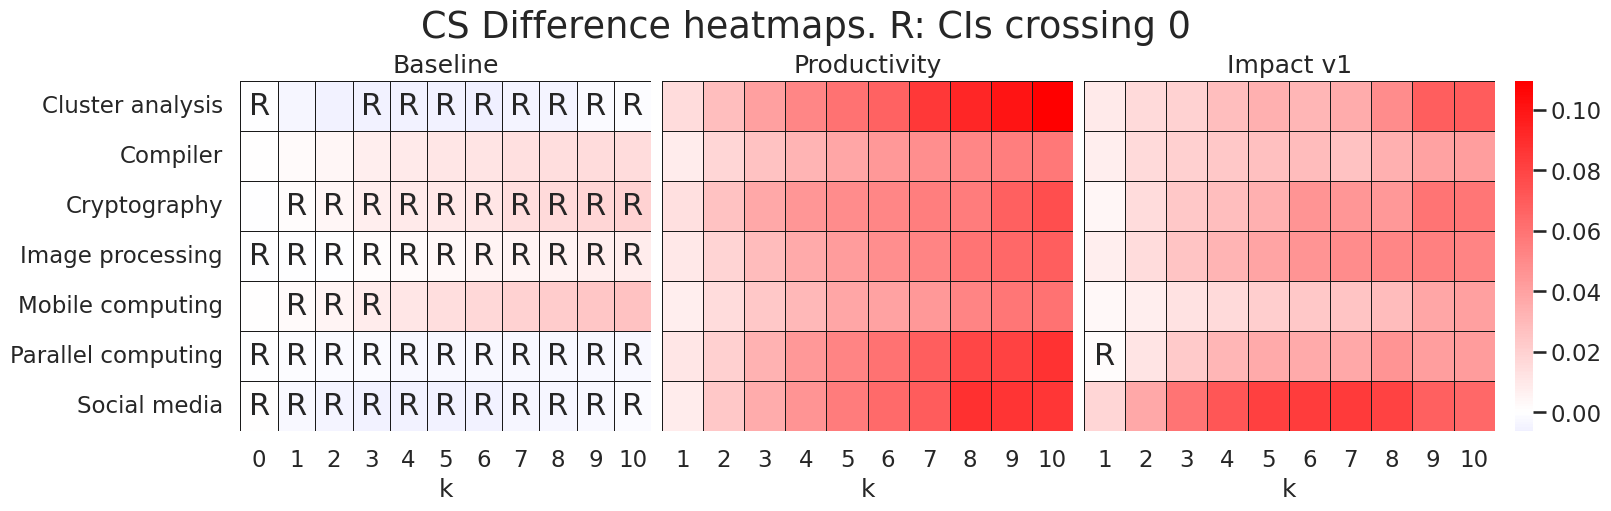

In [133]:
# field = 'BioMed'
field = 'CS'
# field = 'Physics'
errors = 'ci95'

agg_paths = list(Path(f'./csvs/aggregate/Mar-15/{field}/Exp 1/').glob(f'*_{errors}.csv'))
agg_dfs = (
    pd.concat([pd.read_csv(p) for p in agg_paths])
    .query('~topic.isin(@discard)')
)

fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=True, figsize=(16, 5), sharey=True, layout='constrained')
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

vmin = min(agg_dfs[['base_diff_mean', 'Prod_diff_mean', 'Imp1_diff_mean']].min())
vmax = max(agg_dfs[['base_diff_mean', 'Prod_diff_mean', 'Imp1_diff_mean']].max())

hm = plot_topics_heatmap(data=agg_dfs, x='k', y='topic', values='base_diff_mean', ax=axs[0], vmin=vmin, vmax=vmax, cbar=False)
plot_topics_heatmap(data=agg_dfs, x='k', y='topic', values='Prod_diff_mean', ax=axs[1], vmin=vmin, vmax=vmax, cbar=False)
hm = plot_topics_heatmap(data=agg_dfs, x='k', y='topic', values='Imp1_diff_mean', ax=axs[2], vmin=vmin, vmax=vmax, cbar=True)

titles = 'Baseline', 'Productivity', 'Impact v1'
for i, ax in enumerate(axs):
    ax.set_ylabel('')
    ax.set_title(titles[i])
    # if i > 0:
    ax.tick_params(left=False, bottom=False)
    ax.spines[:].set_visible(False)

fig.suptitle(f'{field} Difference heatmaps. R: CIs crossing 0');
# fig.savefig(f'./figures/{field}/Exp 1/heatmaps.png', bbox_inches='tight')
# fig.colorbar(hm, location='bottom')

In [134]:
agg_paths

[PosixPath('csvs/aggregate/Mar-15/CS/Exp 1/Image processing_ci95.csv'),
 PosixPath('csvs/aggregate/Mar-15/CS/Exp 1/Parallel computing_ci95.csv'),
 PosixPath('csvs/aggregate/Mar-15/CS/Exp 1/Cluster analysis_ci95.csv'),
 PosixPath('csvs/aggregate/Mar-15/CS/Exp 1/Cryptography_ci95.csv'),
 PosixPath('csvs/aggregate/Mar-15/CS/Exp 1/Mobile computing_ci95.csv'),
 PosixPath('csvs/aggregate/Mar-15/CS/Exp 1/Social media_ci95.csv'),
 PosixPath('csvs/aggregate/Mar-15/CS/Exp 1/Compiler_ci95.csv')]

## plot the differences here

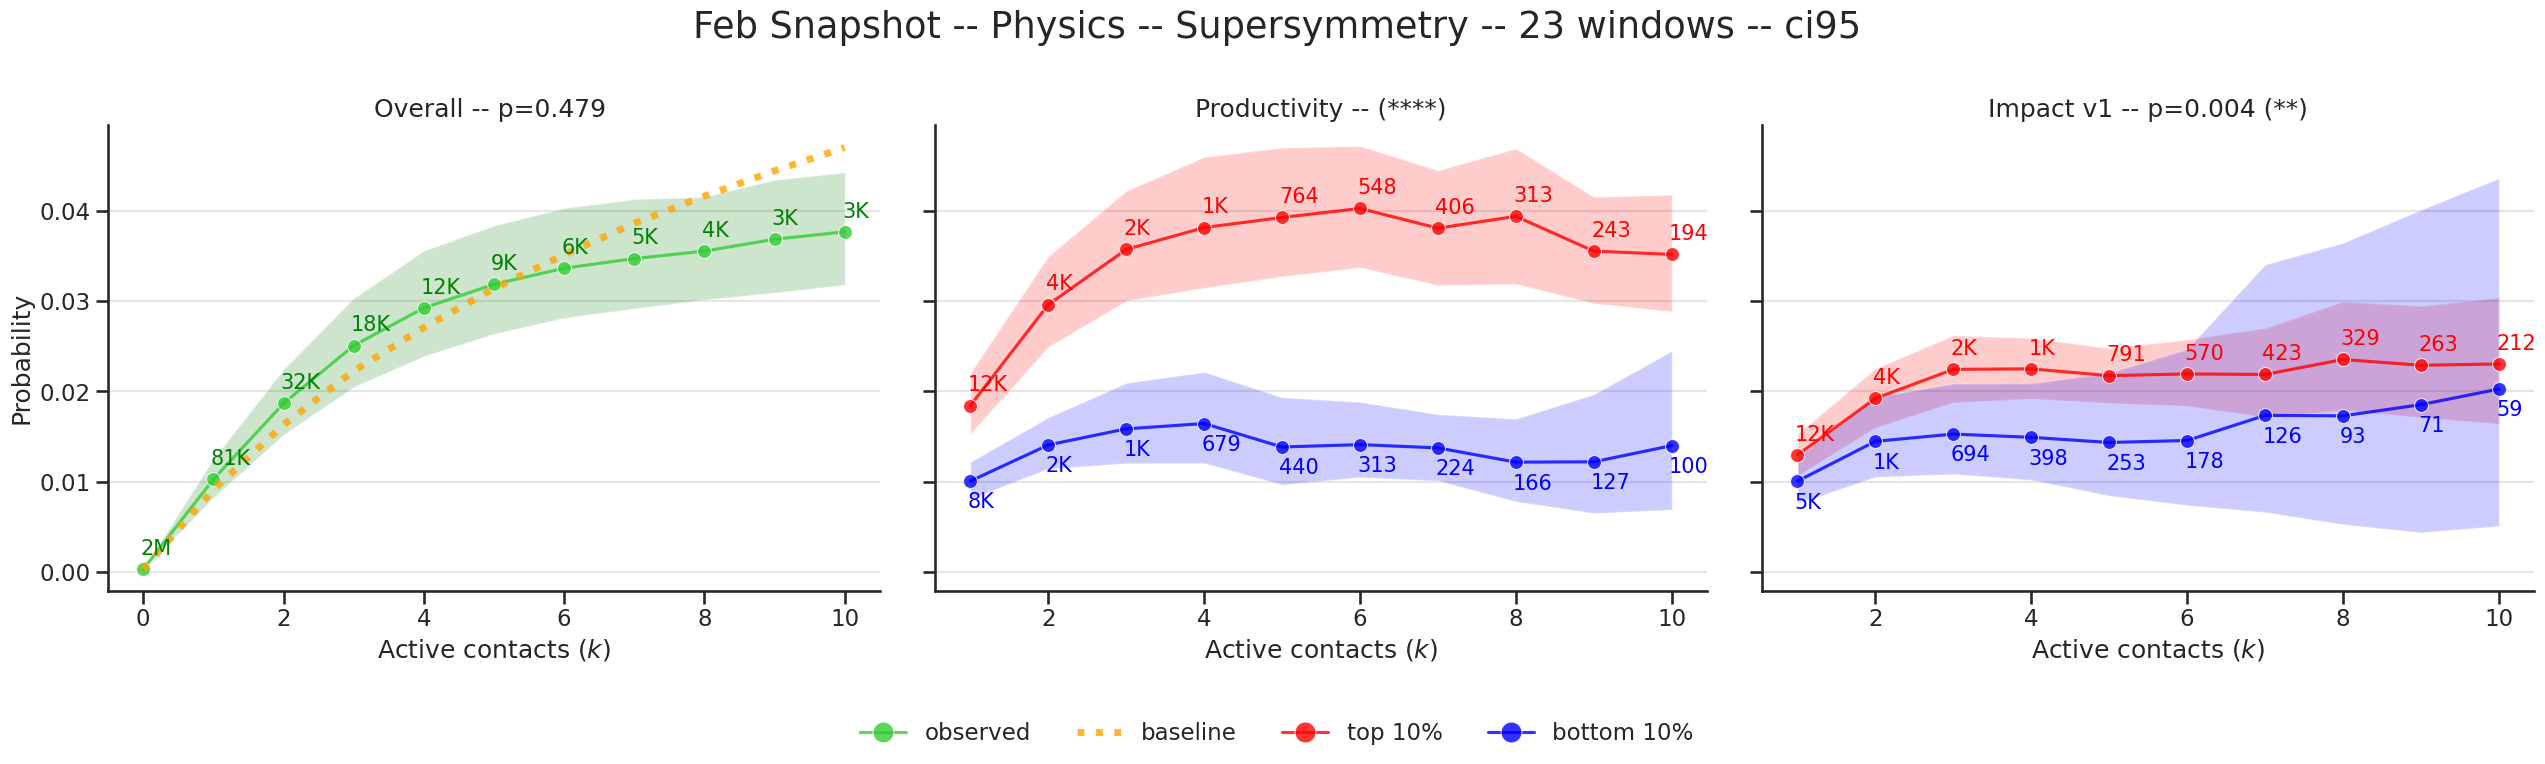

In [380]:
field = 'Physics'
# field = 'CS'
# topic = 'Social media'
# topic = 'Image processing'
topic = 'Supersymmetry'
errors = 'ci95'

agg_path = Path(f'./csvs/aggregate/Mar-15/{field}/Exp 1/{topic}_{errors}.csv')
agg_df = pd.read_csv(agg_path)

fig, axs = plt.subplots(ncols=3, figsize=(26, 7), squeeze=True, 
                            sharey=True, layout='tight')

sns.despine()
args = dict(marker='o', markersize=10, alpha=0.8)

##### PART A
ax = axs[0]

p_val = scipy.stats.ks_2samp(agg_df.activ_prob_mean, agg_df.baseline).pvalue
# p_val = -1
agg_df.loc[:, 'activ_p_val'] = p_val
# agg_df.loc[:, 'activ_p_str'] = format_p_value(p_val)
ax.set_title(f'Overall -- {format_p_value(p_val)}');

sns.lineplot(data=agg_df, x='k', y='activ_prob_mean', ax=ax, label='observed', c='limegreen', **args);
plot_error_bands(data=agg_df, x='k', y='activ_prob_mean', errors=errors, facecolor='green', ax=ax);
annotate_plot(data=agg_df, x='k', y='activ_prob_mean', label_attr='overall_den_mean', color='green', ax=ax)

sns.lineplot(data=agg_df, x='k', y='baseline', ax=ax, label='baseline', c='orange', marker=None, alpha=0.8, 
             linestyle='dotted', linewidth=5);


######## PART B
ax = axs[1]
p_val = scipy.stats.ks_2samp(agg_df.Prod_high_mean, agg_df.Prod_low_mean).pvalue 
# p_val = -1
agg_df.loc[:, 'Prod_p_val'] = p_val
ax.set_title(f'Productivity -- {format_p_value(p_val)}');

sns.lineplot(data=agg_df, x='k', y='Prod_high_mean', ax=ax, c='red', label='top 10%', **args);
plot_error_bands(data=agg_df, x='k', y='Prod_high_mean', errors=errors, facecolor='red', ax=ax);
annotate_plot(data=agg_df, x='k', y='Prod_high_mean', label_attr='Prod_den_high1_mean', color='red', ax=ax)

sns.lineplot(data=agg_df, x='k', y='Prod_low_mean', ax=ax, c='blue', label='bottom 10%', **args);
plot_error_bands(data=agg_df, x='k', y='Prod_low_mean', errors=errors, facecolor='blue', ax=ax);
annotate_plot(data=agg_df, x='k', y='Prod_low_mean', label_attr='Prod_den_low1_mean', color='blue', orient='below', ax=ax)


######## PART C
ax = axs[2]
p_val = scipy.stats.ks_2samp(agg_df.Imp1_high_mean, agg_df.Imp1_low_mean).pvalue 
agg_df.loc[:, 'Imp1_p_val'] = p_val
# agg_df.loc[:, 'Imp1_p_str'] = format_p_value(p_val)
ax.set_title(f'Impact v1 -- {format_p_value(p_val)}');

sns.lineplot(data=agg_df, x='k', y='Imp1_high_mean', ax=ax, c='red', label='top 10%', **args);
plot_error_bands(data=agg_df, x='k', y='Imp1_high_mean', errors=errors, facecolor='red', ax=ax);
annotate_plot(data=agg_df, x='k', y='Imp1_high_mean', label_attr='Imp1_den_high1_mean', color='red', ax=ax)

sns.lineplot(data=agg_df, x='k', y='Imp1_low_mean', ax=ax, c='blue', label='bottom 10%', **args);
plot_error_bands(data=agg_df, x='k', y='Imp1_low_mean', errors=errors, facecolor='blue', ax=ax);
annotate_plot(data=agg_df, x='k', y='Imp1_low_mean', label_attr='Imp1_den_low1_mean', color='blue', orient='below', ax=ax)

##  all plots
for ax in axs:
    ax.grid(axis='y', alpha=0.5);
    ax.set_xlabel('Active contacts ($k$)');
    ax.set_ylabel('Probability');
    ax.legend().set_visible(False);

fig.suptitle(f'Feb Snapshot -- {field} -- {topic} -- {len(viable_windows)} windows -- {errors}')
handles1, labels1 = axs[0].get_legend_handles_labels()
handles2, labels2 = axs[1].get_legend_handles_labels()
# labels = [methods_dict.get(l, l) for l in labels]
fig.legend(handles1+handles2, labels1+labels2, loc='lower center', ncols=4, 
           markerscale=1.5, fancybox=False, frameon=False, title_fontsize=20,
           bbox_to_anchor=(0.5, -0.1))    

display(fig)
plt.close(fig)
plt.close('all')
# fig.savefig(image_path, bbox_inches='tight')

In [532]:
[c for c in agg_df.columns.tolist() if 'raw' in c]

['activ_prob_raw_mean',
 'activ_prob_raw_mean_ci95_min',
 'activ_prob_raw_mean_ci95_max',
 'raw_baseline_mean',
 'raw_baseline_mean_ci95_min',
 'raw_baseline_mean_ci95_max',
 'raw_base_diff_mean',
 'raw_base_diff_mean_ci95_min',
 'raw_base_diff_mean_ci95_max',
 'Prod_raw_high_mean',
 'Prod_raw_high_mean_ci95_min',
 'Prod_raw_high_mean_ci95_max',
 'Prod_raw_low_mean',
 'Prod_raw_low_mean_ci95_min',
 'Prod_raw_low_mean_ci95_max',
 'Prod_raw_diff_mean',
 'Prod_raw_diff_mean_ci95_min',
 'Prod_raw_diff_mean_ci95_max',
 'Imp1_raw_high_mean',
 'Imp1_raw_high_mean_ci95_min',
 'Imp1_raw_high_mean_ci95_max',
 'Imp1_raw_low_mean',
 'Imp1_raw_low_mean_ci95_min',
 'Imp1_raw_low_mean_ci95_max',
 'Imp1_raw_diff_mean',
 'Imp1_raw_diff_mean_ci95_min',
 'Imp1_raw_diff_mean_ci95_max']

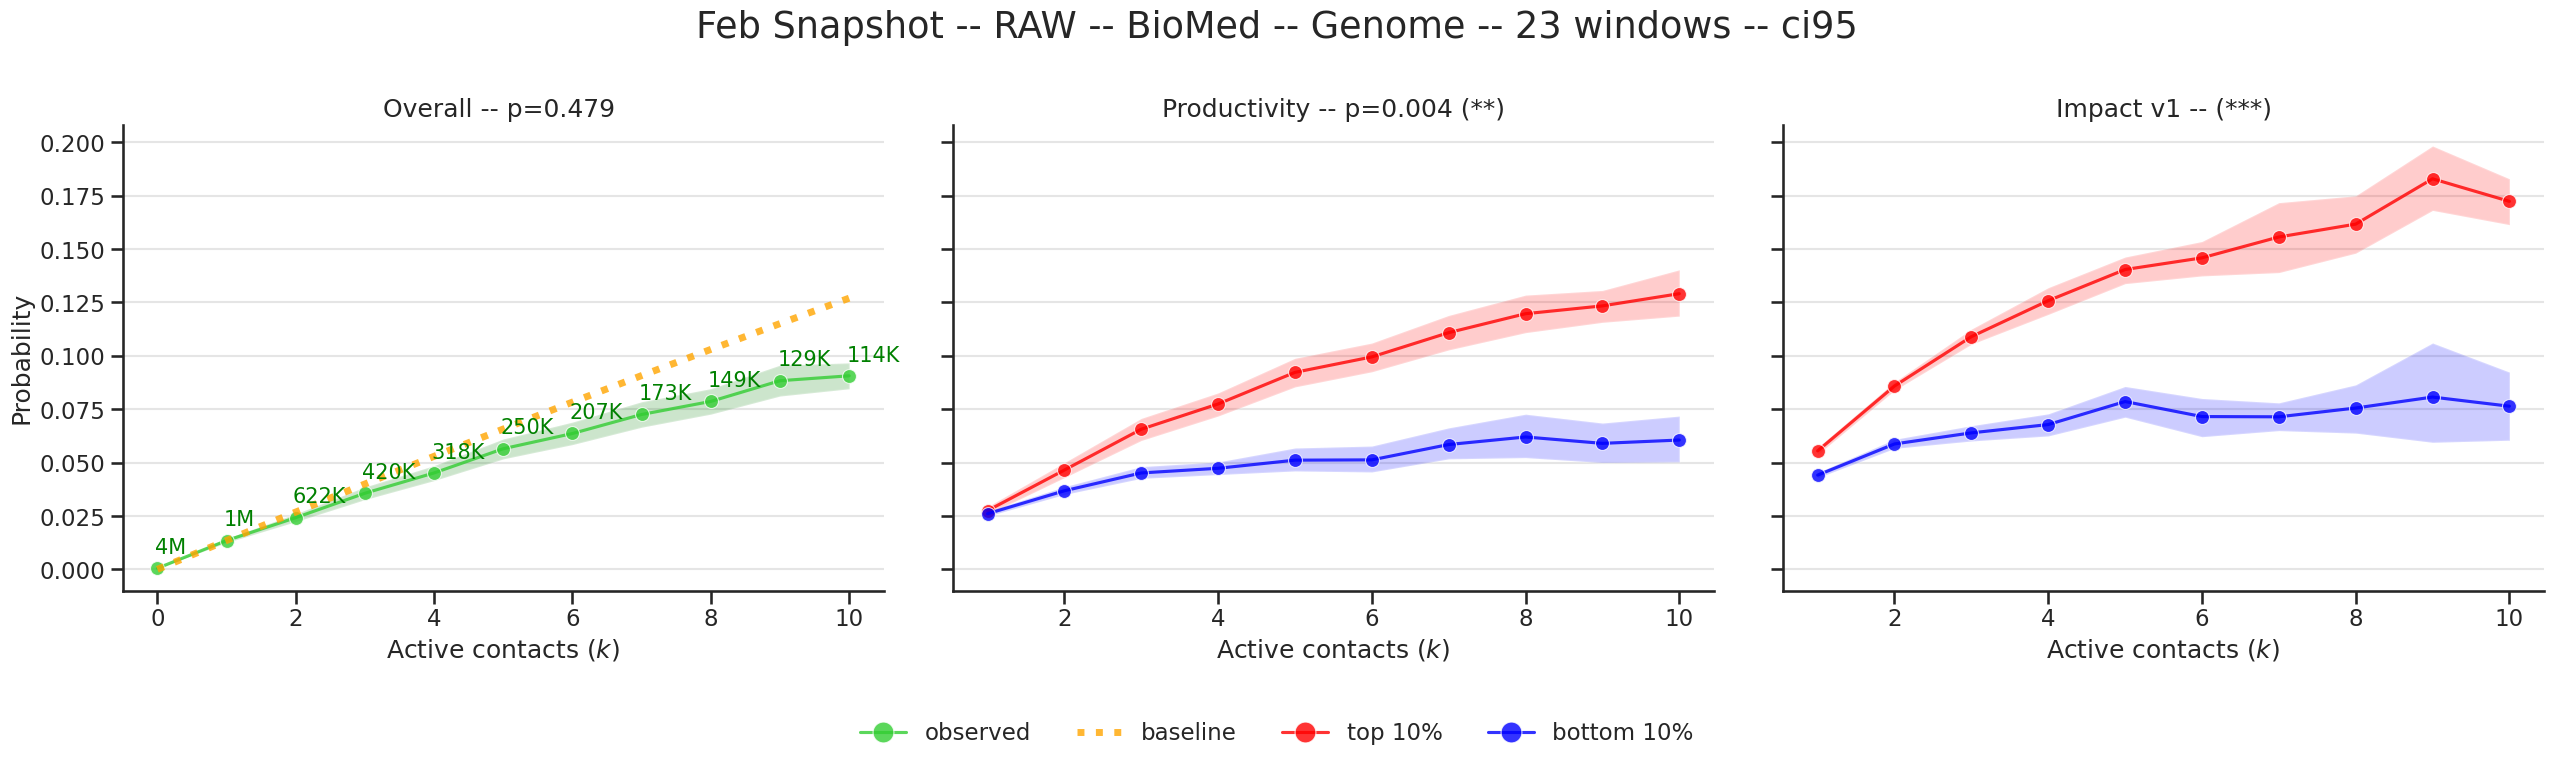

In [539]:
field = 'BioMed'
# field = 'CS'
# topic = 'Social media'
# topic = 'Image processing'
# topic = 'Supersymmetry'
topic = 'Genome'
errors = 'ci95'

agg_path = Path(f'./csvs/aggregate/Mar-15/{field}/Exp 1/{topic}_{errors}.csv')
agg_df = pd.read_csv(agg_path)

fig, axs = plt.subplots(ncols=3, figsize=(26, 7), squeeze=True, 
                            sharey=True, layout='tight')

sns.despine()
args = dict(marker='o', markersize=10, alpha=0.8)

##### PART A
ax = axs[0]

p_val = scipy.stats.ks_2samp(agg_df.activ_prob_raw_mean, agg_df.raw_baseline_mean).pvalue
# p_val = -1
agg_df.loc[:, 'activ_p_val'] = p_val
# agg_df.loc[:, 'activ_p_str'] = format_p_value(p_val)
ax.set_title(f'Overall -- {format_p_value(p_val)}');

sns.lineplot(data=agg_df, x='k', y='activ_prob_raw_mean', ax=ax, label='observed', c='limegreen', **args);
plot_error_bands(data=agg_df, x='k', y='activ_prob_raw_mean', errors=errors, facecolor='green', ax=ax);
annotate_plot(data=agg_df, x='k', y='activ_prob_raw_mean', label_attr='overall_den_mean', color='green', ax=ax)

sns.lineplot(data=agg_df, x='k', y='raw_baseline_mean', ax=ax, label='baseline', c='orange', marker=None, alpha=0.8, 
             linestyle='dotted', linewidth=5);


######## PART B
ax = axs[1]
p_val = scipy.stats.ks_2samp(agg_df.Prod_raw_high_mean, agg_df.Prod_raw_low_mean).pvalue 
# p_val = -1
agg_df.loc[:, 'Prod_p_val'] = p_val
ax.set_title(f'Productivity -- {format_p_value(p_val)}');

sns.lineplot(data=agg_df, x='k', y='Prod_raw_high_mean', ax=ax, c='red', label='top 10%', **args);
plot_error_bands(data=agg_df, x='k', y='Prod_raw_high_mean', errors=errors, facecolor='red', ax=ax);
# annotate_plot(data=agg_df, x='k', y='Prod_raw_high_mean', label_attr='Prod_den_high1_mean', color='red', ax=ax)

sns.lineplot(data=agg_df, x='k', y='Prod_raw_low_mean', ax=ax, c='blue', label='bottom 10%', **args);
plot_error_bands(data=agg_df, x='k', y='Prod_raw_low_mean', errors=errors, facecolor='blue', ax=ax);
# annotate_plot(data=agg_df, x='k', y='Prod_raw_low_mean', label_attr='Prod_den_low1_mean', color='blue', orient='below', ax=ax)


######## PART C
ax = axs[2]
p_val = scipy.stats.ks_2samp(agg_df.Imp1_raw_high_mean, agg_df.Imp1_raw_low_mean).pvalue 
agg_df.loc[:, 'Imp1_p_val'] = p_val
# agg_df.loc[:, 'Imp1_p_str'] = format_p_value(p_val)
ax.set_title(f'Impact v1 -- {format_p_value(p_val)}');

sns.lineplot(data=agg_df, x='k', y='Imp1_raw_high_mean', ax=ax, c='red', label='top 10%', **args);
plot_error_bands(data=agg_df, x='k', y='Imp1_raw_high_mean', errors=errors, facecolor='red', ax=ax);
# annotate_plot(data=agg_df, x='k', y='Imp1_raw_high_mean', label_attr='Imp1_den_high1_mean', color='red', ax=ax)

sns.lineplot(data=agg_df, x='k', y='Imp1_raw_low_mean', ax=ax, c='blue', label='bottom 10%', **args);
plot_error_bands(data=agg_df, x='k', y='Imp1_raw_low_mean', errors=errors, facecolor='blue', ax=ax);
# annotate_plot(data=agg_df, x='k', y='Imp1_low_mean', label_attr='Imp1_den_low1_mean', color='blue', orient='below', ax=ax)

##  all plots
for ax in axs:
    ax.grid(axis='y', alpha=0.5);
    ax.set_xlabel('Active contacts ($k$)');
    ax.set_ylabel('Probability');
    ax.legend().set_visible(False);

fig.suptitle(f'Feb Snapshot -- RAW -- {field} -- {topic} -- {len(viable_windows)} windows -- {errors}')
handles1, labels1 = axs[0].get_legend_handles_labels()
handles2, labels2 = axs[1].get_legend_handles_labels()
# labels = [methods_dict.get(l, l) for l in labels]
fig.legend(handles1+handles2, labels1+labels2, loc='lower center', ncols=4, 
           markerscale=1.5, fancybox=False, frameon=False, title_fontsize=20,
           bbox_to_anchor=(0.5, -0.1))    

display(fig)
plt.close(fig)
plt.close('all')
# fig.savefig(image_path, bbox_inches='tight')

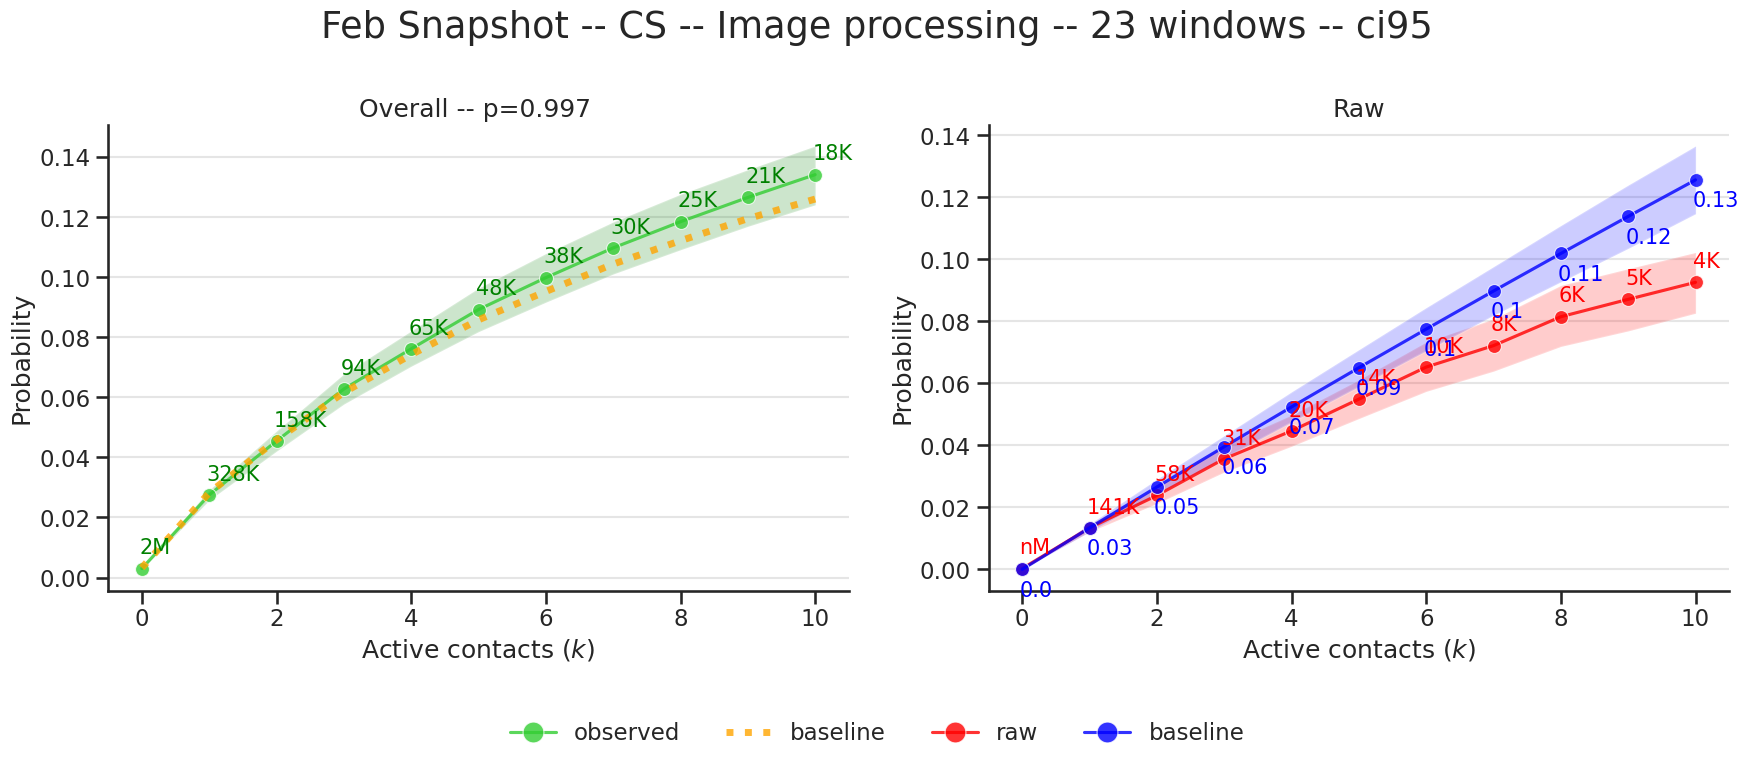

In [423]:
# field = 'Physics'
field = 'CS'
# topic = 'Social media'
topic = 'Image processing'
# topic = 'Gravitational wave'
# topic = 'Soliton'
errors = 'ci95'

agg_path = Path(f'./csvs/aggregate/Mar-15/{field}/Exp 1/{topic}_{errors}.csv')
agg_df = pd.read_csv(agg_path)

fig, axs = plt.subplots(ncols=2, figsize=(18, 7), squeeze=True, 
                            sharey=False, layout='tight')

sns.despine()
args = dict(marker='o', markersize=10, alpha=0.8)

##### PART A
ax = axs[0]

p_val = scipy.stats.ks_2samp(agg_df.activ_prob_mean, agg_df.baseline).pvalue
# p_val = -1
agg_df.loc[:, 'activ_p_val'] = p_val
# agg_df.loc[:, 'activ_p_str'] = format_p_value(p_val)
ax.set_title(f'Overall -- {format_p_value(p_val)}');

sns.lineplot(data=agg_df, x='k', y='activ_prob_mean', ax=ax, label='observed', c='limegreen', **args);
plot_error_bands(data=agg_df, x='k', y='activ_prob_mean', errors=errors, facecolor='green', ax=ax);
annotate_plot(data=agg_df, x='k', y='activ_prob_mean', label_attr='overall_den_mean', color='green', ax=ax)

sns.lineplot(data=agg_df, x='k', y='baseline', ax=ax, label='baseline', c='orange', marker=None, alpha=0.8, 
             linestyle='dotted', linewidth=5);


######## PART B
ax = axs[1]
# p_val = scipy.stats.ks_2samp(agg_df.Prod_high_mean, agg_df.Prod_low_mean).pvalue 
# agg_df.loc[:, 'Prod_p_val'] = p_val
ax.set_title(f'Raw');

sns.lineplot(data=agg_df, x='k', y='activ_prob_raw_mean', ax=ax, c='red', label='raw', **args);
plot_error_bands(data=agg_df, x='k', y='activ_prob_raw_mean', errors=errors, facecolor='red', ax=ax);
annotate_plot(data=agg_df, x='k', y='activ_prob_raw_mean', label_attr='Prod_den_high1_mean', color='red', ax=ax)

sns.lineplot(data=agg_df, x='k', y='raw_baseline_mean', ax=ax, c='blue', label='baseline', **args);
plot_error_bands(data=agg_df, x='k', y='raw_baseline_mean', errors=errors, facecolor='blue', ax=ax);
annotate_plot(data=agg_df, x='k', y='raw_baseline_mean', label_attr='baseline', color='blue', orient='below', ax=ax)


##  all plots
for ax in axs:
    ax.grid(axis='y', alpha=0.5);
    ax.set_xlabel('Active contacts ($k$)');
    ax.set_ylabel('Probability');
    ax.legend().set_visible(False);

fig.suptitle(f'Feb Snapshot -- {field} -- {topic} -- {len(viable_windows)} windows -- {errors}')
handles1, labels1 = axs[0].get_legend_handles_labels()
handles2, labels2 = axs[1].get_legend_handles_labels()
# labels = [methods_dict.get(l, l) for l in labels]
fig.legend(handles1+handles2, labels1+labels2, loc='lower center', ncols=4, 
           markerscale=1.5, fancybox=False, frameon=False, title_fontsize=20,
           bbox_to_anchor=(0.5, -0.1))    

display(fig)
plt.close(fig)
plt.close('all')
# fig.savefig(image_path, bbox_inches='tight')

In [398]:
[c for c in agg_df.columns if 'raw' in c]

['activ_prob_raw_mean',
 'activ_prob_raw_mean_ci95_min',
 'activ_prob_raw_mean_ci95_max',
 'raw_baseline_mean',
 'raw_baseline_mean_ci95_min',
 'raw_baseline_mean_ci95_max',
 'raw_diff_mean',
 'raw_diff_mean_ci95_min',
 'raw_diff_mean_ci95_max']

## Compute the difference between top and bottom 10% over k 

In [844]:
%%bash
rm -rf figures.zip 
zip -r figures.zip figures

  adding: figures/ (stored 0%)
  adding: figures/Physics/ (stored 0%)
  adding: figures/Physics/Exp 1/ (stored 0%)
  adding: figures/Physics/Exp 1/Gravitational wave.png (deflated 7%)
  adding: figures/Physics/Exp 1/Magnetoresistance.png (deflated 7%)
  adding: figures/Physics/Exp 1/Superconductivity.png (deflated 7%)
  adding: figures/Physics/Exp 1/Supersymmetry.png (deflated 7%)
  adding: figures/Physics/Exp 1/Fluid dynamics.png (deflated 7%)
  adding: figures/Physics/Exp 1/Statistical physics.png (deflated 7%)
  adding: figures/Physics/Exp 1/Soliton.png (deflated 8%)
  adding: figures/Physics/Exp 1/Dark matter.png (deflated 7%)
  adding: figures/Physics/.ipynb_checkpoints/ (stored 0%)
  adding: figures/Physics/Exp 2/ (stored 0%)
  adding: figures/Physics/Exp 2/2C_thresh=0.05.png (deflated 16%)
  adding: figures/Physics/Exp 2/2A_thresh=0.05.png (deflated 17%)
  adding: figures/Physics/Exp 2/.ipynb_checkpoints/ (stored 0%)
  adding: figures/Physics/Exp 2/2C_thresh=0.1.png (deflated 16

In [625]:
plt.show()

In [223]:
field = 'CS'
# topic = 'Image processing'#, 'Compiler'
topic = 'Compiler'
viable_windows = sorted(
    window_info_df
    .query('topic==@topic')
    [(window_info_df['EW-papers topic'] > works_threshold) & (window_info_df['OW-papers topic']>works_threshold)]
    ['T_0']
)
display(f'{topic} {len(viable_windows)} windows with >{works_threshold} papers')

cum_df = (
    pd.read_csv(basepath / field / 'Productivity/Exp1_ver1' / f'df_{topic}_windows_cum.csv', index_col=0)
    .query('T_0.isin(@viable_windows)', engine='python')
    .assign(topic=topic)
)
display(cum_df.head(3))

cum_sc_df = (
    pd.read_csv(basepath / field / 'Productivity/Exp1_ver1' / f'df_topic_stat_sc.csv', index_col=0)
    .query('topic==@topic')
)
display(cum_sc_df)
raw_df = (
    pd.read_csv(basepath / field / 'Productivity/Exp1_ver1' / f'df_topic_windows.csv', index_col=0)
    .query('topic==@topic')
    .query('T_0.isin(@viable_windows)', engine='python')
)
display(raw_df.head(3))

/tmp/ipykernel_30545/2712112315.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



'Compiler 13 windows with >3000 papers'

,T_0,k,prob,den,num,prob_high1,den_high1,num_high1,prob_low1,den_low1,num_low1,topic
0,2005,0,0.000556,2183499.0,1213.0,NaN,NaN,NaN,NaN,NaN,NaN,Compiler
1,2005,1,0.015550,70868.0,1102.0,0.029532,12935.0,382.0,0.011835,7858.0,93.0,Compiler
2,2005,2,0.027566,26518.0,731.0,0.054609,3992.0,218.0,0.020787,1780.0,37.0,Compiler


,topic,k,val
55,Compiler,0,0.000468
56,Compiler,1,0.009937
57,Compiler,2,0.017496
58,Compiler,3,0.024029
59,Compiler,4,0.029223
60,Compiler,5,0.033942
61,Compiler,6,0.037979
62,Compiler,7,0.041689
63,Compiler,8,0.044940
64,Compiler,9,0.047982


,topic,T_0,k,prob,den,num,prob_high1,den_high1,num_high1,prob_low1,den_low1,num_low1
14959,Compiler,2005,0,0.000053,2112631.0,111.0,NaN,NaN,NaN,NaN,NaN,NaN
14960,Compiler,2005,1,0.008365,44350.0,371.0,0.018338,8943.0,164.0,0.009214,6078.0,56.0
14961,Compiler,2005,2,0.015684,12752.0,200.0,0.035205,2102.0,74.0,0.020446,1076.0,22.0


In [278]:
## need to recompute the simple contagion baseline 
## double check the numbers with `df_topics_sc.csv`  - taking average of individual p's matches the SC numbers 

In [291]:
## recompute simple contagion baseline 
## have separate p for each T0 
## there is a difference between averaging num&denom and then taking the frac 
## v. computing the fraction individually and then averaging
## p1 appears to be the one that matches SC numbers

p_df = (
    raw_df
    [['topic', 'T_0', 'k', 'prob', 'den', 'num']]
    .query('k==1')
    .assign(p=lambda df_: df_.num/df_.den)
)
p1 = p_df.p.mean()
p2 = (p_df.num.mean()/p_df.den.mean())
display(f'{p1=} {p2=}')
## simple contagion baseline: 1 - (1 - p)^k
raw_df = (
    raw_df 
    .assign(
        raw_base1=lambda df_: 1 - (1 - p1)**df_.k,
        raw_base2=lambda df_: 1 - (1 - p2)**df_.k
    )
)
display(raw_df.head())

'p1=0.0051930602996647915 p2=0.004685110626823773'

,topic,T_0,k,prob,den,num,prob_high1,den_high1,num_high1,prob_low1,den_low1,num_low1,raw_base1,raw_base2
14959,Compiler,2005,0,0.000053,2112631.0,111.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
14960,Compiler,2005,1,0.008365,44350.0,371.0,0.018338,8943.0,164.0,0.009214,6078.0,56.0,0.005193,0.004685
14961,Compiler,2005,2,0.015684,12752.0,200.0,0.035205,2102.0,74.0,0.020446,1076.0,22.0,0.010359,0.009348
14962,Compiler,2005,3,0.023703,4683.0,111.0,0.059603,755.0,45.0,0.030120,332.0,10.0,0.015498,0.013990
14963,Compiler,2005,4,0.028520,2805.0,80.0,0.078534,382.0,30.0,0.006452,155.0,1.0,0.020611,0.018609


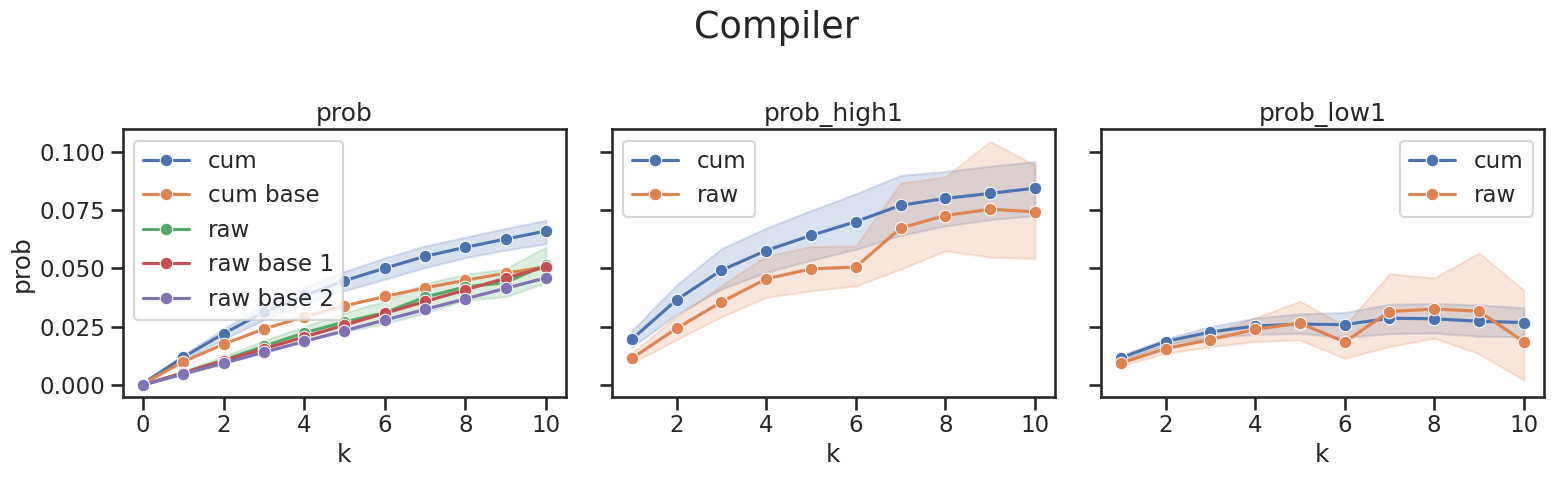

In [227]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 5), sharey=True, layout='tight')
fig.suptitle(f'{topic}')

ax = axs[0]
y = 'prob'
ax.set_title(f'{y}');
sns.lineplot(data=cum_df.query('k<=10'), x='k', y=y, marker='o', ax=ax, label='cum');
sns.lineplot(data=cum_sc_df.query('k<=10'), x='k', y='val', marker='o', ax=ax, label='cum base');

sns.lineplot(data=raw_df.query('k<=10'), x='k', y=y, marker='o', ax=ax, label='raw');
sns.lineplot(data=raw_df.query('k<=10'), x='k', y='raw_base1', marker='o', ax=ax, label='raw base 1');
sns.lineplot(data=raw_df.query('k<=10'), x='k', y='raw_base2', marker='o', ax=ax, label='raw base 2');

ax = axs[1]
y = 'prob_high1'
ax.set_title(f'{y}');
sns.lineplot(data=cum_df.query('k<=10'), x='k', y=y, marker='o', ax=ax, label='cum');
sns.lineplot(data=raw_df.query('k<=10'), x='k', y=y, marker='o', ax=ax, label='raw');

ax = axs[2]
y = 'prob_low1'
ax.set_title(f'{y}');
sns.lineplot(data=cum_df.query('k<=10'), x='k', y=y, marker='o', ax=ax, label='cum');
sns.lineplot(data=raw_df.query('k<=10'), x='k', y=y, marker='o', ax=ax, label='raw');

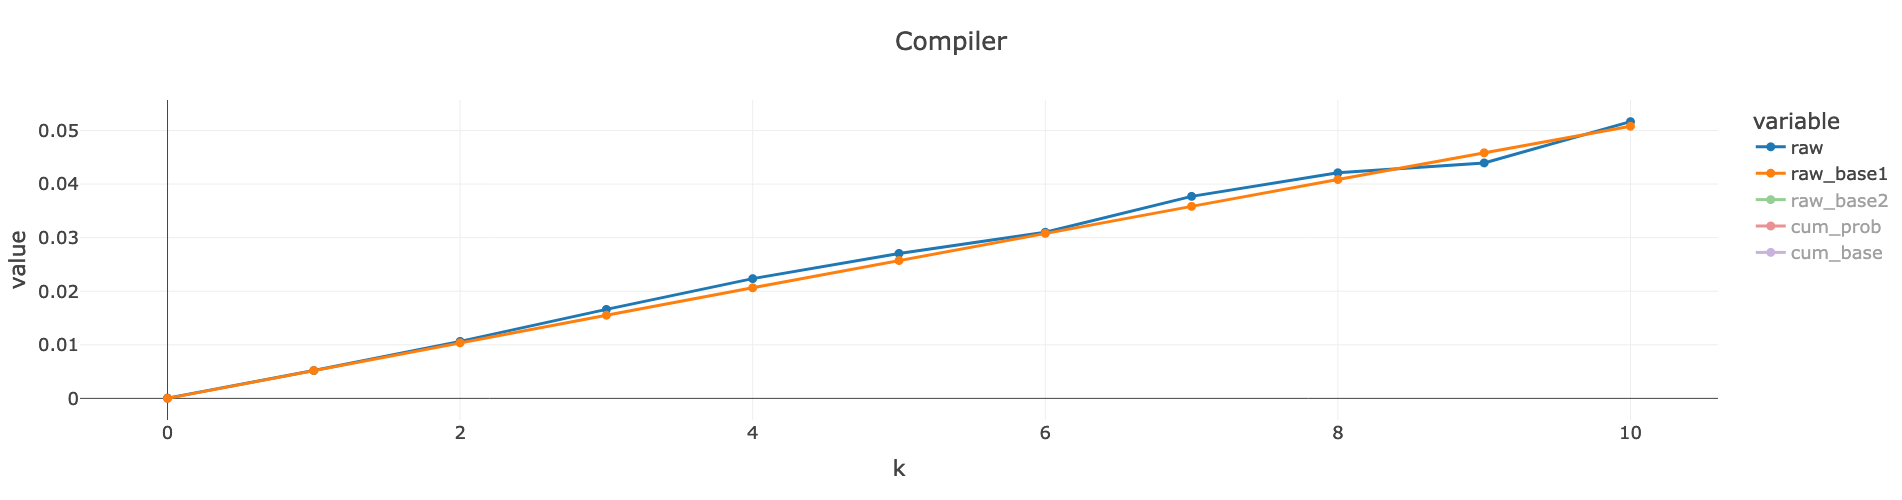

In [289]:
(
    raw_df
    .query('k<=10')
    .sort_values(by='k')
    .groupby('k')
    .agg(
        raw=('prob', 'mean'),
        raw_base1=('raw_base1', 'mean'),
        raw_base2=('raw_base2', 'mean'),
        num=('num', 'mean'),
        den=('den', 'mean'),
    )
    .join(
        cum_sc_df
        .rename(columns={'val': 'cum_base'})
        .set_index('k')
        .join(
            cum_df
            .groupby('k')
            .prob
            .mean()
            .rename('cum_prob')
        )
    )
    .round(5)
    .plot
    .line(y=['raw', 'raw_base1', 'raw_base2', 'cum_prob', 'cum_base'], hover_data={'num': '.2f'}, markers=True, title=topic, height=500,
         )
)

In [293]:
raw_df

,topic,T_0,k,prob,den,num,prob_high1,den_high1,num_high1,prob_low1,den_low1,num_low1,raw_base1,raw_base2
14959,Compiler,2005,0,0.000053,2112631.0,111.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
14960,Compiler,2005,1,0.008365,44350.0,371.0,0.018338,8943.0,164.0,0.009214,6078.0,56.0,0.005193,0.004685
14961,Compiler,2005,2,0.015684,12752.0,200.0,0.035205,2102.0,74.0,0.020446,1076.0,22.0,0.010359,0.009348
14962,Compiler,2005,3,0.023703,4683.0,111.0,0.059603,755.0,45.0,0.030120,332.0,10.0,0.015498,0.013990
14963,Compiler,2005,4,0.028520,2805.0,80.0,0.078534,382.0,30.0,0.006452,155.0,1.0,0.020611,0.018609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16983,Compiler,2017,326,1.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.816831,0.783667
16984,Compiler,2017,342,0.000000,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.831472,0.799326
16985,Compiler,2017,354,0.000000,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.841679,0.810322
16986,Compiler,2017,467,0.000000,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.912093,0.888428


In [292]:
## calculate cumulative baseline 
p = p1
prob_baselines = np.array([(1 - (1 - p)**k) for k in range(11)])

den = raw_df.groupby('k', sort=True).den.mean().rename('den')[: 11]
num = (prob_baselines * den).rename('num')

df_baselines = pd.DataFrame({'num': num, 'den': den})
df_baselines_rev = df_baselines.loc[::-1] 
# display(df_baselines_rev)
df_baselines['num_cum'] = df_baselines_rev['num'].cumsum().loc[::-1]
df_baselines['den_cum'] = df_baselines_rev['den'].cumsum().loc[::-1]
df_baselines['prob_cum'] = (df_baselines.num_cum / df_baselines.den_cum).loc[::-1]
# display(df_baselines)

(
    df_baselines
    .drop(columns=['num_cum', 'den_cum'])
    .query('k<=10')
    .join(
        cum_sc_df
        .set_index('k')
        .rename(columns={'val': 'precalculated_prob'})
    )
    .assign(is_close=lambda df_: np.isclose(df_.prob_cum, df_.precalculated_prob))
)

,num,den,prob_cum,topic,precalculated_prob,is_close
k,,,,,,
0,0.000000,3.431832e+06,0.000468,Compiler,0.000468,True
1,540.737390,1.041269e+05,0.009937,Compiler,0.009937,True
2,323.515543,3.122992e+04,0.017496,Compiler,0.017496,True
3,200.089336,1.291031e+04,0.024029,Compiler,0.024029,True
4,154.728313,7.507077e+03,0.029223,Compiler,0.029223,True
5,115.707749,4.502769e+03,0.033942,Compiler,0.033942,True
6,96.003283,3.121385e+03,0.037979,Compiler,0.037979,True
7,77.254033,2.158538e+03,0.041689,Compiler,0.041689,True
8,67.654267,1.658308e+03,0.044940,Compiler,0.044940,True


In [343]:
## calculate cumulative baseline for individual T0's 
dfs = []
for T0, T0_grp in raw_df.groupby('T_0', sort=True):
    T0_grp = (
        T0_grp
        .sort_values(by='k')
        .assign(p=lambda df_: df_.num / df_.den)
        .query('k<=10')
    )
    p = T0_grp.query('k==1').p.values[0]  # get the p value 
    # display(T0, T0_grp.head(2), p)

    prob_baseline = np.array([(1 - (1 - p)**k) for k in range(11)])

    df_baseline = pd.DataFrame({
        'k': range(11), 
        'num': prob_baseline * T0_grp.den, 
        'den': T0_grp.den,
    })
    df_baseline_rev = df_baseline.loc[::-1] 

    df_baseline = (
        df_baseline
        .assign(
            T_0=T0, topic=topic,
            num_cum=df_baseline_rev['num'].cumsum().loc[::-1], 
            den_cum=df_baseline_rev['den'].cumsum().loc[::-1],
            baseline2=lambda df_: (df_.num_cum / df_.den_cum).loc[::-1],
        )
        [['topic', 'T_0', 'k', 'baseline2']]
    )
    # display(df_baseline)
    dfs.append(df_baseline)

all_base_df = pd.concat(dfs)
all_base_df.head(2)

,topic,T_0,k,baseline2
14959,Compiler,2005,0,0.000477
14960,Compiler,2005,1,0.015033


In [345]:
topic_data_df = (
    pd.read_csv(basepath / 'CS/Productivity/Exp1_ver1' / f'df_{topic}_windows_cum.csv', index_col=0)
    .query('T_0.isin(@viable_windows)', engine='python')
    .assign(min_works=works_threshold, topic=topic, metric=metric)
    .sort_values(by=['T_0', 'k'])
    .query('k<=10')
    .assign(diff=lambda df_: df_.prob_high1-df_.prob_low1)
    # .assign(baseline=lambda df_: df_.k.map(baseline_dict))  # get the baseline values
    # .assign(base_diff=lambda df_: df_.prob-df_.baseline)
)
topic_data_df = (
    topic_data_df
    .merge(
        all_base_df,
        on=['topic', 'T_0', 'k'],
        how='inner'
    )
    .assign(base_diff2=lambda df_: df_.prob-df_.baseline2)
)
topic_data_df.head(2)

,T_0,k,prob,den,num,prob_high1,den_high1,num_high1,prob_low1,den_low1,num_low1,min_works,topic,metric,diff,baseline2,base_diff2
0,2005,0,0.000556,2183499.0,1213.0,NaN,NaN,NaN,NaN,NaN,NaN,3000,Compiler,Imp1,NaN,0.000477,0.000079
1,2005,1,0.015550,70868.0,1102.0,0.029532,12935.0,382.0,0.011835,7858.0,93.0,3000,Compiler,Imp1,0.017697,0.015033,0.000517
2,2005,2,0.027566,26518.0,731.0,0.054609,3992.0,218.0,0.020787,1780.0,37.0,3000,Compiler,Imp1,0.033823,0.026928,0.000638
3,2005,3,0.038573,13766.0,531.0,0.076190,1890.0,144.0,0.021307,704.0,15.0,3000,Compiler,Imp1,0.054884,0.037742,0.000832
4,2005,4,0.046240,9083.0,420.0,0.087225,1135.0,99.0,0.013441,372.0,5.0,3000,Compiler,Imp1,0.073784,0.045848,0.000392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2017,6,0.040856,30204.0,1234.0,0.060929,3381.0,206.0,0.036585,656.0,24.0,3000,Compiler,Imp1,0.024343,0.026049,0.014806
139,2017,7,0.044939,24344.0,1094.0,0.069278,2425.0,168.0,0.040084,474.0,19.0,3000,Compiler,Imp1,0.029194,0.028621,0.016319
140,2017,8,0.049084,20312.0,997.0,0.072503,1862.0,135.0,0.025352,355.0,9.0,3000,Compiler,Imp1,0.047151,0.030868,0.018216
141,2017,9,0.052308,17225.0,901.0,0.077247,1424.0,110.0,0.026022,269.0,7.0,3000,Compiler,Imp1,0.051225,0.032959,0.019349


## Experiment II

* `df_topic_windows_0.05.csv` has all the window stats that need to be aggregated 

* 2A: high1_A, low1_A
* 2B: high1_B, low1_B
* 2C: high1_bin1_A, high1_bin2_A

'CS'

{'Anomaly detection',
 'Cluster analysis',
 'Compiler',
 'Cryptography',
 'Feature selection',
 'Java',
 'Logistic regression',
 'Mobile computing',
 'Naive Bayes classifier',
 'Operating system',
 'Parallel computing',
 'Reinforcement learning',
 'Support vector machine',
 'Virtual machine',
 'Wearable computer'}

PosixPath('data/Mar-8/CS/Imp1/EXP2')

In [1273]:
%%bash 
rm -rf figures/Physics/Exp\ 2

In [10]:
exp = 'Exp2' # 'EXP2'
works_threshold = 3_000

for field in tqdm(('Physics', 'CS', 'BioMed')[1: ]):
    img_path = Path(f'./figures/{field}/Exp 2/')
    img_path.mkdir(exist_ok=True, parents=True)

    window_info_df = pd.read_csv(basepath / field / 'info_windows.csv', sep=';')
    display(window_info_df.head(1))
    replace_images = True 
    agg_dfs = []
    suffix = '' if works_threshold == 3000 else f'_{works_threshold//1000}k'

    for errors in ('ci95', 'se')[: 1]:
        if errors == 'ci95':
            errorfunc = ('ci', 95)
        else: 
            errorfunc = errors

        for thresh in (0.05, 0.1, 0.2):
            agg_dfs = []
            agg_path = Path(f'./csvs/aggregate/Mar-15/{field}/Exp 2/{thresh=}_{errors}{suffix}.csv')
            for topic in tqdm(topic_orders[field]):
                image_path = img_path / f'{topic}_{errors}.png'

                viable_windows = sorted(
                    window_info_df
                    .query('topic==@topic')
                    [(window_info_df['EW-papers topic'] > works_threshold) & (window_info_df['OW-papers topic']>works_threshold)]
                    ['T_0']
                )
                display(f'{topic} {len(viable_windows)} windows with >{works_threshold} papers')

                if len(viable_windows) < 5:
                    print(f'-----------------Skipping {topic}-------------------')
                    continue

                metric_dict = {'Productivity': 'Prod', 'Impact_mean1': 'Imp1'}
                missing = False
                dfs = []
                for i, metric in enumerate(['Productivity', 'Impact_mean1']):
                    csvpath = basepath / field / metric / exp
                    metric = metric_dict[metric]
                    topic_data_df = (
                        pd.read_csv(csvpath / f'df_topic_windows_{thresh}.csv', index_col=0)
                        .query('T_0.isin(@viable_windows)', engine='python')
                        .query('topic==@topic')
                        .assign(min_works=works_threshold, topic=topic, metric=metric)
                        .sort_values(by='T_0')
                    )

                    if len(topic_data_df) == 0:
                        missing = True 
                        break
                    # display(topic_data_df.head(3))

                    # compute the difference between the high&low for A, B, and C
                    diff_df = (
                        topic_data_df
                        .set_index('T_0')  # so we dont do the diffs on the years 
                        [['high1_A', 'low1_A', 'high1_B', 'low1_B', 'high1_bin1_A', 'high1_bin2_A']]
                        .diff(periods=-1, axis=1)
                        .reset_index()
                        .drop(columns=['low1_A', 'low1_B', 'high1_bin2_A'])
                        .rename(columns={'high1_A': 'diff_A', 'high1_B': 'diff_B', 'high1_bin1_A': 'diff_C'})
                    )

                    combined_df = topic_data_df.merge(diff_df, on='T_0')
                    grouped = combined_df.groupby('Perc', group_keys=True, sort=False)    
                    ### aggregate all the data 
                    cols = [('highA', 'high1_A'), ('lowA', 'low1_A'), #('inactiveA', 'inactive1_A'),
                            ('highB', 'high1_B'), ('lowB', 'low1_B'),
                            ('more_coauthC', 'high1_bin1_A'), ('less_coauthC', 'high1_bin2_A'),
                            ('diffA', 'diff_A'), ('diffB', 'diff_B'), ('diffC', 'diff_C')]  # two tuples of names and actual names

                    for col_name, col in tqdm(cols):
                        if col_name.startswith('diff'):
                            errorf = ('ci', 95)  # use 95% CI for diff columns 
                        else:
                            errorf = errorfunc
                        df = (
                            grouped
                            .apply(lambda g: conf_interval(g[col], errorfunc=errorf))
                            .add_prefix(f'{metric}_{col_name}_')
                        )
                        dfs.append(df)
                if missing:
                    continue 

                agg_df = (
                    pd.concat(dfs, axis=1).reset_index()
                )
                agg_df = agg_df.loc[:,~agg_df.columns.duplicated()]  # remove duplicate columns 
                agg_df.insert(0, 'topic', topic)
                agg_df.insert(1, 'windows', len(viable_windows))
                display(agg_df.head(3))
                agg_dfs.append(agg_df)

            agg_df = (
                pd.concat(agg_dfs)
                .rename(columns={'Perc': 'threshold'})
            )
            display(agg_df)

            agg_path.parent.mkdir(exist_ok=True, parents=True)
            agg_df.to_csv(agg_path, index=False)

  0%|          | 0/2 [00:00<?, ?it/s]

,topic,T_0,EW-papers topic,EW-authors topic - active authors,OW-papers topic,OW-authors topic
0,Support vector machine,1995,160,350,375,817


  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Compiler 13 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Compiler,13,0.05,0.140157,0.127528,0.152627,0.06154,0.054943,0.067935,0.331711,...,0.109742,0.024037,0.015458,0.032923,0.035004,-0.022172,0.092208,-0.054165,-0.070675,-0.036695


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Mobile computing 13 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Mobile computing,13,0.05,0.122819,0.093867,0.154464,0.067068,0.051232,0.084764,0.268885,...,0.110963,0.030143,0.021977,0.037335,0.02031,-0.007302,0.04764,-0.043521,-0.059757,-0.028855


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Cryptography 15 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Cryptography,15,0.05,0.169841,0.145723,0.196337,0.096138,0.078193,0.115881,0.327084,...,0.158398,0.040024,0.033163,0.047533,0.097349,0.068444,0.122113,-0.085196,-0.098301,-0.073458


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Cluster analysis 21 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Cluster analysis,21,0.05,0.203442,0.182819,0.224849,0.135842,0.122129,0.150216,0.263908,...,0.168285,0.037246,0.030435,0.044117,0.036437,0.01916,0.053169,-0.019778,-0.034185,-0.005977


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Image processing 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Image processing,23,0.05,0.154952,0.139343,0.169779,0.092188,0.083764,0.100548,0.30362,...,0.142895,0.036067,0.028456,0.04485,0.081829,0.05783,0.106708,-0.055219,-0.06919,-0.0414


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Parallel computing 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Parallel computing,23,0.05,0.15503,0.141524,0.167616,0.092934,0.085021,0.100649,0.343627,...,0.125724,0.018681,0.012581,0.025602,0.077489,0.051989,0.10349,-0.04709,-0.05762,-0.036023


,topic,windows,threshold,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Compiler,13,0.05,0.140157,0.127528,0.152627,0.061540,0.054943,0.067935,0.331711,...,0.109742,0.024037,0.015458,0.032923,0.035004,-0.022172,0.092208,-0.054165,-0.070675,-0.036695
0,Mobile computing,13,0.05,0.122819,0.093867,0.154464,0.067068,0.051232,0.084764,0.268885,...,0.110963,0.030143,0.021977,0.037335,0.020310,-0.007302,0.047640,-0.043521,-0.059757,-0.028855
0,Cryptography,15,0.05,0.169841,0.145723,0.196337,0.096138,0.078193,0.115881,0.327084,...,0.158398,0.040024,0.033163,0.047533,0.097349,0.068444,0.122113,-0.085196,-0.098301,-0.073458
0,Cluster analysis,21,0.05,0.203442,0.182819,0.224849,0.135842,0.122129,0.150216,0.263908,...,0.168285,0.037246,0.030435,0.044117,0.036437,0.019160,0.053169,-0.019778,-0.034185,-0.005977
0,Image processing,23,0.05,0.154952,0.139343,0.169779,0.092188,0.083764,0.100548,0.303620,...,0.142895,0.036067,0.028456,0.044850,0.081829,0.057830,0.106708,-0.055219,-0.069190,-0.041400
0,Parallel computing,23,0.05,0.155030,0.141524,0.167616,0.092934,0.085021,0.100649,0.343627,...,0.125724,0.018681,0.012581,0.025602,0.077489,0.051989,0.103490,-0.047090,-0.057620,-0.036023


  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Compiler 13 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Compiler,13,0.1,0.098929,0.089368,0.10758,0.044633,0.037505,0.051347,0.330724,...,0.102233,0.022406,0.014303,0.029811,0.035004,-0.021975,0.091826,-0.06424,-0.080454,-0.045897


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Mobile computing 13 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Mobile computing,13,0.1,0.079641,0.058393,0.103471,0.045407,0.034279,0.058242,0.268885,...,0.081783,0.016957,0.01035,0.022563,0.02031,-0.00663,0.048451,-0.039854,-0.051663,-0.029404


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Cryptography 15 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Cryptography,15,0.1,0.135487,0.111428,0.161883,0.066449,0.053583,0.080143,0.326944,...,0.150852,0.039101,0.029955,0.048349,0.097349,0.069429,0.122519,-0.097041,-0.11024,-0.085251


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Cluster analysis 21 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Cluster analysis,21,0.1,0.13726,0.120505,0.154657,0.095989,0.086026,0.107028,0.262423,...,0.154875,0.026901,0.021827,0.032364,0.036437,0.018996,0.052749,-0.055899,-0.06985,-0.042718


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Image processing 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Image processing,23,0.1,0.108497,0.094716,0.121279,0.065726,0.058542,0.07291,0.303093,...,0.127059,0.026417,0.020536,0.0332,0.081829,0.057642,0.106313,-0.074917,-0.086518,-0.064008


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Parallel computing 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Parallel computing,23,0.1,0.121584,0.109206,0.133034,0.071825,0.064988,0.078538,0.343035,...,0.121225,0.018576,0.013714,0.024173,0.077489,0.051988,0.10372,-0.068824,-0.079261,-0.058496


,topic,windows,threshold,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Compiler,13,0.1,0.098929,0.089368,0.107580,0.044633,0.037505,0.051347,0.330724,...,0.102233,0.022406,0.014303,0.029811,0.035004,-0.021975,0.091826,-0.064240,-0.080454,-0.045897
0,Mobile computing,13,0.1,0.079641,0.058393,0.103471,0.045407,0.034279,0.058242,0.268885,...,0.081783,0.016957,0.010350,0.022563,0.020310,-0.006630,0.048451,-0.039854,-0.051663,-0.029404
0,Cryptography,15,0.1,0.135487,0.111428,0.161883,0.066449,0.053583,0.080143,0.326944,...,0.150852,0.039101,0.029955,0.048349,0.097349,0.069429,0.122519,-0.097041,-0.110240,-0.085251
0,Cluster analysis,21,0.1,0.137260,0.120505,0.154657,0.095989,0.086026,0.107028,0.262423,...,0.154875,0.026901,0.021827,0.032364,0.036437,0.018996,0.052749,-0.055899,-0.069850,-0.042718
0,Image processing,23,0.1,0.108497,0.094716,0.121279,0.065726,0.058542,0.072910,0.303093,...,0.127059,0.026417,0.020536,0.033200,0.081829,0.057642,0.106313,-0.074917,-0.086518,-0.064008
0,Parallel computing,23,0.1,0.121584,0.109206,0.133034,0.071825,0.064988,0.078538,0.343035,...,0.121225,0.018576,0.013714,0.024173,0.077489,0.051988,0.103720,-0.068824,-0.079261,-0.058496


  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Compiler 13 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Compiler,13,0.2,0.063635,0.055094,0.071742,0.025927,0.021757,0.030076,0.330038,...,0.08475,0.021235,0.016103,0.026421,0.035004,-0.022247,0.091639,-0.059013,-0.073547,-0.043551


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Mobile computing 13 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Mobile computing,13,0.2,0.039218,0.027069,0.052623,0.027325,0.020493,0.03462,0.264475,...,0.062362,0.00806,0.004438,0.011604,0.02031,-0.006431,0.048317,-0.03739,-0.048764,-0.027607


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Cryptography 15 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Cryptography,15,0.2,0.093582,0.07342,0.11602,0.04423,0.034309,0.055315,0.325767,...,0.137444,0.033401,0.02601,0.041554,0.097349,0.068386,0.121591,-0.103641,-0.11559,-0.09268


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Cluster analysis 21 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Cluster analysis,21,0.2,0.073796,0.064714,0.083245,0.057882,0.05135,0.065092,0.255763,...,0.121418,0.012871,0.00854,0.017447,0.035341,0.018168,0.051388,-0.068916,-0.081176,-0.056501


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Image processing 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Image processing,23,0.2,0.060499,0.051077,0.069477,0.038756,0.034382,0.043117,0.300804,...,0.095512,0.010734,0.005615,0.016758,0.080716,0.05732,0.104678,-0.065505,-0.075569,-0.056103


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Parallel computing 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Parallel computing,23,0.2,0.083921,0.074544,0.092902,0.046139,0.040862,0.051468,0.340841,...,0.109499,0.016357,0.012445,0.020794,0.077312,0.051761,0.103195,-0.076035,-0.085949,-0.066114


,topic,windows,threshold,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Compiler,13,0.2,0.063635,0.055094,0.071742,0.025927,0.021757,0.030076,0.330038,...,0.084750,0.021235,0.016103,0.026421,0.035004,-0.022247,0.091639,-0.059013,-0.073547,-0.043551
0,Mobile computing,13,0.2,0.039218,0.027069,0.052623,0.027325,0.020493,0.034620,0.264475,...,0.062362,0.008060,0.004438,0.011604,0.020310,-0.006431,0.048317,-0.037390,-0.048764,-0.027607
0,Cryptography,15,0.2,0.093582,0.073420,0.116020,0.044230,0.034309,0.055315,0.325767,...,0.137444,0.033401,0.026010,0.041554,0.097349,0.068386,0.121591,-0.103641,-0.115590,-0.092680
0,Cluster analysis,21,0.2,0.073796,0.064714,0.083245,0.057882,0.051350,0.065092,0.255763,...,0.121418,0.012871,0.008540,0.017447,0.035341,0.018168,0.051388,-0.068916,-0.081176,-0.056501
0,Image processing,23,0.2,0.060499,0.051077,0.069477,0.038756,0.034382,0.043117,0.300804,...,0.095512,0.010734,0.005615,0.016758,0.080716,0.057320,0.104678,-0.065505,-0.075569,-0.056103
0,Parallel computing,23,0.2,0.083921,0.074544,0.092902,0.046139,0.040862,0.051468,0.340841,...,0.109499,0.016357,0.012445,0.020794,0.077312,0.051761,0.103195,-0.076035,-0.085949,-0.066114


,topic,T_0,EW-papers topic,EW-authors topic - active authors,OW-papers topic,OW-authors topic
0,Genome,1995,8169,19598,11665,29564


  0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Protein structure 19 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Protein structure,19,0.05,0.113633,0.095792,0.131671,0.056616,0.047216,0.066296,0.347283,...,0.127832,0.0284,0.018761,0.040806,0.128858,0.093701,0.16563,-0.055148,-0.076545,-0.034233


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Genome 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Genome,23,0.05,0.14971,0.132149,0.167212,0.098183,0.089241,0.106864,0.244277,...,0.13631,0.024169,0.018718,0.030073,0.075266,0.0593,0.092778,-0.031727,-0.040373,-0.023165


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Peptide sequence 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Peptide sequence,23,0.05,0.075563,0.060866,0.091569,0.049576,0.040472,0.059359,0.241631,...,0.062294,0.007795,0.004868,0.010814,0.045646,0.02628,0.065787,-0.010557,-0.015947,-0.00528


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


"Alzheimer's disease 23 windows with >3000 papers"

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Alzheimer's disease,23,0.05,0.085025,0.077694,0.092152,0.050315,0.044608,0.056432,0.307341,...,0.061272,0.009075,0.004862,0.013537,0.02832,-0.002928,0.059631,0.006418,-0.003239,0.016781


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Neurology 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Neurology,23,0.05,0.111688,0.103974,0.119929,0.06961,0.064553,0.074878,0.25511,...,0.081245,0.015235,0.010426,0.020112,0.042193,0.01964,0.064624,-0.006927,-0.017516,0.005533


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Chemotherapy 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Chemotherapy,23,0.05,0.083978,0.076002,0.092109,0.071457,0.066082,0.076963,0.192177,...,0.065973,0.000411,-0.002826,0.003857,0.025089,0.013223,0.036339,0.018123,0.01146,0.025731


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Radiation therapy 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Radiation therapy,23,0.05,0.083818,0.074955,0.092448,0.070376,0.065892,0.075078,0.18697,...,0.066728,-0.003574,-0.007331,0.000143,0.009338,-0.005781,0.024358,0.013997,0.006488,0.022517


,topic,windows,threshold,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Protein structure,19,0.05,0.113633,0.095792,0.131671,0.056616,0.047216,0.066296,0.347283,...,0.127832,0.028400,0.018761,0.040806,0.128858,0.093701,0.165630,-0.055148,-0.076545,-0.034233
0,Genome,23,0.05,0.149710,0.132149,0.167212,0.098183,0.089241,0.106864,0.244277,...,0.136310,0.024169,0.018718,0.030073,0.075266,0.059300,0.092778,-0.031727,-0.040373,-0.023165
0,Peptide sequence,23,0.05,0.075563,0.060866,0.091569,0.049576,0.040472,0.059359,0.241631,...,0.062294,0.007795,0.004868,0.010814,0.045646,0.026280,0.065787,-0.010557,-0.015947,-0.005280
0,Alzheimer's disease,23,0.05,0.085025,0.077694,0.092152,0.050315,0.044608,0.056432,0.307341,...,0.061272,0.009075,0.004862,0.013537,0.028320,-0.002928,0.059631,0.006418,-0.003239,0.016781
0,Neurology,23,0.05,0.111688,0.103974,0.119929,0.069610,0.064553,0.074878,0.255110,...,0.081245,0.015235,0.010426,0.020112,0.042193,0.019640,0.064624,-0.006927,-0.017516,0.005533
0,Chemotherapy,23,0.05,0.083978,0.076002,0.092109,0.071457,0.066082,0.076963,0.192177,...,0.065973,0.000411,-0.002826,0.003857,0.025089,0.013223,0.036339,0.018123,0.011460,0.025731
0,Radiation therapy,23,0.05,0.083818,0.074955,0.092448,0.070376,0.065892,0.075078,0.186970,...,0.066728,-0.003574,-0.007331,0.000143,0.009338,-0.005781,0.024358,0.013997,0.006488,0.022517


  0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Protein structure 19 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Protein structure,19,0.1,0.07901,0.065894,0.091917,0.038083,0.031624,0.044657,0.347283,...,0.117721,0.026747,0.017682,0.038316,0.128858,0.093802,0.165407,-0.061019,-0.080137,-0.041883


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Genome 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Genome,23,0.1,0.107037,0.094234,0.119568,0.069767,0.063421,0.076162,0.243814,...,0.130458,0.025022,0.019107,0.031443,0.075266,0.05903,0.092948,-0.048154,-0.057904,-0.038992


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Peptide sequence 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Peptide sequence,23,0.1,0.049864,0.038815,0.062307,0.034672,0.027275,0.04274,0.241631,...,0.055497,0.005025,0.002312,0.007846,0.045646,0.025963,0.065169,-0.016567,-0.021144,-0.012009


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


"Alzheimer's disease 23 windows with >3000 papers"

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Alzheimer's disease,23,0.1,0.05576,0.050595,0.061216,0.031618,0.027641,0.036206,0.307068,...,0.053313,0.008021,0.004998,0.011513,0.02832,-0.001798,0.059865,-0.012424,-0.021618,-0.003932


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Neurology 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Neurology,23,0.1,0.070349,0.065183,0.076111,0.045578,0.041762,0.049386,0.254709,...,0.070688,0.008577,0.004769,0.012301,0.042193,0.019869,0.065163,-0.02588,-0.036071,-0.015047


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Chemotherapy 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Chemotherapy,23,0.1,0.058925,0.053395,0.064413,0.048473,0.04473,0.052398,0.19202,...,0.061632,0.001629,-0.001147,0.004586,0.025089,0.013076,0.036283,-0.004689,-0.009457,0.000913


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Radiation therapy 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Radiation therapy,23,0.1,0.058369,0.052098,0.064589,0.047272,0.044073,0.050592,0.186827,...,0.060503,-0.001782,-0.00391,0.000275,0.009338,-0.005785,0.024228,-0.005478,-0.011555,0.001622


,topic,windows,threshold,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Protein structure,19,0.1,0.079010,0.065894,0.091917,0.038083,0.031624,0.044657,0.347283,...,0.117721,0.026747,0.017682,0.038316,0.128858,0.093802,0.165407,-0.061019,-0.080137,-0.041883
0,Genome,23,0.1,0.107037,0.094234,0.119568,0.069767,0.063421,0.076162,0.243814,...,0.130458,0.025022,0.019107,0.031443,0.075266,0.059030,0.092948,-0.048154,-0.057904,-0.038992
0,Peptide sequence,23,0.1,0.049864,0.038815,0.062307,0.034672,0.027275,0.042740,0.241631,...,0.055497,0.005025,0.002312,0.007846,0.045646,0.025963,0.065169,-0.016567,-0.021144,-0.012009
0,Alzheimer's disease,23,0.1,0.055760,0.050595,0.061216,0.031618,0.027641,0.036206,0.307068,...,0.053313,0.008021,0.004998,0.011513,0.028320,-0.001798,0.059865,-0.012424,-0.021618,-0.003932
0,Neurology,23,0.1,0.070349,0.065183,0.076111,0.045578,0.041762,0.049386,0.254709,...,0.070688,0.008577,0.004769,0.012301,0.042193,0.019869,0.065163,-0.025880,-0.036071,-0.015047
0,Chemotherapy,23,0.1,0.058925,0.053395,0.064413,0.048473,0.044730,0.052398,0.192020,...,0.061632,0.001629,-0.001147,0.004586,0.025089,0.013076,0.036283,-0.004689,-0.009457,0.000913
0,Radiation therapy,23,0.1,0.058369,0.052098,0.064589,0.047272,0.044073,0.050592,0.186827,...,0.060503,-0.001782,-0.003910,0.000275,0.009338,-0.005785,0.024228,-0.005478,-0.011555,0.001622


  0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Protein structure 19 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Protein structure,19,0.2,0.045517,0.037843,0.053003,0.022778,0.01812,0.027837,0.346776,...,0.100003,0.019198,0.01212,0.028093,0.128858,0.093875,0.165865,-0.062746,-0.080146,-0.046401


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Genome 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Genome,23,0.2,0.063956,0.057388,0.070226,0.040197,0.036729,0.043711,0.240862,...,0.115989,0.020513,0.016585,0.024489,0.075266,0.058966,0.093015,-0.065395,-0.076375,-0.055107


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Peptide sequence 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Peptide sequence,23,0.2,0.026525,0.019909,0.033568,0.019676,0.014741,0.025268,0.240406,...,0.043059,0.002453,0.000348,0.004683,0.046076,0.026243,0.066356,-0.017972,-0.022872,-0.012897


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


"Alzheimer's disease 23 windows with >3000 papers"

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Alzheimer's disease,23,0.2,0.029402,0.026837,0.032114,0.01653,0.014463,0.018737,0.305607,...,0.03891,0.005498,0.003571,0.007587,0.02832,-0.002031,0.059359,-0.019284,-0.027455,-0.011454


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Neurology 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Neurology,23,0.2,0.033416,0.031357,0.035435,0.022441,0.020824,0.024167,0.25251,...,0.05271,0.003597,0.00122,0.006252,0.042193,0.02006,0.064948,-0.028427,-0.037355,-0.018974


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Chemotherapy 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Chemotherapy,23,0.2,0.035305,0.032087,0.038531,0.02806,0.026073,0.030146,0.190831,...,0.049414,0.00193,0.000121,0.003855,0.025042,0.012838,0.036068,-0.019227,-0.023015,-0.015375


/tmp/ipykernel_23918/1386398412.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  window_info_df


'Radiation therapy 23 windows with >3000 papers'

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,topic,windows,Perc,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Radiation therapy,23,0.2,0.036656,0.032612,0.040773,0.02685,0.024984,0.028819,0.18549,...,0.050701,0.00004,-0.00218,0.002361,0.00934,-0.006044,0.024937,-0.020769,-0.02552,-0.015779


,topic,windows,threshold,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
0,Protein structure,19,0.2,0.045517,0.037843,0.053003,0.022778,0.018120,0.027837,0.346776,...,0.100003,0.019198,0.012120,0.028093,0.128858,0.093875,0.165865,-0.062746,-0.080146,-0.046401
0,Genome,23,0.2,0.063956,0.057388,0.070226,0.040197,0.036729,0.043711,0.240862,...,0.115989,0.020513,0.016585,0.024489,0.075266,0.058966,0.093015,-0.065395,-0.076375,-0.055107
0,Peptide sequence,23,0.2,0.026525,0.019909,0.033568,0.019676,0.014741,0.025268,0.240406,...,0.043059,0.002453,0.000348,0.004683,0.046076,0.026243,0.066356,-0.017972,-0.022872,-0.012897
0,Alzheimer's disease,23,0.2,0.029402,0.026837,0.032114,0.016530,0.014463,0.018737,0.305607,...,0.038910,0.005498,0.003571,0.007587,0.028320,-0.002031,0.059359,-0.019284,-0.027455,-0.011454
0,Neurology,23,0.2,0.033416,0.031357,0.035435,0.022441,0.020824,0.024167,0.252510,...,0.052710,0.003597,0.001220,0.006252,0.042193,0.020060,0.064948,-0.028427,-0.037355,-0.018974
0,Chemotherapy,23,0.2,0.035305,0.032087,0.038531,0.028060,0.026073,0.030146,0.190831,...,0.049414,0.001930,0.000121,0.003855,0.025042,0.012838,0.036068,-0.019227,-0.023015,-0.015375
0,Radiation therapy,23,0.2,0.036656,0.032612,0.040773,0.026850,0.024984,0.028819,0.185490,...,0.050701,0.000040,-0.002180,0.002361,0.009340,-0.006044,0.024937,-0.020769,-0.025520,-0.015779


In [796]:
suffix = '_10k'
agg_df = (
    pd.read_csv(f'./csvs/aggregate/Mar-15/{field}/Exp 2/{thresh=}_{errors}{suffix}.csv')
    .query('threshold==@thresh')
    .sort_values(by='windows')
)
agg_df

,topic,windows,threshold,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
2,Alzheimer's disease,8,0.1,0.043182,0.038434,0.048740,0.022386,0.019732,0.024902,0.270732,...,0.053544,0.008549,0.005244,0.012670,0.060801,0.010963,0.108216,-0.017772,-0.032059,-0.005291
1,Peptide sequence,9,0.1,0.078838,0.064153,0.094814,0.054481,0.046689,0.063552,0.275453,...,0.077625,0.006834,0.001280,0.012556,0.026059,0.003186,0.049184,-0.019303,-0.031594,-0.007037
3,Neurology,9,0.1,0.063056,0.055841,0.070972,0.038512,0.034281,0.043311,0.243388,...,0.069486,0.010939,0.005505,0.016630,0.071765,0.043627,0.102710,-0.034626,-0.041888,-0.027657
0,Genome,19,0.1,0.099247,0.086564,0.112097,0.066907,0.060050,0.074057,0.232353,...,0.126742,0.021373,0.016027,0.026897,0.069499,0.052193,0.088642,-0.046301,-0.065205,-0.028322
4,Chemotherapy,23,0.1,0.058925,0.053293,0.064445,0.048473,0.044703,0.052436,0.192020,...,0.061401,0.001629,-0.001127,0.004575,0.025089,0.013240,0.036178,-0.000918,-0.008545,0.006668
5,Radiation therapy,23,0.1,0.058369,0.051964,0.064581,0.047272,0.044129,0.050659,0.186827,...,0.066399,-0.001782,-0.003911,0.000334,0.009338,-0.005699,0.024308,-0.008046,-0.017915,0.002307


## Exp 2 plots

/tmp/ipykernel_30545/1139052847.py:104: UserWarning:

FixedFormatter should only be used together with FixedLocator



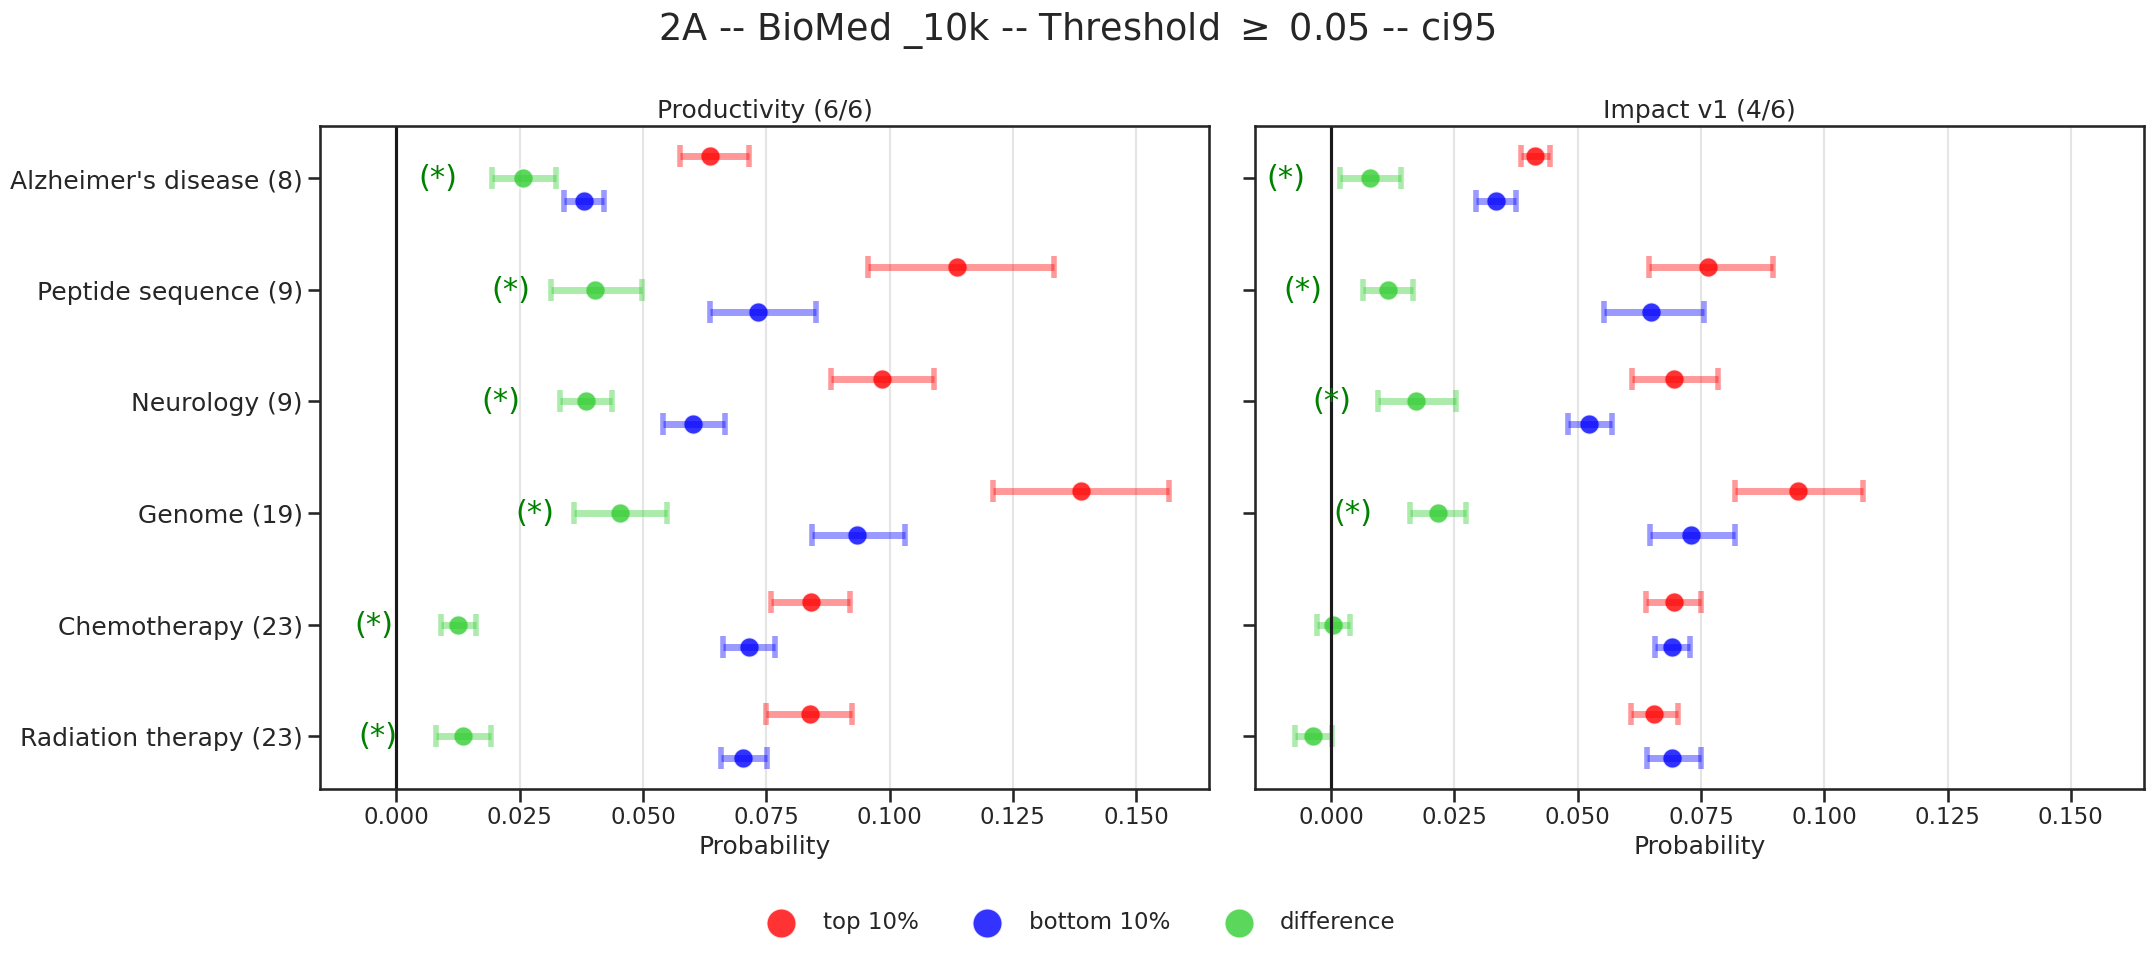

/tmp/ipykernel_30545/1139052847.py:104: UserWarning:

FixedFormatter should only be used together with FixedLocator



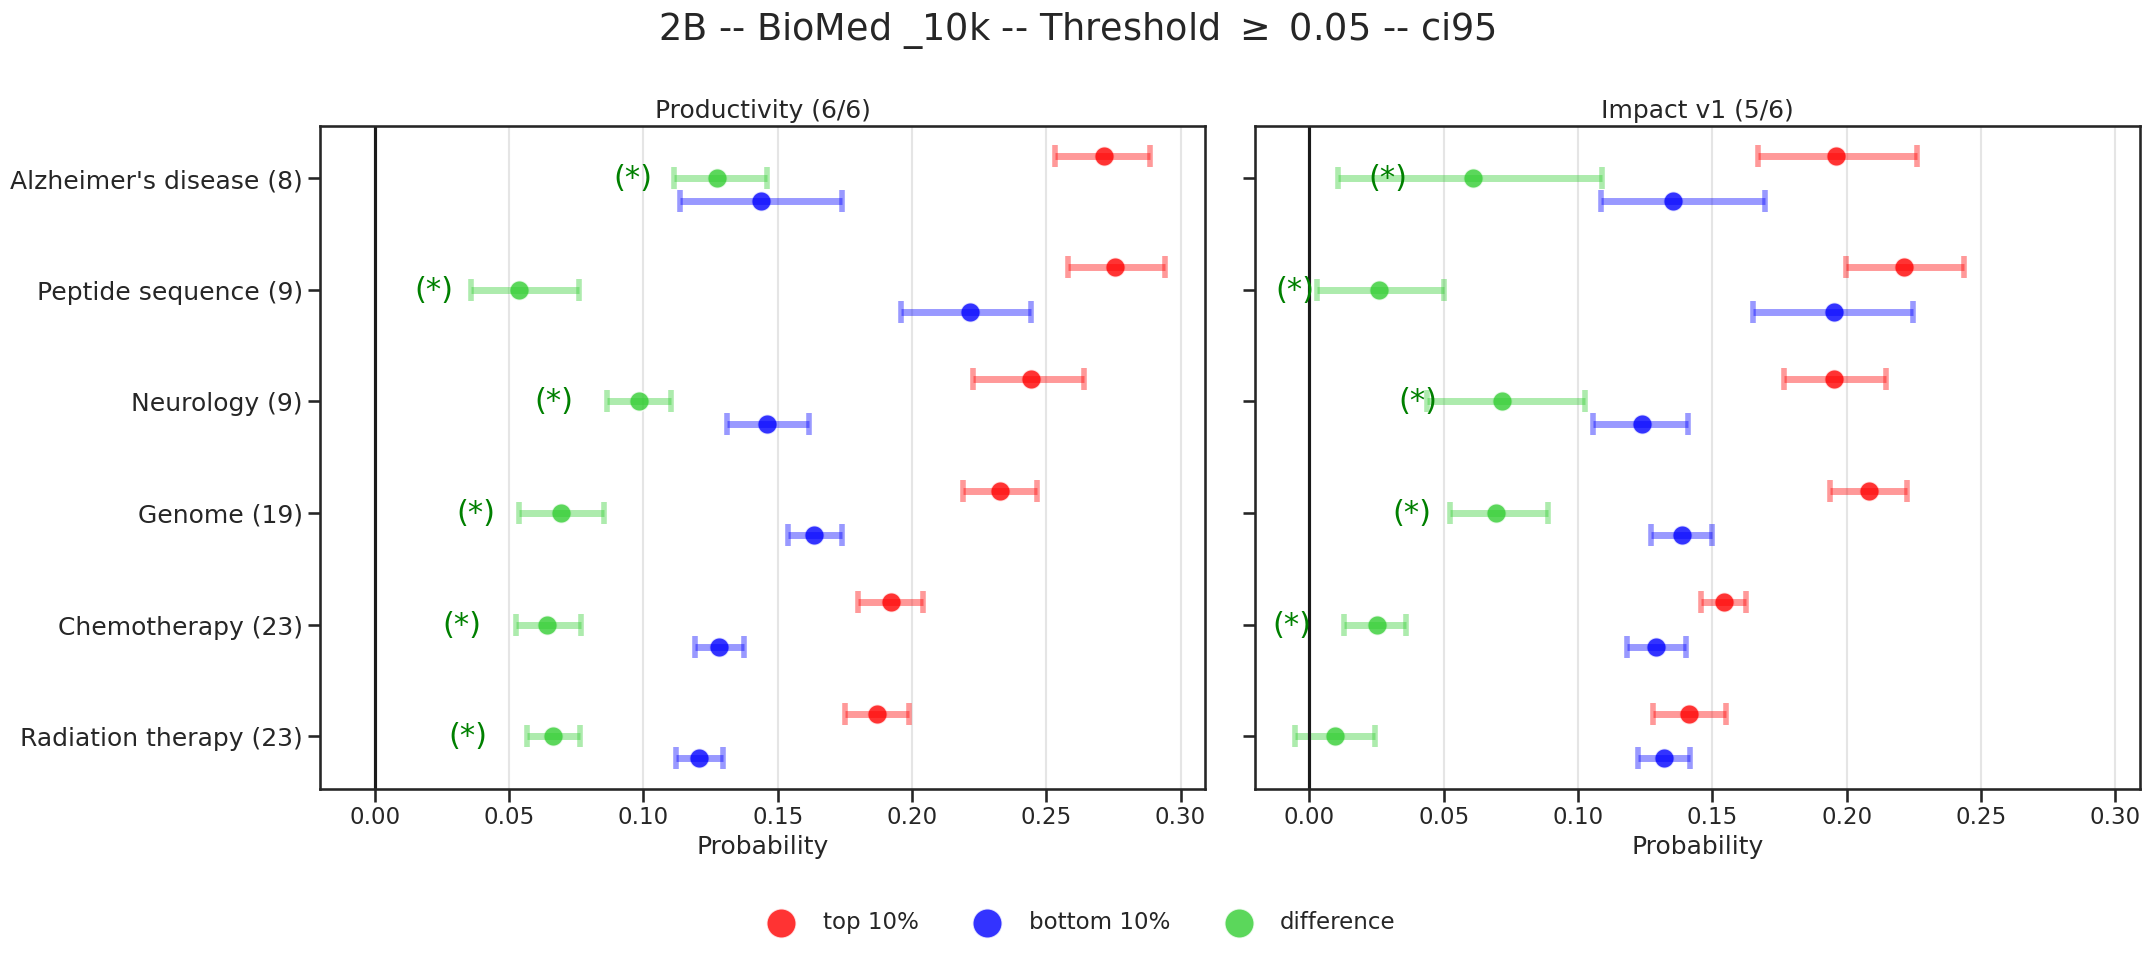

/tmp/ipykernel_30545/1139052847.py:104: UserWarning:

FixedFormatter should only be used together with FixedLocator



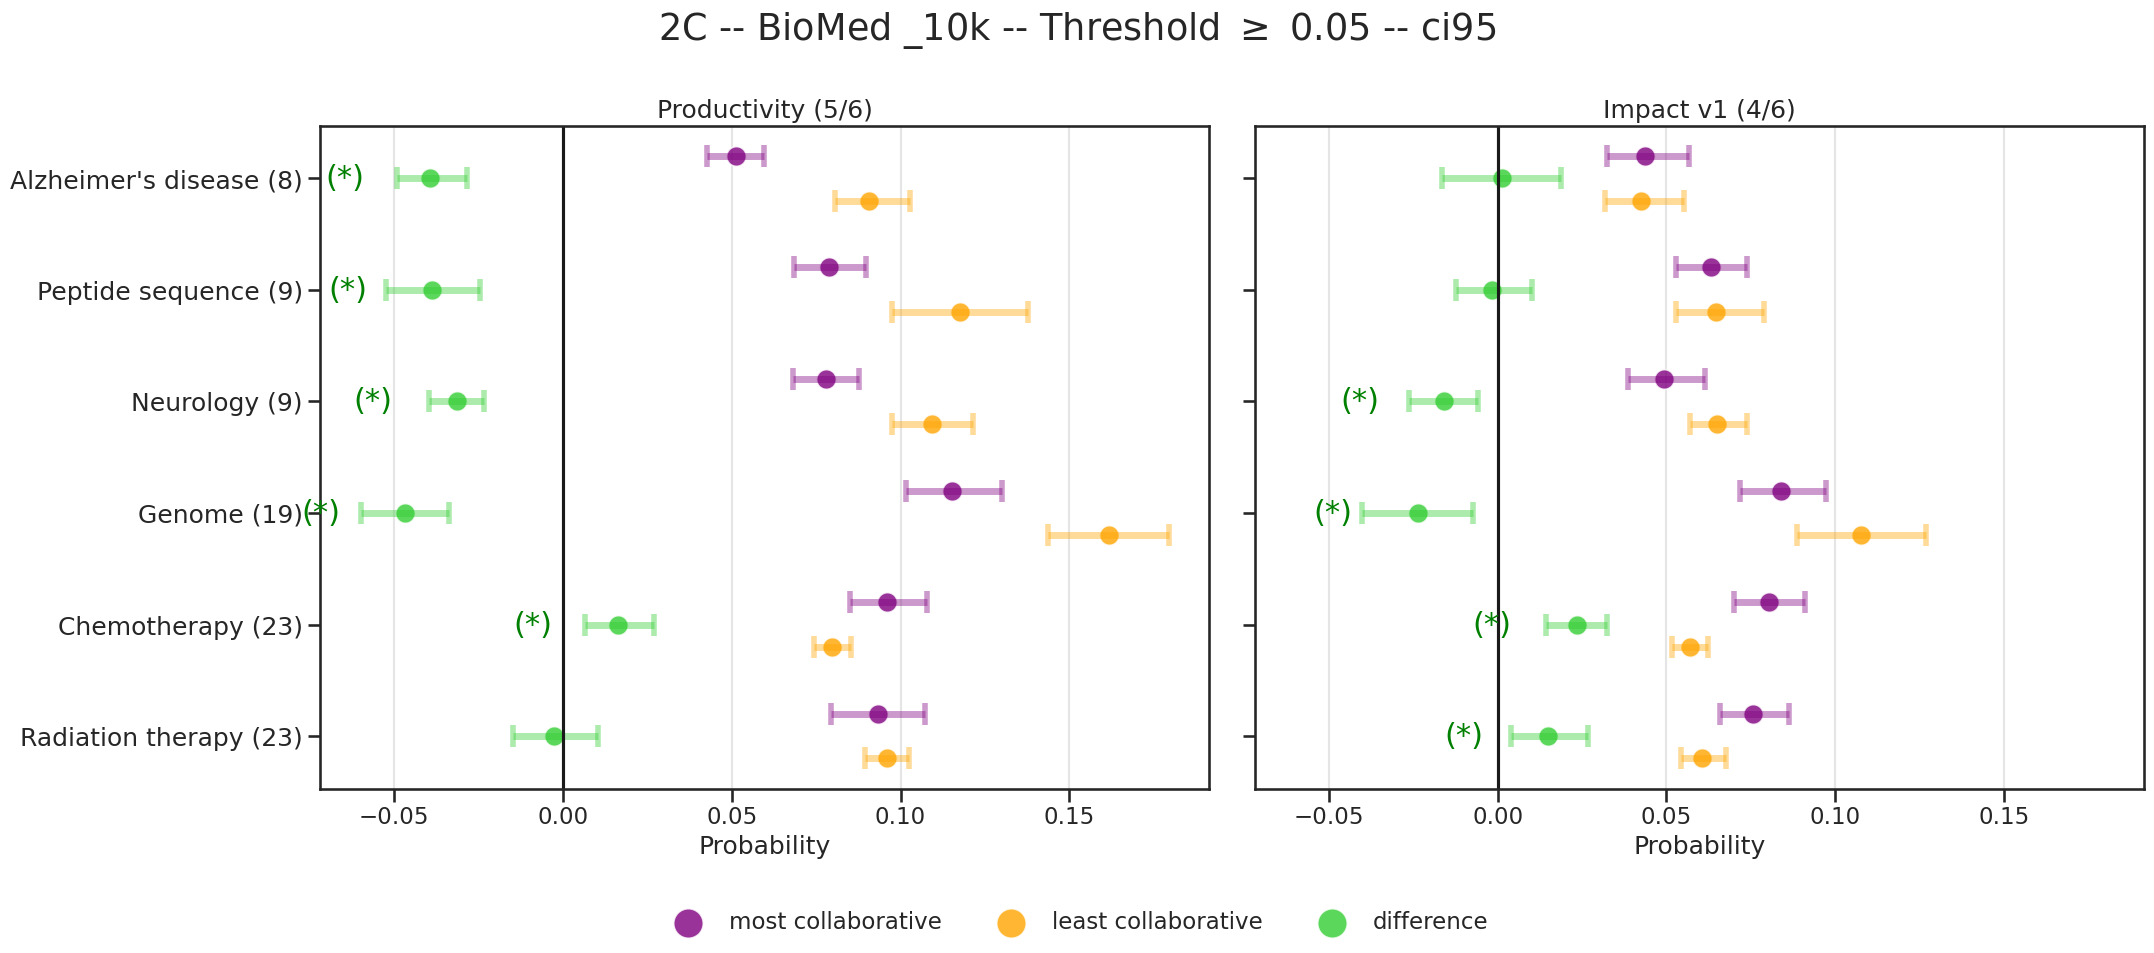

/tmp/ipykernel_30545/1139052847.py:104: UserWarning:

FixedFormatter should only be used together with FixedLocator



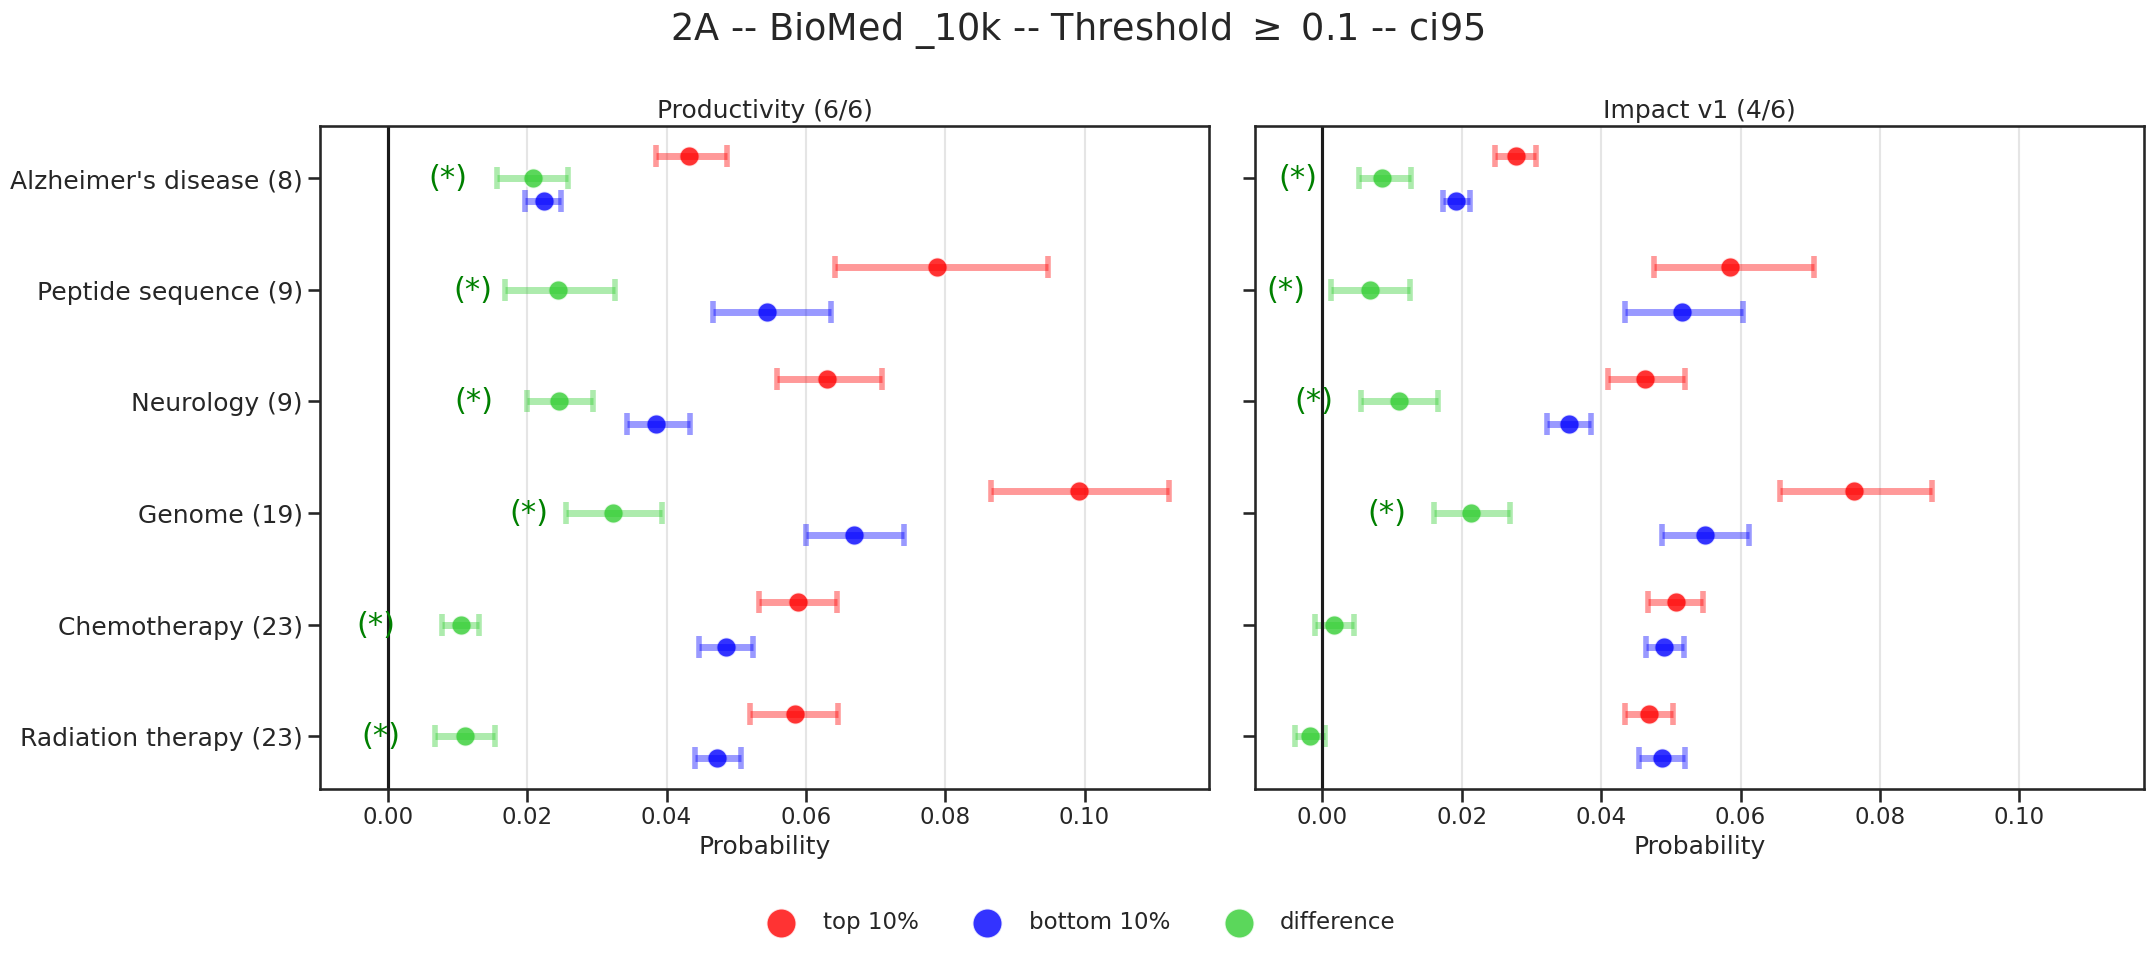

/tmp/ipykernel_30545/1139052847.py:104: UserWarning:

FixedFormatter should only be used together with FixedLocator



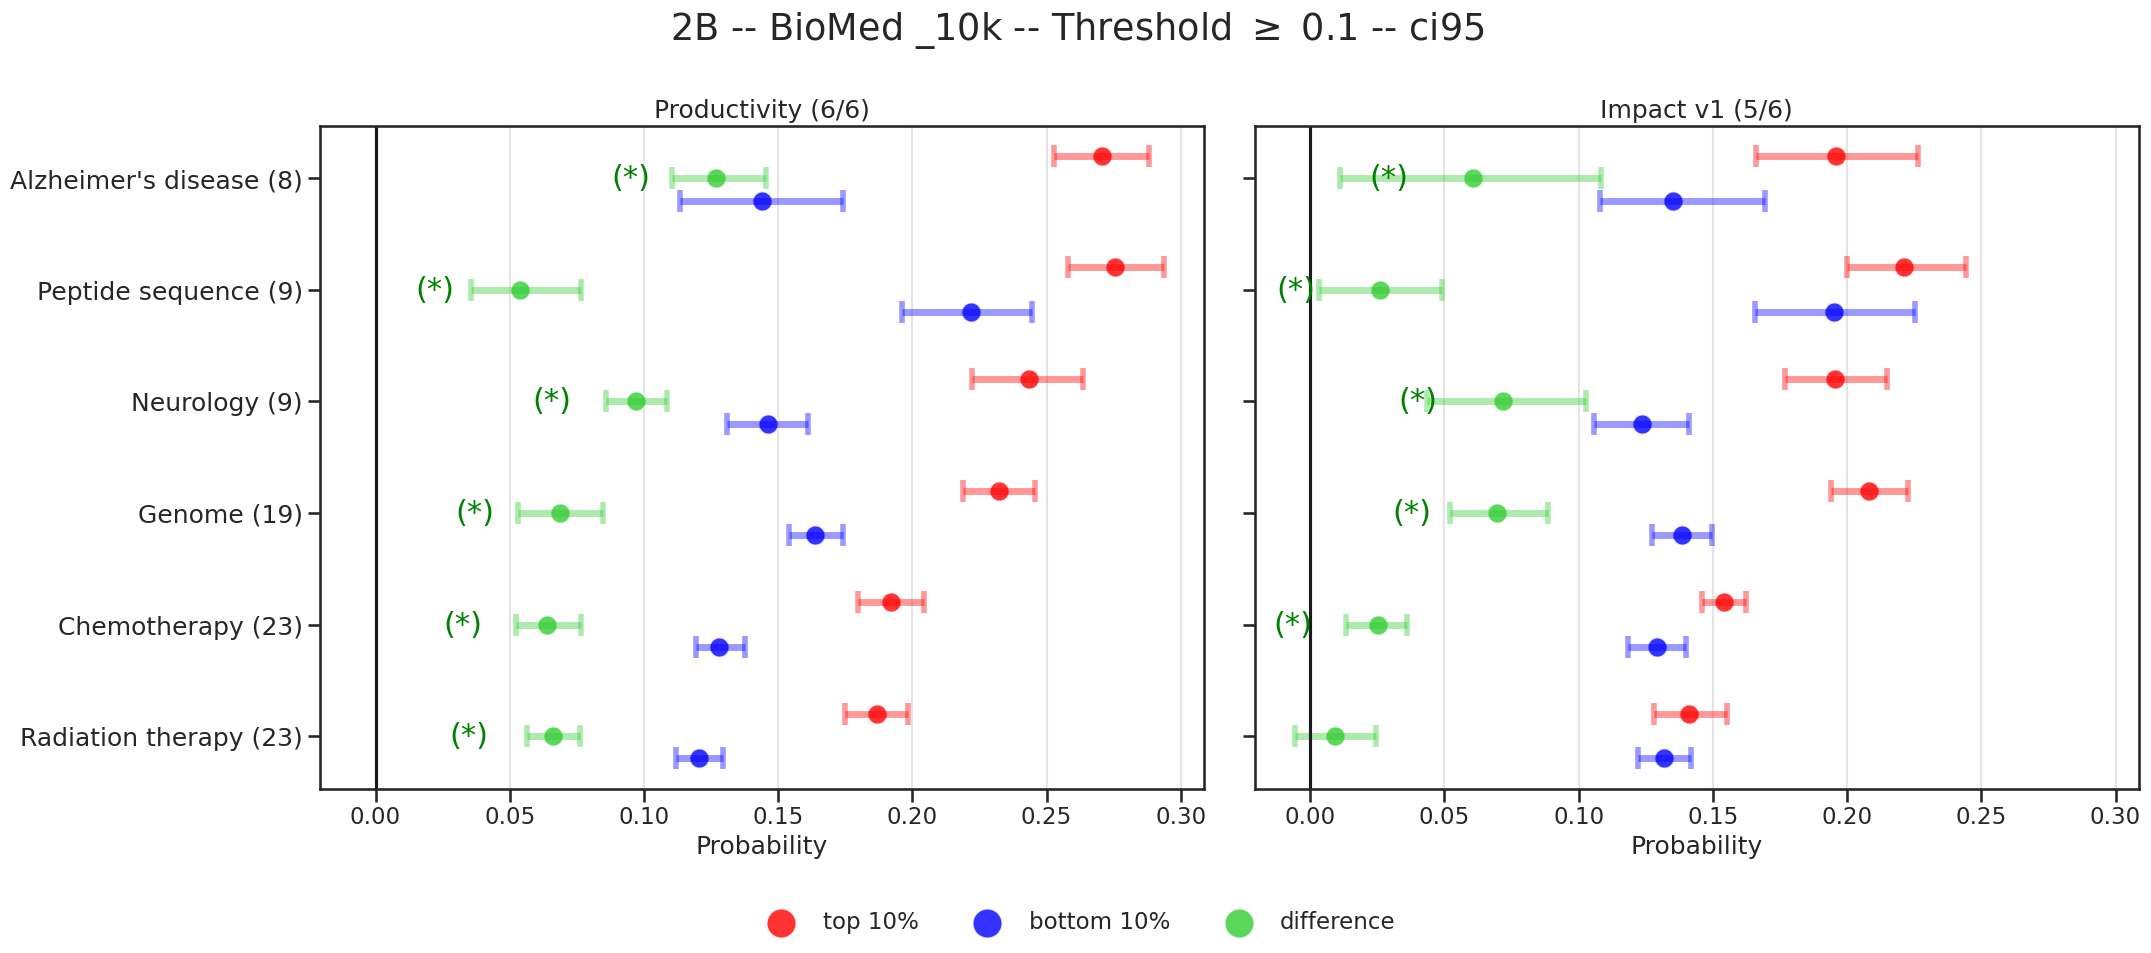

/tmp/ipykernel_30545/1139052847.py:104: UserWarning:

FixedFormatter should only be used together with FixedLocator



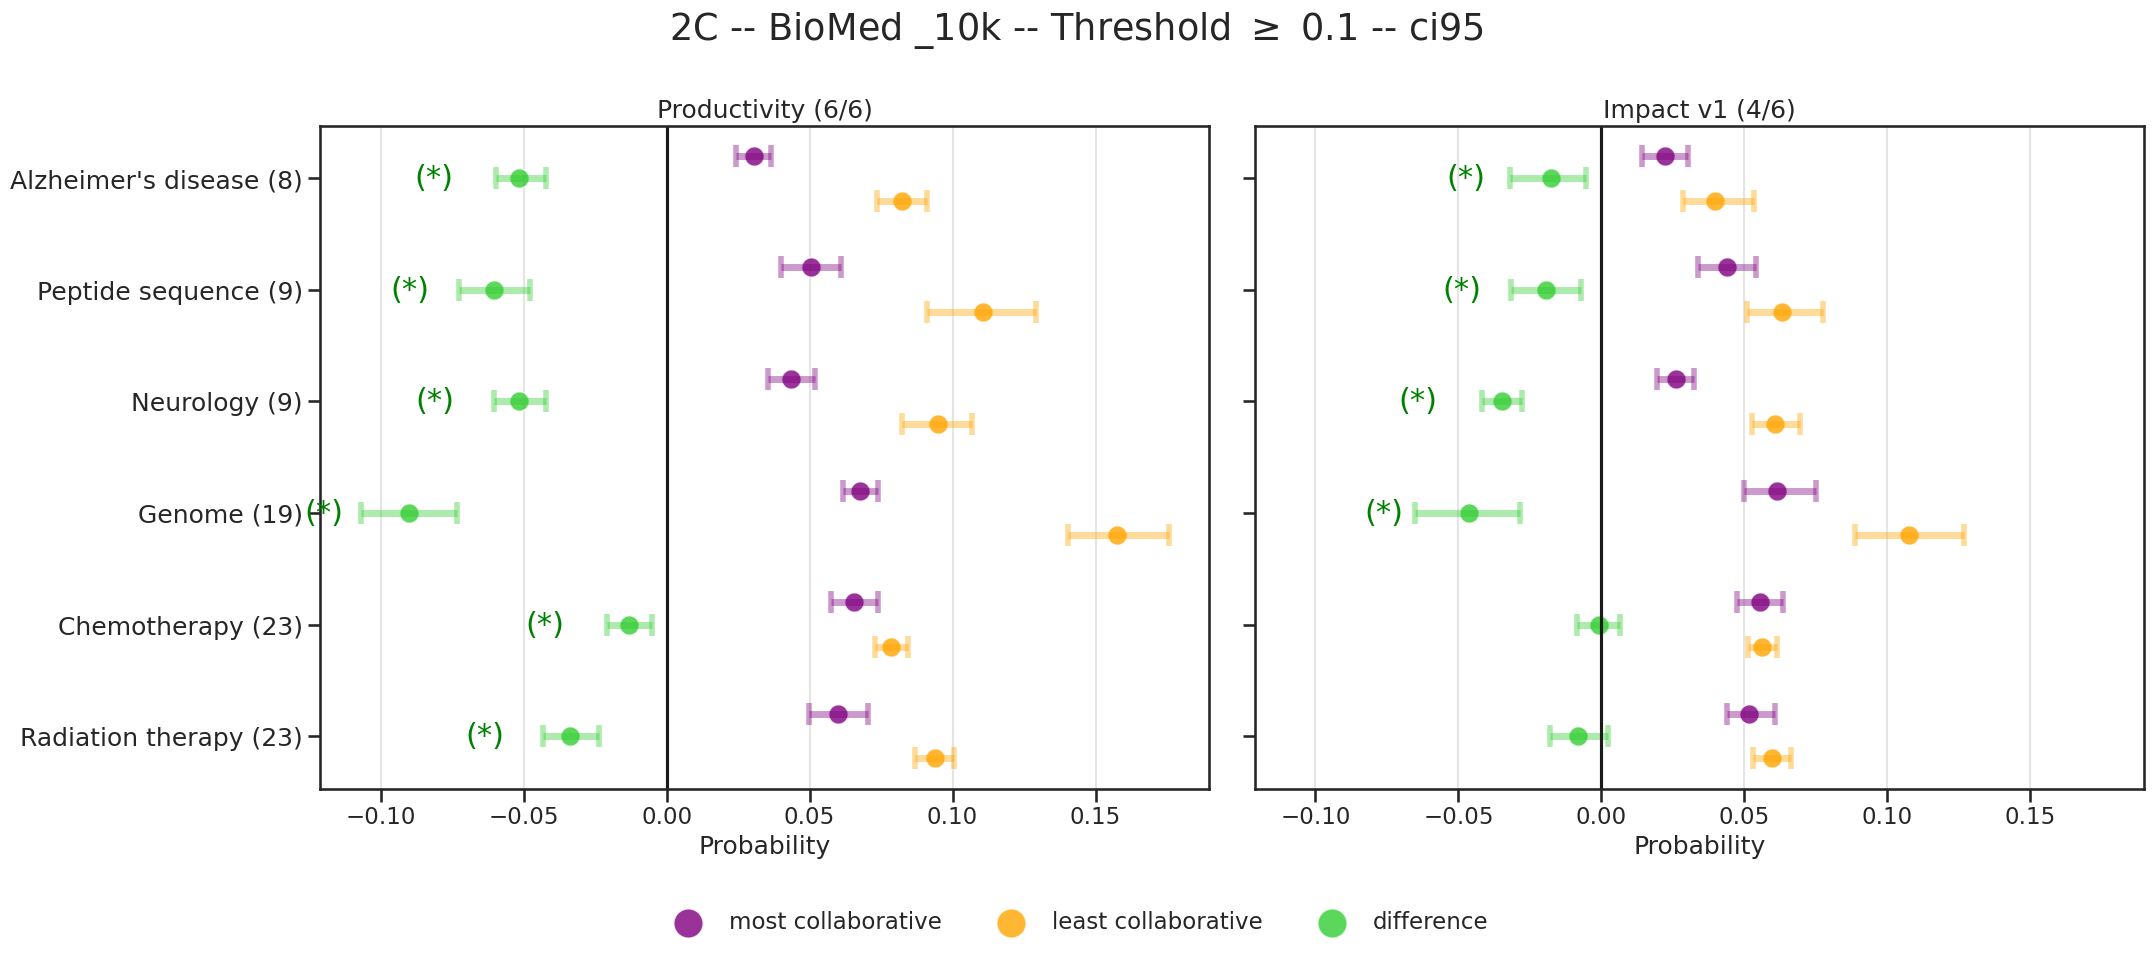

In [797]:
exp = 'Exp 2A'

# field = 'CS'
field = 'BioMed'
# field = 'Physics'
# suffix = '_10k'
suffix = ''

img_path = Path(f'./figures/{field}/Exp 2/')
img_path.mkdir(exist_ok=True, parents=True)
for errors in ('ci95', 'se')[: 1]:
    if errors == 'ci95':
        errorfunc = ('ci', 95)
    else: 
        errorfunc = errors

    just_diff = False 
    # just_diff = True


    # thresh = 0.05
    # thresh = 0.1
    for thresh in (0.05, 0.1):
        agg_df = (
            pd.read_csv(f'./csvs/aggregate/Mar-15/{field}/Exp 2/{thresh=}_{errors}{suffix}.csv')
            .query('threshold==@thresh')
            .sort_values(by='windows')
        )
        windows_dict = agg_df.set_index('topic').windows.to_dict()
        jit = 0.2
        for exp in ['2A', '2B', '2C']:
            color1, color2 = 'red', 'blue'
            color3 = 'limegreen'
            label1, label2 = 'top 10%', 'bottom 10%'
            label3 = 'difference'

            if exp == '2A':
                x1, x2 = 'Prod_highA_mean', 'Prod_lowA_mean'
                x3, x4 = 'Imp1_highA_mean', 'Imp1_lowA_mean'
                x5, x6 = 'Prod_diffA_mean', 'Imp1_diffA_mean'

            elif exp == '2B':
                x1, x2 = 'Prod_highB_mean', 'Prod_lowB_mean'
                x3, x4 = 'Imp1_highB_mean', 'Imp1_lowB_mean'
                x5, x6 = 'Prod_diffB_mean', 'Imp1_diffB_mean'

            elif exp == '2C':
                x1, x2 = 'Prod_more_coauthC_mean', 'Prod_less_coauthC_mean'
                x3, x4 = 'Imp1_more_coauthC_mean', 'Imp1_less_coauthC_mean'
                x5, x6 = 'Prod_diffC_mean', 'Imp1_diffC_mean'

                color1, color2 = 'purple', 'orange'
                label1, label2 = 'most collaborative', 'least collaborative'

            fig, axs = plt.subplots(figsize=(22, 9), ncols=2, sharey=True, layout='tight', sharex=True)

            # args = dict(join=False, scale=2, errorbar=None)
            args = dict(s=200, alpha=0.8, legend=False)

            if just_diff:
                img_path = f'./figures/{field}/Exp 2/{exp}_{thresh=}_{errors}_only_diff.png'
            else:
                img_path = f'./figures/{field}/Exp 2/{exp}_{thresh=}_{errors}.png'

            ### first panel productivity
            ax = axs[0]
            ax.set_title('Productivity');

            if not just_diff:
                sns.scatterplot(data=agg_df, x=x1, y='topic', ax=ax, color=color1, label=label1, **args);
                plot_error_bars(data=agg_df, ax=ax, x=x1, y='topic', ecolor=color1, errors=errors, jitter=jit)

                sns.scatterplot(data=agg_df, x=x2, y='topic', ax=ax, color=color2, label=label2, **args);
                plot_error_bars(data=agg_df, ax=ax, x=x2, y='topic', ecolor=color2, errors=errors, jitter=-jit)

            # add marks for the difference 
            sns.scatterplot(data=agg_df, x=x5, y='topic', ax=ax, color=color3, label=label3, **args);
            plot_error_bars(data=agg_df, ax=ax, x=x5, y='topic', ecolor=color3, errors='ci95', jitter=0, annot=True)


            #### second panel impact
            ax = axs[1]
            ax.set_title('Impact v1');

            if not just_diff:
                sns.scatterplot(data=agg_df, x=x3, y='topic', ax=ax, color=color1, **args);
                plot_error_bars(data=agg_df, ax=ax, x=x3, y='topic', ecolor=color1, errors=errors, jitter=jit)

                sns.scatterplot(data=agg_df, x=x4, y='topic', ax=ax, color=color2, **args);
                plot_error_bars(data=agg_df, ax=ax, x=x4, y='topic', ecolor=color2, errors=errors, jitter=-jit)

            sns.scatterplot(data=agg_df, x=x6, y='topic', ax=ax, color=color3, label=label3, **args);
            plot_error_bars(data=agg_df, ax=ax, x=x6, y='topic', ecolor=color3, errors='ci95', jitter=0, annot=True)


            for ax, diff_col in zip(axs, (x5, x6)):
                ax.grid(axis='x', alpha=0.5);
                ax.set_ylabel('');
                ax.set_xlabel('Probability');
                ax.axvline(x=0, color='k')  
                # ax.set_xlim(left=-0.3)            

            ## update yticks with number of windows 
            axs[0].set_yticklabels([f'{y.get_text()} ({windows_dict[y.get_text()]})' for y in axs[0].get_yticklabels()],
                                   fontsize=18)

            fig.suptitle(fr'{exp} -- {field} {suffix} -- Threshold $\geq$ {thresh} -- {errors}');

            handles1, labels1 = axs[0].get_legend_handles_labels()

            fig.legend(handles1, labels1, loc='lower center', ncols=4, 
                       markerscale=1.5, fancybox=False, frameon=False, title_fontsize=20,
                       bbox_to_anchor=(0.5, -0.07))   

            # fig.savefig(img_path, bbox_inches='tight')
            # plt.show()
            display(fig)
            plt.close('all')
            plt.close(fig)

            # break
            # fig.clf()

In [ ]:
np.linspace()

## Three experiments combined into one, two panel plot -> one for productivity, one for impact

/tmp/ipykernel_2992/468170447.py:69: UserWarning:

FixedFormatter should only be used together with FixedLocator



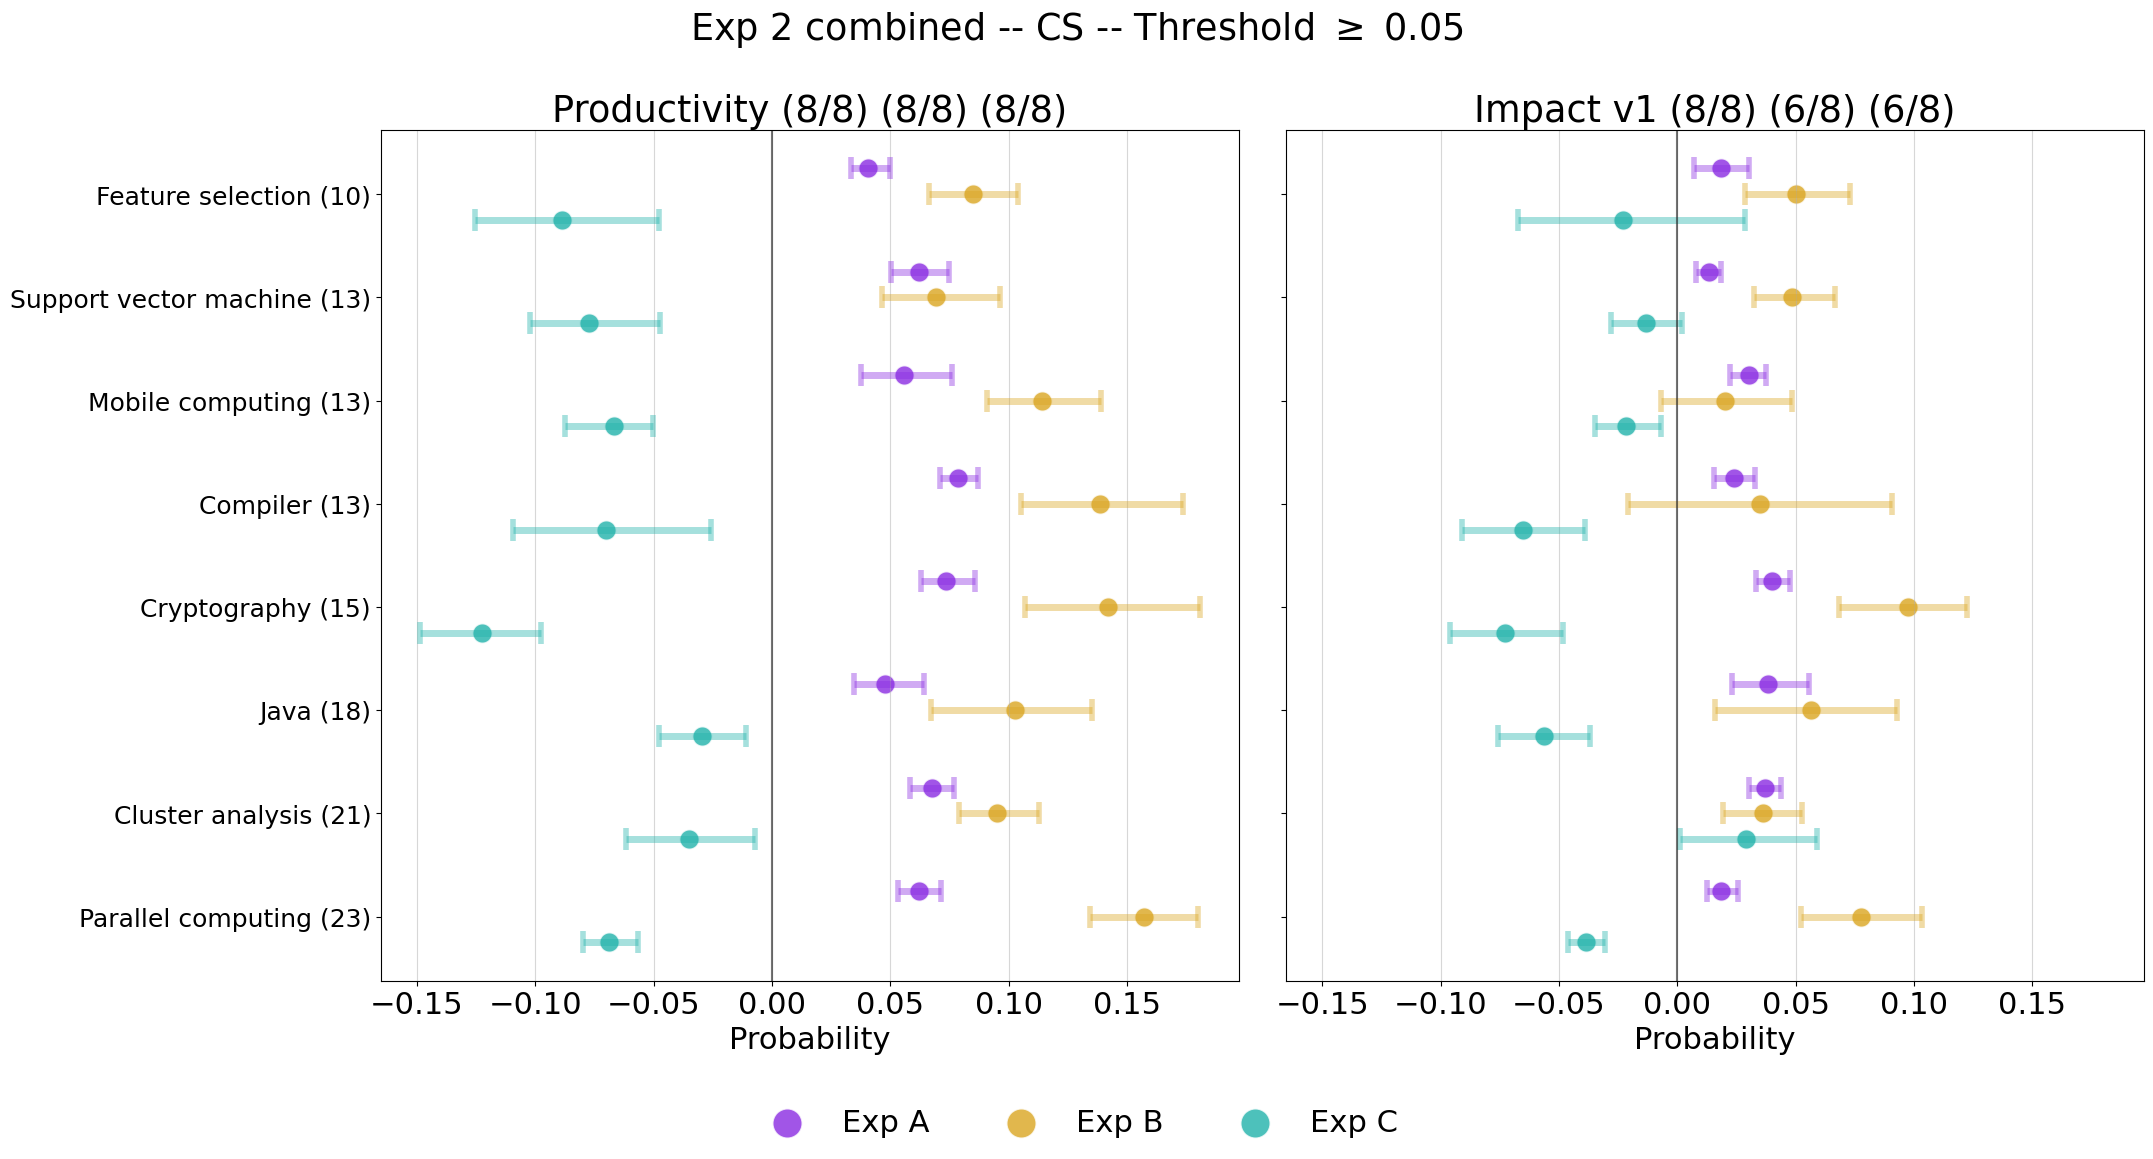

/tmp/ipykernel_2992/468170447.py:69: UserWarning:

FixedFormatter should only be used together with FixedLocator



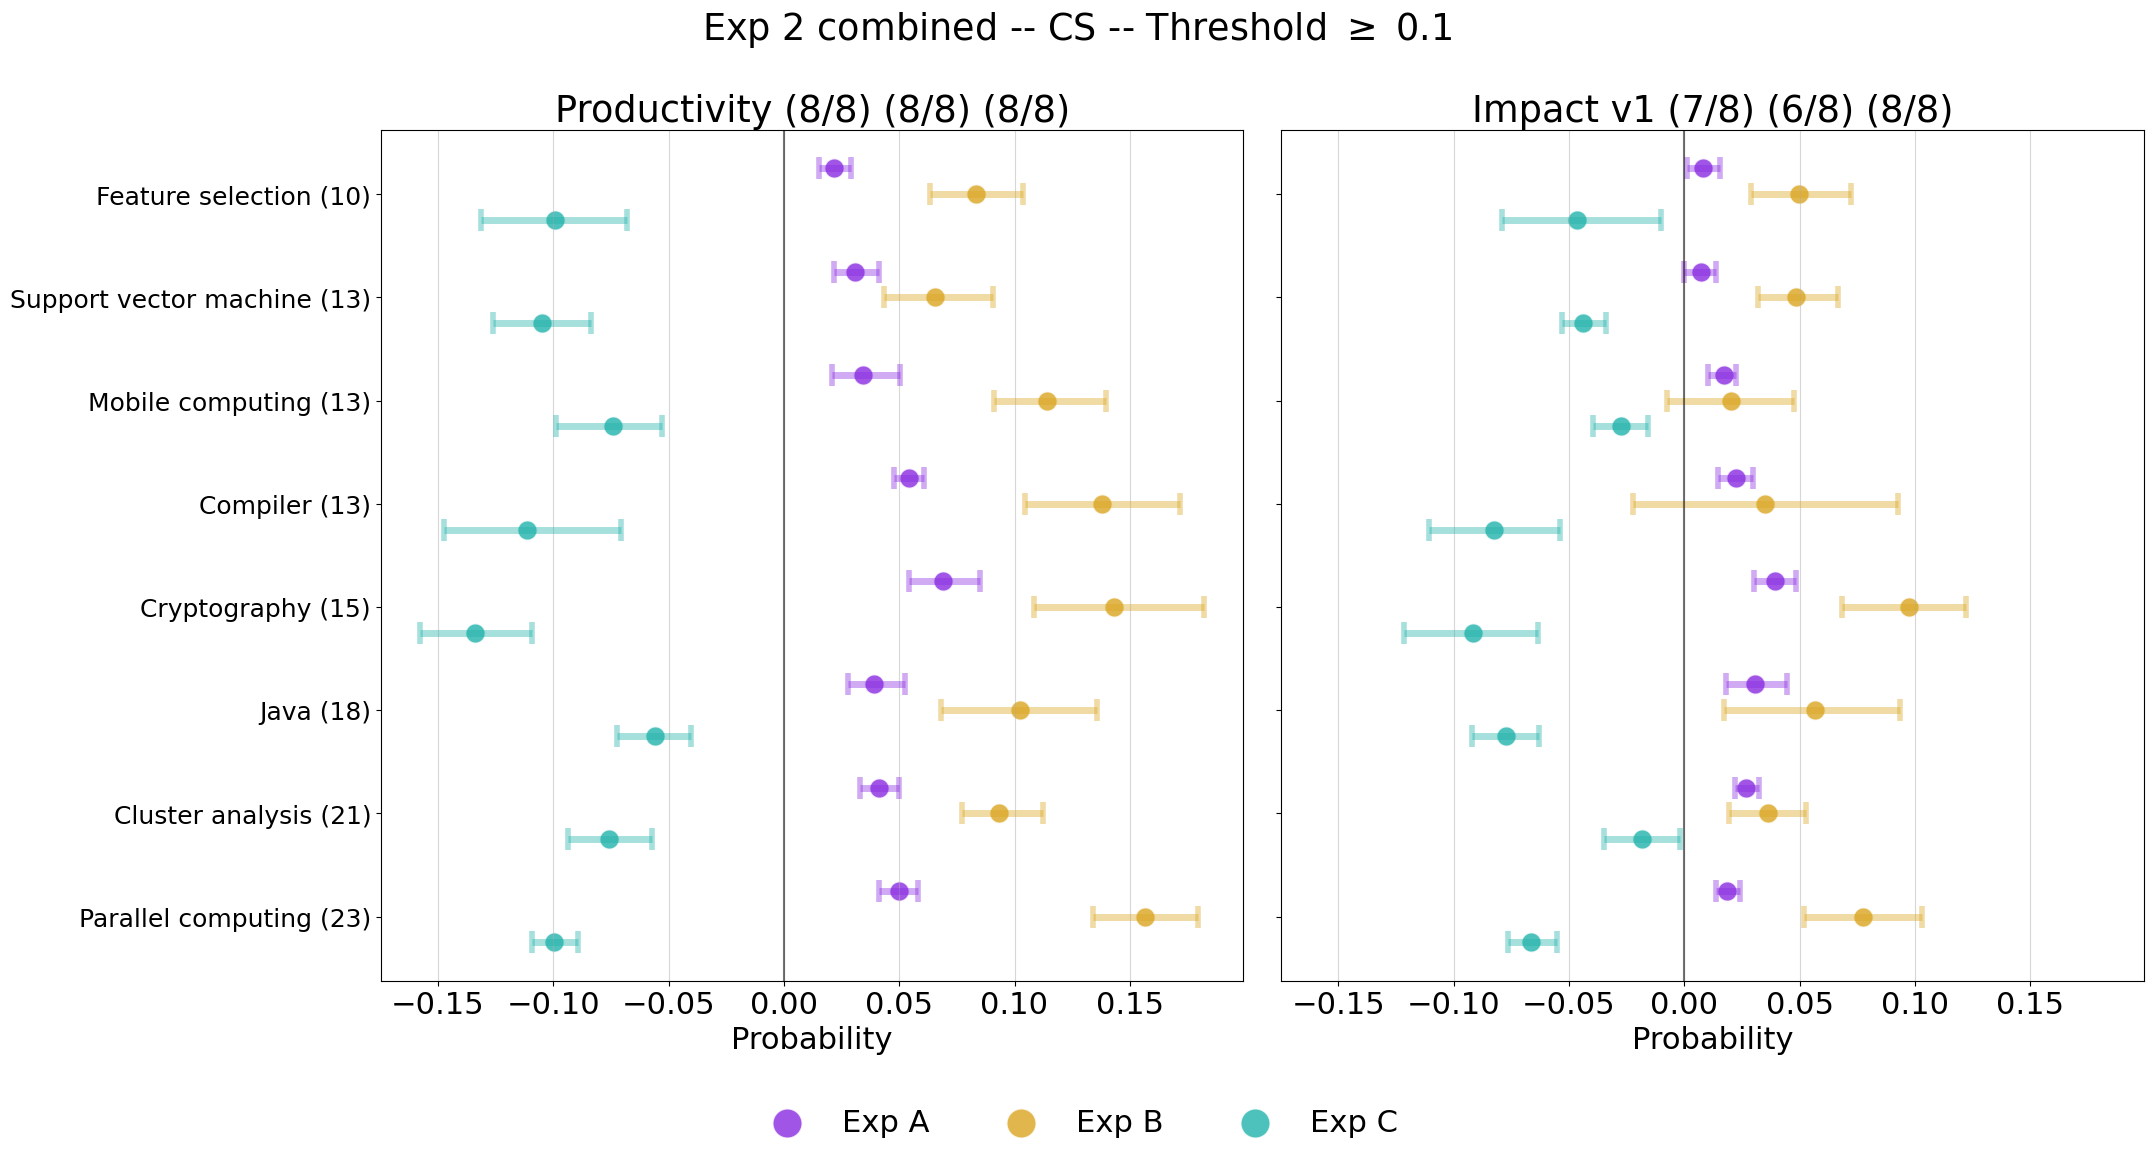

In [1301]:
exp = 'Exp 2A'

field = 'CS'
# field = 'BioMed'
# field = 'Physics'

img_path = Path(f'./figures/{field}/Exp 2/')
img_path.mkdir(exist_ok=True, parents=True)

annot = False

for thresh in (0.05, 0.1):
    agg_df = (
        pd.read_csv(f'./csvs/aggregate/{field}/Exp 2/{thresh=}_{errors}.csv')
        .query('threshold==@thresh')
        .sort_values(by='windows')
    )
    windows_dict = agg_df.set_index('topic').windows.to_dict()
    jit = 0.25

    x1, x2, x3 = 'Prod_diffA_mean', 'Prod_diffB_mean', 'Prod_diffC_mean'            
    x4, x5, x6 = 'Imp1_diffA_mean', 'Imp1_diffB_mean', 'Imp1_diffC_mean'

    label1, label2, label3 = 'Exp A', 'Exp B', 'Exp C'
    color1, color2, color3 = 'blueviolet', 'goldenrod', 'lightseagreen'

    fig, axs = plt.subplots(figsize=(22, 11), ncols=2, sharey=True, layout='tight', sharex=True)

    # args = dict(join=False, scale=2, errorbar=None)
    args = dict(s=200, alpha=0.8, legend=False)

    img_path = f'./figures/{field}/Exp 2/{thresh=}_combined.png'

    ### first panel productivity
    ax = axs[0]
    ax.set_title('Productivity');

    # add marks for the difference 
    sns.scatterplot(data=agg_df, x=x1, y='topic', ax=ax, color=color1, label=label1, **args);
    plot_error_bars(data=agg_df, ax=ax, x=x1, y='topic', ecolor=color1, errors='ci95', jitter=jit, annot=annot)

    sns.scatterplot(data=agg_df, x=x2, y='topic', ax=ax, color=color2, label=label2, **args);
    plot_error_bars(data=agg_df, ax=ax, x=x2, y='topic', ecolor=color2, errors='ci95', jitter=0, annot=annot)

    sns.scatterplot(data=agg_df, x=x3, y='topic', ax=ax, color=color3, label=label3, **args);
    plot_error_bars(data=agg_df, ax=ax, x=x3, y='topic', ecolor=color3, errors='ci95', jitter=-jit, annot=annot)

    #### second panel impact
    ax = axs[1]
    ax.set_title('Impact v1');

    sns.scatterplot(data=agg_df, x=x4, y='topic', ax=ax, color=color1, label=label1, **args);
    plot_error_bars(data=agg_df, ax=ax, x=x4, y='topic', ecolor=color1, errors='ci95', jitter=jit, annot=annot)

    sns.scatterplot(data=agg_df, x=x5, y='topic', ax=ax, color=color2, label=label2, **args);
    plot_error_bars(data=agg_df, ax=ax, x=x5, y='topic', ecolor=color2, errors='ci95', jitter=0, annot=annot)

    sns.scatterplot(data=agg_df, x=x6, y='topic', ax=ax, color=color3, label=label3, **args);
    plot_error_bars(data=agg_df, ax=ax, x=x6, y='topic', ecolor=color3, errors='ci95', jitter=-jit, annot=annot)

    for ax in axs:
        ax.grid(axis='x', alpha=0.5);
        ax.set_ylabel('');
        ax.set_xlabel('Probability');
        ax.axvline(x=0, color='k', alpha=0.6)  
        # ax.set_xlim(left=-0.3)            

    ## update yticks with number of windows 
    axs[0].set_yticklabels([f'{y.get_text()} ({windows_dict[y.get_text()]})' for y in axs[0].get_yticklabels()],
                           fontsize=18)

    fig.suptitle(fr'Exp 2 combined -- {field} -- Threshold $\geq$ {thresh}');

    handles1, labels1 = axs[0].get_legend_handles_labels()

    fig.legend(handles1, labels1, loc='lower center', ncols=4, 
               markerscale=1.5, fancybox=False, frameon=False, title_fontsize=20,
               bbox_to_anchor=(0.5, -0.07))   

    fig.savefig(img_path, bbox_inches='tight')
    # plt.show()
    display(fig)
    plt.close('all')
    plt.close(fig)

    # break
    # fig.clf()

In [1096]:
dots = ax.collections[-1]
offsets = dots.get_offsets()
display(offsets.shape)

(8, 2)

In [1100]:
offsets + [0, 0.5]

masked_array(
  data=[[-0.1413948548464677, 0.5],
        [-0.1692828682499337, 1.5],
        [-0.0995502952181784, 2.5],
        [-0.0593203251054143, 3.5],
        [-0.1349440489962767, 4.5],
        [-0.0349243949685766, 5.5],
        [-0.0566226819392951, 6.5],
        [-0.0976042848488168, 7.5]],
  mask=[[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]],
  fill_value=1e+20)

In [1302]:
%%bash
rm -rf figures.zip 
zip -r figures.zip figures

  adding: figures/ (stored 0%)
  adding: figures/Physics/ (stored 0%)
  adding: figures/Physics/Exp 1/ (stored 0%)
  adding: figures/Physics/Exp 1/Gravitational wave_ci95.png (deflated 7%)
  adding: figures/Physics/Exp 1/Supersymmetry_ci95.png (deflated 7%)
  adding: figures/Physics/Exp 1/Fluid dynamics_ci95.png (deflated 7%)
  adding: figures/Physics/Exp 1/Dark matter_se.png (deflated 7%)
  adding: figures/Physics/Exp 1/Superconductivity_ci95.png (deflated 7%)
  adding: figures/Physics/Exp 1/Superconductivity_se.png (deflated 7%)
  adding: figures/Physics/Exp 1/Statistical physics_ci95.png (deflated 7%)
  adding: figures/Physics/Exp 1/Supersymmetry_se.png (deflated 7%)
  adding: figures/Physics/Exp 1/Magnetoresistance_ci95.png (deflated 7%)
  adding: figures/Physics/Exp 1/Dark matter_ci95.png (deflated 7%)
  adding: figures/Physics/Exp 1/Soliton_ci95.png (deflated 7%)
  adding: figures/Physics/Exp 1/Soliton_se.png (deflated 7%)
  adding: figures/Physics/Exp 1/Gravitational wave_se.png

In [835]:
agg_df[['topic', 'Prod_more_coauthC_mean']]

,topic,Prod_more_coauthC_mean
8,Feature selection,0.074726
0,Support vector machine,0.082052
4,Mobile computing,0.082052
7,Compiler,0.082052
2,Cryptography,0.084552
5,Java,0.087211
3,Cluster analysis,0.086471
1,Parallel computing,0.086394
6,Operating system,0.086394


## Difference of groups 
Check if 0 is contained in the 95% CI of the difference between the 2 groups

In [8]:
field = 'CS'
thresh = 0.05
errors = 'ci95'
agg_df = (
        pd.read_csv(f'./csvs/aggregate/{field}/Exp 2/{thresh=}_{errors}.csv')
        .query('threshold==@thresh')
        .sort_values(by='windows')
)
agg_df

,topic,windows,threshold,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
7,Feature selection,10,0.05,0.138658,0.122260,0.157162,0.098105,0.084500,0.116288,0.255940,...,0.122245,0.018629,0.007443,0.030312,0.050141,0.028761,0.074313,-0.022984,-0.067931,0.027885
0,Support vector machine,13,0.05,0.197247,0.161706,0.239356,0.134959,0.108284,0.167364,0.237073,...,0.118195,0.013428,0.007990,0.018655,0.048551,0.032325,0.066569,-0.013317,-0.027926,0.002085
4,Mobile computing,13,0.05,0.122819,0.093434,0.153830,0.067068,0.051128,0.084456,0.268885,...,0.073406,0.030143,0.021834,0.037253,0.020310,-0.006690,0.047527,-0.021506,-0.034981,-0.007215
6,Compiler,13,0.05,0.140157,0.127673,0.152206,0.061540,0.054749,0.068021,0.331711,...,0.133857,0.024037,0.015534,0.032837,0.035004,-0.024591,0.090691,-0.065211,-0.090838,-0.039167
2,Cryptography,15,0.05,0.169841,0.145518,0.196818,0.096138,0.078240,0.116048,0.327084,...,0.153228,0.040024,0.033211,0.047569,0.097349,0.068704,0.122209,-0.072842,-0.095924,-0.048925
5,Java,18,0.05,0.118095,0.097236,0.143761,0.070328,0.059305,0.082966,0.252129,...,0.133763,0.038304,0.023401,0.054853,0.056557,0.015902,0.093782,-0.056112,-0.075782,-0.036775
3,Cluster analysis,21,0.05,0.203442,0.182329,0.225703,0.135842,0.122135,0.150340,0.263908,...,0.113017,0.037246,0.030578,0.043827,0.036437,0.018796,0.053269,0.029114,0.001616,0.058509
1,Parallel computing,23,0.05,0.155030,0.141570,0.167714,0.092934,0.085247,0.100749,0.343627,...,0.117088,0.018681,0.012599,0.025439,0.077489,0.052396,0.103547,-0.038364,-0.046068,-0.030630


In [11]:
(
    agg_df[['topic', 'threshold', 'Imp1_highA_mean', 'Imp1_lowA_mean', 'Imp1_diffA_mean']]
    .assign(diff=lambda df_: df_.Imp1_highA_mean - df_.Imp1_lowA_mean)
)

,topic,threshold,Imp1_highA_mean,Imp1_lowA_mean,Imp1_diffA_mean,diff
7,Feature selection,0.05,0.105251,0.086621,0.018629,0.018629
0,Support vector machine,0.05,0.140015,0.126587,0.013428,0.013428
4,Mobile computing,0.05,0.089571,0.059428,0.030143,0.030143
6,Compiler,0.05,0.076066,0.052028,0.024037,0.024037
2,Cryptography,0.05,0.129105,0.089081,0.040024,0.040024
5,Java,0.05,0.099534,0.061230,0.038304,0.038304
3,Cluster analysis,0.05,0.165098,0.127852,0.037246,0.037246
1,Parallel computing,0.05,0.103312,0.084631,0.018681,0.018681


In [1198]:
df = (
    agg_df[['topic', 'threshold', 'Prod_diffA_mean', 'Prod_diffA_mean_ci95_min', 'Prod_diffA_mean_ci95_max']]
    .assign(prod=lambda df_: df_.Prod_diffA_mean_ci95_min*df_.Prod_diffA_mean_ci95_max)
)
df

,topic,threshold,Prod_diffA_mean,Prod_diffA_mean_ci95_min,Prod_diffA_mean_ci95_max,prod
5,Gravitational wave,0.1,0.008377,-0.003645,0.021116,-0.000077
4,Dark matter,0.1,0.056422,0.044644,0.068794,0.003071
6,Fluid dynamics,0.1,0.033723,0.027456,0.039720,0.001091
3,Soliton,0.1,0.037406,0.030950,0.044084,0.001364
7,Supersymmetry,0.1,0.059755,0.044534,0.074342,0.003311
1,Magnetoresistance,0.1,0.009980,0.005778,0.015897,0.000092
0,Superconductivity,0.1,0.004457,0.002465,0.006550,0.000016
2,Statistical physics,0.1,0.056016,0.051514,0.061590,0.003173


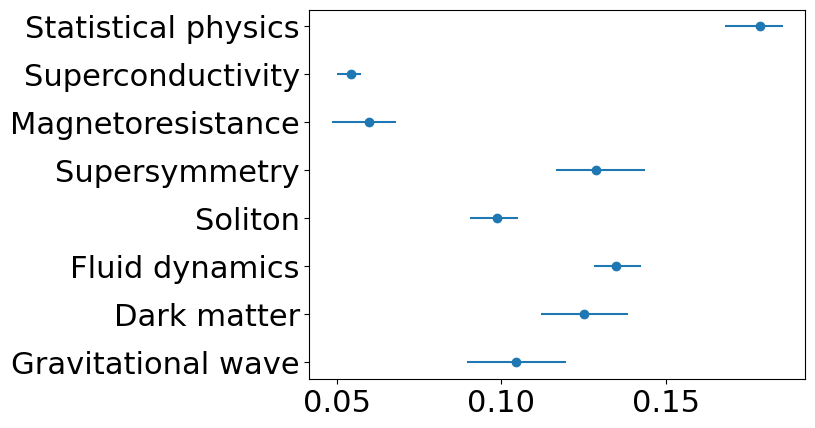

In [1173]:
# plt.errorbar(df.Prod_diffA_mean, df.topic, fmt='o', xerr=[df.Prod_diffA_mean - df.Prod_diffA_mean_ci95_min, df.Prod_diffA_mean_ci95_max-df.Prod_diffA_mean])
plt.errorbar(df.Prod_highA_mean, df.topic, fmt='o', xerr=[df.Prod_highA_mean - df.Prod_highA_mean_ci95_min, df.Prod_diffA_mean_ci95_max-df.Prod_diffA_mean])
plt.show()

## double check numbers

In [13]:
field = 'CS'
metric = 'Productivity'
# metric = 'Impact_mean1'
exp = 'EXP2'
errors = 'se'
thresh = 0.05
sara_df = pd.read_csv(basepath / field / metric / exp / f'df_topic_stat_{thresh}.csv', index_col=0)
agg_df = pd.read_csv(f'./csvs/aggregate/{field}/Exp 2/{thresh=}_{errors}.csv').sort_values(by='windows')

display(sara_df.head())
display(agg_df.head())

,topic,Perc,high1_A_mean,high1_A_sterr,low1_A_mean,low1_A_sterr,high1_bin1_A_mean,high1_bin1_A_sterr,high1_bin2_A_mean,high1_bin2_A_sterr,...,low1_A_num_mean,low1_A_num_sterr,high1_bin1_A_num_mean,high1_bin1_A_num_sterr,high1_bin2_A_num_mean,high1_bin2_A_num_sterr,high1_B_num_mean,high1_B_num_sterr,low1_B_num_mean,low1_B_num_sterr
0,Support vector machine,0.05,0.197247,0.020597,0.134959,0.015679,0.110631,0.013980,0.187883,0.007367,...,147.538462,17.500409,22.769231,3.637684,43.538462,6.984062,175.230769,21.379703,33.076923,3.416516
1,Cluster analysis,0.05,0.203442,0.011221,0.135842,0.007396,0.114094,0.010994,0.149387,0.007373,...,169.476190,23.578604,26.238095,3.983839,39.809524,7.591543,189.285714,26.788247,37.666667,5.262325
2,Feature selection,0.05,0.138658,0.009481,0.098105,0.008692,0.091261,0.010587,0.180121,0.012813,...,73.100000,6.515708,10.500000,1.500000,22.400000,3.099104,93.700000,8.213877,20.300000,1.732372
3,Parallel computing,0.05,0.155030,0.006856,0.092934,0.004079,0.081720,0.004580,0.150396,0.005512,...,123.217391,11.696247,20.565217,1.528163,39.304348,3.471758,206.086957,10.862219,30.434783,3.061831
4,Cryptography,0.05,0.169841,0.013511,0.096138,0.010029,0.070204,0.010370,0.192884,0.016113,...,48.200000,4.371117,5.466667,0.668094,17.333333,2.401719,73.133333,7.183226,14.200000,1.615992


,topic,windows,threshold,Prod_highA_mean,Prod_highA_mean_se_min,Prod_highA_mean_se_max,Prod_lowA_mean,Prod_lowA_mean_se_min,Prod_lowA_mean_se_max,Prod_highB_mean,...,Imp1_less_coauthC_mean_se_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
7,Feature selection,10,0.05,0.138658,0.129177,0.148138,0.098105,0.089413,0.106798,0.255940,...,0.113588,0.018629,0.007024,0.030187,0.050141,0.028790,0.073133,-0.022984,-0.067449,0.028577
0,Support vector machine,13,0.05,0.197247,0.176650,0.217844,0.134959,0.119280,0.150638,0.237073,...,0.110940,0.013428,0.007963,0.018659,0.048551,0.032250,0.066792,-0.013317,-0.027804,0.001952
4,Mobile computing,13,0.05,0.122819,0.106550,0.139089,0.067068,0.058143,0.075992,0.268885,...,0.067456,0.030143,0.022137,0.037416,0.020310,-0.006887,0.048344,-0.021506,-0.034816,-0.007043
6,Compiler,13,0.05,0.140157,0.133516,0.146799,0.061540,0.058017,0.065062,0.331711,...,0.121470,0.024037,0.015522,0.032883,0.035004,-0.021007,0.090579,-0.065211,-0.091040,-0.038940
2,Cryptography,15,0.05,0.169841,0.156330,0.183352,0.096138,0.086110,0.106167,0.327084,...,0.143495,0.040024,0.033154,0.047542,0.097349,0.068415,0.122301,-0.072842,-0.095932,-0.048299


In [15]:
same_cols = ['topic', 'windows', 'threshold', 'high1_A_mean', 'Prod_highA_mean', 'low1_A_mean', 'Prod_lowA_mean',
             'Prod_highB_mean', 'high1_B_mean']
(
    agg_df.merge(
        sara_df,
        on='topic',
    )
    [same_cols]
)

,topic,windows,threshold,high1_A_mean,Prod_highA_mean,low1_A_mean,Prod_lowA_mean,Prod_highB_mean,high1_B_mean
0,Feature selection,10,0.05,0.138658,0.138658,0.098105,0.098105,0.255940,0.255940
1,Support vector machine,13,0.05,0.197247,0.197247,0.134959,0.134959,0.237073,0.237073
2,Mobile computing,13,0.05,0.122819,0.122819,0.067068,0.067068,0.268885,0.268885
3,Compiler,13,0.05,0.140157,0.140157,0.061540,0.061540,0.331711,0.331711
4,Cryptography,15,0.05,0.169841,0.169841,0.096138,0.096138,0.327084,0.327084
5,Java,18,0.05,0.118095,0.118095,0.070328,0.070328,0.252129,0.252129
6,Cluster analysis,21,0.05,0.203442,0.203442,0.135842,0.135842,0.263908,0.263908
7,Parallel computing,23,0.05,0.155030,0.155030,0.092934,0.092934,0.343627,0.343627


# tikz codes

In [38]:
topic_orders = {'Physics': ['Gravitational wave', 'Dark matter', 'Fluid dynamics', 'Soliton', 'Supersymmetry', 'Statistical physics', 'Superconductivity'],
                'CS': ['Compiler', 'Mobile computing', 'Cryptography', 'Cluster analysis', 'Image processing', 'Parallel computing'],
                'BioMed': ['Protein structure', 'Genome', 'Peptide sequence', "Alzheimer's disease", 'Neurology', 'Chemotherapy', 
                           'Radiation therapy']}

In [65]:
print(','.join(reversed(topic_orders['BioMed'])))

Radiation therapy,Chemotherapy,Neurology,Alzheimer's disease,Peptide sequence,Genome,Protein structure


In [37]:
# figure out the order of topics 
# field = 'CS'
for field in 'Physics', 'CS', 'BioMed':
    thresh = 0.05
    errors = 'ci95'

    files = list(Path(f'./csvs/aggregate/Mar-15/{field}/Exp 2/').glob(f'*{thresh}_{errors}*.csv'))

    windows_df = (
        pd.concat([pd.read_csv(f, usecols=['topic', 'windows']) for f in files])
        .sort_values(by='windows')
    )
    display(field, windows_df)
    display(windows_df.topic.tolist())

'Physics'

,topic,windows
6,Gravitational wave,10
2,Dark matter,13
5,Fluid dynamics,16
4,Soliton,18
0,Supersymmetry,20
1,Statistical physics,23
3,Superconductivity,23


['Gravitational wave',
 'Dark matter',
 'Fluid dynamics',
 'Soliton',
 'Supersymmetry',
 'Statistical physics',
 'Superconductivity']

'CS'

,topic,windows
3,Social media,7
1,Compiler,13
5,Mobile computing,13
2,Cryptography,15
4,Cluster analysis,21
0,Image processing,23
6,Parallel computing,23


['Social media',
 'Compiler',
 'Mobile computing',
 'Cryptography',
 'Cluster analysis',
 'Image processing',
 'Parallel computing']

'BioMed'

,topic,windows
8,Ribosome,13
2,Protein structure,19
0,Genome,23
1,Peptide sequence,23
3,Alzheimer's disease,23
4,Neurology,23
5,Chemotherapy,23
6,Dopamine,23
7,Radiation therapy,23


['Ribosome',
 'Protein structure',
 'Genome',
 'Peptide sequence',
 "Alzheimer's disease",
 'Neurology',
 'Chemotherapy',
 'Dopamine',
 'Radiation therapy']

## Exp 1

In [355]:
topic_orders[field]

['Protein structure',
 'Genome',
 'Peptide sequence',
 "Alzheimer's disease",
 'Neurology',
 'Chemotherapy',
 'Radiation therapy']

In [ ]:
# make a separate data for contact v2 using new agg data 

In [166]:
exp, footer_ = 'Exp 1', 'ClosureProdImpOne'
exp, footer_ = 'Exp 1 v2', 'ClosureProdImpOneVerTwo'

for field in 'Physics', 'CS', 'BioMed':
    errors = 'ci95'
    files = Path(f'./csvs/aggregate/Mar-15/{field}/{exp}/').glob(f'*{errors}*.csv')

    agg_df = (
        pd.concat([pd.read_csv(f, index_col=0) for f in files])
    )

    print(f'%%%%%%%%%%% {field} %%%%%%%%%%%%%%%%%%%%%')
    for topic in topic_orders[field]:
        group = agg_df.query('topic==@topic')

        header = r'\pgfplotstableread[col sep=comma, ignore chars={"}]{'
        rows = group.to_csv(sep=',', na_rep='nan', float_format='%.4f').strip()
        footer = '}{\\' + f'{sanitize_str(topic)}{footer_}' + '}';
        print('\n'.join([header, rows, footer]))
        print('\n')
        # break

%%%%%%%%%%% Physics %%%%%%%%%%%%%%%%%%%%%
\pgfplotstableread[col sep=comma, ignore chars={"}]{
k,activ_prob_mean,activ_prob_mean_ci95_min,activ_prob_mean_ci95_max,activ_prob_raw_mean,activ_prob_raw_mean_ci95_min,activ_prob_raw_mean_ci95_max,raw_baseline_mean,raw_baseline_mean_ci95_min,raw_baseline_mean_ci95_max,baseline2_mean,baseline2_mean_ci95_min,baseline2_mean_ci95_max,base_diff_mean,base_diff_mean_ci95_min,base_diff_mean_ci95_max,raw_base_diff_mean,raw_base_diff_mean_ci95_min,raw_base_diff_mean_ci95_max,Prod_high_mean,Prod_high_mean_ci95_min,Prod_high_mean_ci95_max,Prod_low_mean,Prod_low_mean_ci95_min,Prod_low_mean_ci95_max,Prod_diff_mean,Prod_diff_mean_ci95_min,Prod_diff_mean_ci95_max,Prod_raw_high_mean,Prod_raw_high_mean_ci95_min,Prod_raw_high_mean_ci95_max,Prod_raw_low_mean,Prod_raw_low_mean_ci95_min,Prod_raw_low_mean_ci95_max,Prod_raw_diff_mean,Prod_raw_diff_mean_ci95_min,Prod_raw_diff_mean_ci95_max,base_diff2_mean,base_diff2_mean_ci95_min,base_diff2_mean_ci95_max,overall_den_

## heatmaps

In [167]:
def get_heatmap_dfs(data, x, y, values):
    mean_df = (
        data
        .pivot_table(index=y, columns=x, aggfunc='first', values=values)
    )
    # display(mean_df)
    error_min_df = (
        data
        .pivot_table(index=y, columns=x, aggfunc='first', values=f'{values}_ci95_min')
    )
    # display(error_min_df)
    error_max_df = (
        data
        .pivot_table(index=y, columns=x, aggfunc='first', values=f'{values}_ci95_max')
    )
    # display(error_max_df)
    annot_df = mean_df
    mask = np.less(error_min_df * error_max_df, 0)
    if 'raw' in values:  # set mask=nan for k=1
        mask[mask.columns[1]] = True

    annot_df[mask] = np.nan
    
    return mean_df, annot_df, error_min_df, error_max_df

In [174]:
exp, footer_ = 'Exp 1', ''
exp, footer_ = 'Exp 1 v2', 'VerTwo'

for field in ('Physics', 'CS', 'BioMed'):
    errors = 'ci95'
    
    files = Path(f'./csvs/aggregate/Mar-15/{field}/{exp}/').glob(f'*{errors}*.csv')
    agg_dfs = (
        pd.concat([pd.read_csv(f, index_col=0) for f in files])
        .reset_index()
        .set_index('topic')
        .loc[topic_orders[field]]
        .reset_index()
    )

    # display(agg_dfs)
    print(f'%%%%%%%%%%% {field} %%%%%%%%%%%%%%%%%')
    for metric in ('base', 'Prod', 'Imp1')[1: ]:
        mean_df, annot_df, error_min_df, error_max_df = get_heatmap_dfs(data=agg_dfs, 
                                                                        y='topic', x='k', 
                                                                        values=f'{metric}_diff_mean')
        # display(mean_df)

        wide_df = (
            pd.melt(
                annot_df.reset_index(), id_vars='topic'
            )
            .sort_values(by=['topic', 'k'])
            .assign(metric=metric, field=field)
            .set_index('topic')
            .loc[topic_orders[field]]
            .reset_index()
            .astype({'k': 'int'})
        )
        print(f'%', metric, 'max', wide_df.value.max())
        
        # for topic, grp in wide_df.groupby('topic'):
        header = r'\pgfplotstableread[col sep=comma, ignore chars={"}]{'
        rows = wide_df.to_csv(sep=',', na_rep='nan', float_format='%.4f', index=False).strip()
        footer = '}{\\' + f'{field}Heatmap{sanitize_str(metric)}{footer_}' + '}';
        print('\n'.join([header, rows, footer]))
        print('\n')


%%%%%%%%%%% Physics %%%%%%%%%%%%%%%%%
% Prod max 0.0660994777868436
\pgfplotstableread[col sep=comma, ignore chars={"}]{
topic,k,value,metric,field
Gravitational wave,1,0.0039,Prod,Physics
Gravitational wave,2,0.0085,Prod,Physics
Gravitational wave,3,0.0106,Prod,Physics
Gravitational wave,4,0.0128,Prod,Physics
Gravitational wave,5,0.0126,Prod,Physics
Gravitational wave,6,0.0162,Prod,Physics
Gravitational wave,7,0.0190,Prod,Physics
Gravitational wave,8,0.0189,Prod,Physics
Gravitational wave,9,0.0235,Prod,Physics
Gravitational wave,10,0.0282,Prod,Physics
Dark matter,1,0.0088,Prod,Physics
Dark matter,2,0.0179,Prod,Physics
Dark matter,3,0.0247,Prod,Physics
Dark matter,4,0.0268,Prod,Physics
Dark matter,5,0.0287,Prod,Physics
Dark matter,6,0.0328,Prod,Physics
Dark matter,7,0.0312,Prod,Physics
Dark matter,8,0.0358,Prod,Physics
Dark matter,9,0.0384,Prod,Physics
Dark matter,10,0.0443,Prod,Physics
Fluid dynamics,1,0.0035,Prod,Physics
Fluid dynamics,2,0.0089,Prod,Physics
Fluid dynamics,3,0.0128,Pr

In [545]:
[c for c in agg_dfs.columns if 'diff' in c and 'mean' in c]

['base_diff_mean',
 'base_diff_mean_ci95_min',
 'base_diff_mean_ci95_max',
 'raw_base_diff_mean',
 'raw_base_diff_mean_ci95_min',
 'raw_base_diff_mean_ci95_max',
 'Prod_diff_mean',
 'Prod_diff_mean_ci95_min',
 'Prod_diff_mean_ci95_max',
 'Prod_raw_diff_mean',
 'Prod_raw_diff_mean_ci95_min',
 'Prod_raw_diff_mean_ci95_max',
 'base_diff2_mean',
 'base_diff2_mean_ci95_min',
 'base_diff2_mean_ci95_max',
 'Imp1_diff_mean',
 'Imp1_diff_mean_ci95_min',
 'Imp1_diff_mean_ci95_max',
 'Imp1_raw_diff_mean',
 'Imp1_raw_diff_mean_ci95_min',
 'Imp1_raw_diff_mean_ci95_max']

In [171]:
## heatmap rows for simple v. complex contagion 

# metric, values = 'base', 'base_diff_mean'
metric, values = 'base2', 'base_diff2_mean'
# metric, values = 'raw_base', 'raw_base_diff_mean'
exp, footer_ = 'Exp 1', ''
exp, footer_ = 'Exp 1 v2', 'VerTwo'

for field in ('Physics', 'CS', 'BioMed'):
    errors = 'ci95'
    files = Path(f'./csvs/aggregate/Mar-15/{field}/{exp}/').glob(f'*{errors}*.csv')
    agg_dfs = (
        pd.concat([pd.read_csv(f, index_col=0) for f in files])
        .reset_index()
        .set_index('topic')
        .loc[topic_orders[field]]
        .reset_index()
    )

    # display(agg_dfs)
    flag = 5  # for viz, flags turn to gray 

    mean_df, annot_df, error_min_df, error_max_df = get_heatmap_dfs(data=agg_dfs, 
                                                                    y='topic', x='k', 
                                                                    values=values)
    
    annot_df = (
        annot_df
        .loc[topic_orders[field]]
    )
    display(annot_df.round(4))
    vmax = np.round(max(annot_df.max()), 4)
    # vmax = 0.0388
    header = f'%%%%%%%%% {field!r} {metric!r} {vmax=} %%%%%%%%%'
    vmax = str(vmax)

    row_strs = []
    r, c = 1, 1
    rows, cols = 5, 4
    offsets = {'Physics': [0, 0], 'CS': [0, 0], 'BioMed': [0, 0]}
    for i, topic in enumerate(topic_orders[field]):
        r = i // cols + 1
        c = (offsets[field][1] + i) % cols + 1
        r += offsets[field][0]
        vals = annot_df.loc[topic].fillna(flag).round(4).tolist()
        form_vals = f'{vals}'.replace('[', '{').replace(']', '}')  # format it as a set 
        form_vals = form_vals.replace('}', r'\\}').replace(' ', '')
        lines = [
            f'\n%% {topic}',
            # r'\node[anchor=south, align=center, scale=0.53] at ($(my plots c' + f'{c}r{r}' + r'.south)+(-0.15em, -1.15em)$){\heatmaprow{' + vmax + '}' + form_vals + '};'
            '{\heatmaprow{' + vmax + '}' + form_vals + '};'
        ]
        row_strs.append('\n'.join(lines))
    footer = footer_
    row_strs = '\n'.join(row_strs)

    print('\n'.join([header, row_strs, footer]))


k,0,1,2,3,4,5,6,7,8,9,10
topic,,,,,,,,,,,
Gravitational wave,0.0007,0.0022,0.0049,0.0065,0.0075,0.0082,0.0090,0.0092,0.0094,0.0093,0.0095
Dark matter,0.0008,0.0028,0.0062,0.0079,0.0089,0.0092,0.0092,0.0089,0.0089,0.0092,0.0092
Fluid dynamics,0.0016,NaN,-0.0015,-0.0035,-0.0058,-0.0074,-0.0084,-0.0094,-0.0098,-0.0097,-0.0099
Soliton,0.0006,0.0012,0.0022,0.0025,0.0031,0.0035,NaN,0.0044,0.0051,0.0060,0.0072
Supersymmetry,0.0003,-0.0010,-0.0033,-0.0063,-0.0099,-0.0142,-0.0180,-0.0224,-0.0258,-0.0287,-0.0317
Statistical physics,0.0066,NaN,-0.0026,-0.0082,-0.0146,-0.0206,-0.0263,-0.0312,-0.0360,-0.0397,-0.0434
Superconductivity,0.0016,0.0019,0.0037,0.0044,0.0047,0.0049,0.0053,0.0059,0.0066,0.0071,0.0081


%%%%%%%%% 'Physics' 'base2' vmax=0.0095 %%%%%%%%%

%% Gravitational wave
{\heatmaprow{0.0095}{0.0007,0.0022,0.0049,0.0065,0.0075,0.0082,0.009,0.0092,0.0094,0.0093,0.0095\\}};

%% Dark matter
{\heatmaprow{0.0095}{0.0008,0.0028,0.0062,0.0079,0.0089,0.0092,0.0092,0.0089,0.0089,0.0092,0.0092\\}};

%% Fluid dynamics
{\heatmaprow{0.0095}{0.0016,5.0,-0.0015,-0.0035,-0.0058,-0.0074,-0.0084,-0.0094,-0.0098,-0.0097,-0.0099\\}};

%% Soliton
{\heatmaprow{0.0095}{0.0006,0.0012,0.0022,0.0025,0.0031,0.0035,5.0,0.0044,0.0051,0.006,0.0072\\}};

%% Supersymmetry
{\heatmaprow{0.0095}{0.0003,-0.001,-0.0033,-0.0063,-0.0099,-0.0142,-0.018,-0.0224,-0.0258,-0.0287,-0.0317\\}};

%% Statistical physics
{\heatmaprow{0.0095}{0.0066,5.0,-0.0026,-0.0082,-0.0146,-0.0206,-0.0263,-0.0312,-0.036,-0.0397,-0.0434\\}};

%% Superconductivity
{\heatmaprow{0.0095}{0.0016,0.0019,0.0037,0.0044,0.0047,0.0049,0.0053,0.0059,0.0066,0.0071,0.0081\\}};
VerTwo


k,0,1,2,3,4,5,6,7,8,9,10
topic,,,,,,,,,,,
Compiler,0.0008,0.0015,0.0039,0.0052,0.0060,0.0065,0.0072,0.0075,0.0073,0.0065,0.0059
Mobile computing,0.0014,0.0033,0.0081,0.0120,0.0152,0.0186,0.0221,0.0254,0.0286,0.0313,0.0346
Cryptography,0.0017,0.0024,0.0057,0.0082,0.0090,0.0094,0.0116,0.0144,0.0170,0.0190,0.0212
Cluster analysis,0.0049,0.0037,0.0086,0.0118,0.0139,0.0155,0.0174,0.0207,0.0235,0.0278,0.0307
Image processing,0.0030,0.0031,0.0079,0.0116,0.0139,0.0166,0.0179,0.0202,0.0231,0.0252,0.0288
Parallel computing,0.0033,0.0019,0.0041,0.0043,0.0035,0.0032,0.0034,NaN,NaN,NaN,0.0062


%%%%%%%%% 'CS' 'base2' vmax=0.0346 %%%%%%%%%

%% Compiler
{\heatmaprow{0.0346}{0.0008,0.0015,0.0039,0.0052,0.006,0.0065,0.0072,0.0075,0.0073,0.0065,0.0059\\}};

%% Mobile computing
{\heatmaprow{0.0346}{0.0014,0.0033,0.0081,0.012,0.0152,0.0186,0.0221,0.0254,0.0286,0.0313,0.0346\\}};

%% Cryptography
{\heatmaprow{0.0346}{0.0017,0.0024,0.0057,0.0082,0.009,0.0094,0.0116,0.0144,0.017,0.019,0.0212\\}};

%% Cluster analysis
{\heatmaprow{0.0346}{0.0049,0.0037,0.0086,0.0118,0.0139,0.0155,0.0174,0.0207,0.0235,0.0278,0.0307\\}};

%% Image processing
{\heatmaprow{0.0346}{0.003,0.0031,0.0079,0.0116,0.0139,0.0166,0.0179,0.0202,0.0231,0.0252,0.0288\\}};

%% Parallel computing
{\heatmaprow{0.0346}{0.0033,0.0019,0.0041,0.0043,0.0035,0.0032,0.0034,5.0,5.0,5.0,0.0062\\}};
VerTwo


k,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
topic,,,,,,,,,,,
Protein structure,0.0008,0.0004,NaN,NaN,-0.0019,-0.0038,-0.0052,-0.0067,-0.0081,-0.0087,-0.0097
Genome,0.0034,0.0025,0.0038,0.0029,NaN,NaN,-0.0032,-0.0046,-0.0060,-0.0070,-0.0079
Peptide sequence,0.0015,0.0007,0.0008,NaN,-0.0019,-0.0036,-0.0052,-0.0066,-0.0077,-0.0089,-0.0099
Alzheimer's disease,0.0013,0.0013,0.0026,0.0032,0.0036,0.0039,0.0043,0.0049,0.0057,0.0065,0.0077
Neurology,0.0018,0.0038,0.0088,0.0129,0.0159,0.0185,0.0207,0.0228,0.0246,0.0264,0.0277
Chemotherapy,0.0038,0.0041,0.0081,0.0103,0.0116,0.0129,0.0143,0.0159,0.0178,0.0198,0.0219
Radiation therapy,0.0033,0.0039,0.0082,0.0111,0.0137,0.0161,0.0188,0.0213,0.0238,0.0265,0.0288


%%%%%%%%% 'BioMed' 'base2' vmax=0.0288 %%%%%%%%%

%% Protein structure
{\heatmaprow{0.0288}{0.0008,0.0004,5.0,5.0,-0.0019,-0.0038,-0.0052,-0.0067,-0.0081,-0.0087,-0.0097\\}};

%% Genome
{\heatmaprow{0.0288}{0.0034,0.0025,0.0038,0.0029,5.0,5.0,-0.0032,-0.0046,-0.006,-0.007,-0.0079\\}};

%% Peptide sequence
{\heatmaprow{0.0288}{0.0015,0.0007,0.0008,5.0,-0.0019,-0.0036,-0.0052,-0.0066,-0.0077,-0.0089,-0.0099\\}};

%% Alzheimer's disease
{\heatmaprow{0.0288}{0.0013,0.0013,0.0026,0.0032,0.0036,0.0039,0.0043,0.0049,0.0057,0.0065,0.0077\\}};

%% Neurology
{\heatmaprow{0.0288}{0.0018,0.0038,0.0088,0.0129,0.0159,0.0185,0.0207,0.0228,0.0246,0.0264,0.0277\\}};

%% Chemotherapy
{\heatmaprow{0.0288}{0.0038,0.0041,0.0081,0.0103,0.0116,0.0129,0.0143,0.0159,0.0178,0.0198,0.0219\\}};

%% Radiation therapy
{\heatmaprow{0.0288}{0.0033,0.0039,0.0082,0.0111,0.0137,0.0161,0.0188,0.0213,0.0238,0.0265,0.0288\\}};
VerTwo


In [528]:
agg_dfs

,topic,k,activ_prob_mean,activ_prob_mean_ci95_min,activ_prob_mean_ci95_max,activ_prob_raw_mean,activ_prob_raw_mean_ci95_min,activ_prob_raw_mean_ci95_max,raw_baseline_mean,raw_baseline_mean_ci95_min,...,Imp1_low_mean_ci95_min,Imp1_low_mean_ci95_max,Imp1_diff_mean,Imp1_diff_mean_ci95_min,Imp1_diff_mean_ci95_max,Imp1_den_high1_mean,Imp1_den_low1_mean,baseline,min_works,windows
0,Protein structure,0,0.001310,0.001200,0.001420,0.000093,0.000074,0.000110,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001300,3000,19.0
1,Protein structure,1,0.014040,0.011714,0.016334,0.005721,0.004487,0.006945,0.005721,0.004501,...,0.014657,0.020160,0.008163,0.006958,0.009394,57027.421053,39457.578947,0.012548,3000,19.0
2,Protein structure,2,0.024349,0.019848,0.028707,0.012249,0.009576,0.015002,0.011403,0.008988,...,0.019977,0.027914,0.017028,0.014487,0.019548,17373.736842,10668.894737,0.020372,3000,19.0
3,Protein structure,3,0.033681,0.027285,0.040016,0.018712,0.014473,0.023058,0.017044,0.013529,...,0.022211,0.030666,0.025537,0.021211,0.030067,7735.736842,4572.526316,0.027160,3000,19.0
4,Protein structure,4,0.041119,0.032919,0.049307,0.025229,0.019368,0.031026,0.022646,0.017879,...,0.023714,0.033772,0.028758,0.023429,0.034114,4442.789474,2549.000000,0.032663,3000,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Radiation therapy,6,0.091805,0.085223,0.098579,0.047078,0.042348,0.052024,0.056200,0.053188,...,0.092229,0.109714,0.038082,0.029473,0.046322,6437.826087,2055.652174,0.069825,3000,23.0
73,Radiation therapy,7,0.101857,0.094061,0.109795,0.055321,0.049507,0.061389,0.065249,0.061744,...,0.095270,0.114499,0.042353,0.032065,0.052084,4641.608696,1448.304348,0.076243,3000,23.0
74,Radiation therapy,8,0.110470,0.102277,0.119065,0.061073,0.054563,0.067791,0.074209,0.070121,...,0.096962,0.117187,0.045505,0.033427,0.056750,3523.347826,1074.913043,0.081819,3000,23.0
75,Radiation therapy,9,0.119076,0.109882,0.128439,0.068348,0.061088,0.075674,0.083082,0.078676,...,0.097721,0.118104,0.052928,0.041074,0.064300,2715.652174,817.478261,0.087139,3000,23.0


## Exp 1B heatmap difference

In [64]:
for field in 'Physics', 'CS', 'BioMed':
    errors = 'ci95'
    exp = 'Exp 1'
    files = Path(f'./csvs/aggregate/Mar-15/{field}/{exp}/').glob(f'*{errors}*.csv')
    agg_dfs = (
        pd.concat([pd.read_csv(f, index_col=0) for f in files])
        .query('~topic.isin(@discard)')
        .reset_index()
        .set_index('topic')
        .loc[topic_orders[field]]
        .reset_index()
    )

    # display(agg_dfs)
    print(f'%%%%%%%%%%% {field} %%%%%%%%%%%%%%%%%')
    for metric in 'Prod', 'Imp1':
        mean_df, annot_df, error_min_df, error_max_df = get_heatmap_dfs(data=agg_dfs, 
                                                                        y='topic', x='k', 
                                                                        values=f'{metric}_diff_mean')
        # display(mean_df)

        wide_df = (
            pd.melt(
                annot_df.reset_index(), id_vars='topic'
            )
            .sort_values(by=['topic', 'k'])
            .assign(metric=metric, field=field)
            .set_index('topic')
            .loc[topic_orders[field]]
            .reset_index()
        )
        print(field, wide_df.value.min(), wide_df.value.max())

%%%%%%%%%%% Physics %%%%%%%%%%%%%%%%%
Physics 0.0035119138009278 0.07045033836381
Physics 0.0029029139954387 0.1118661064162791
%%%%%%%%%%% CS %%%%%%%%%%%%%%%%%
CS 0.0075255000972906 0.1095342702179963
CS 0.0031282611754628 0.0701680942035663
%%%%%%%%%%% BioMed %%%%%%%%%%%%%%%%%
BioMed 0.0050848535905192 0.0956819376278823
BioMed 0.0036803286346976 0.1107785412240743


In [68]:
topic_orders['BioMed']

['Protein structure',
 'Genome',
 'Peptide sequence',
 "Alzheimer's disease",
 'Neurology',
 'Chemotherapy',
 'Radiation therapy']

In [521]:
## combine all topics for Prod/Impact 
## format: field metric topic k val
## Physics Prod Dark matter 1 annot 
## }{\flightsDegPRHeatMap}
header = r'\pgfplotstableread[col sep=comma, ignore chars={"}]{'
rows = annot_df.to_csv(sep=',', na_rep='nan', float_format='%.4f').strip()
footer = '}{\\' + f'{field}InfluenceProdImpOne' + '}';
print('\n'.join([header, rows, footer]))
print('\n\n')

\pgfplotstableread[col sep=comma, ignore chars={"}]{
topic,1,2,3,4,5,6,7,8,9,10
Dark matter,0.0134,0.0294,0.0398,0.0495,0.0547,0.0646,0.0705,0.0786,0.0896,0.0920
Fluid dynamics,0.0044,0.0081,0.0124,0.0149,0.0149,0.0143,0.0164,0.0179,0.0213,0.0223
Gravitational wave,0.0082,0.0171,0.0237,0.0326,0.0392,0.0489,0.0530,0.0619,0.0694,0.0781
Soliton,0.0041,0.0101,0.0137,0.0173,0.0190,0.0266,0.0303,0.0342,0.0346,0.0365
Statistical physics,0.0224,0.0422,0.0566,0.0687,0.0784,0.0874,0.0941,0.1021,0.1075,0.1119
Superconductivity,0.0081,0.0198,0.0322,0.0407,0.0472,0.0517,0.0587,0.0641,0.0658,0.0661
Supersymmetry,0.0029,0.0048,0.0072,0.0076,nan,nan,nan,nan,nan,nan
}{\PhysicsInfluenceProdImpOne}





In [513]:
agg_dfs.columns

Index(['activ_prob_mean', 'activ_prob_mean_ci95_min',
       'activ_prob_mean_ci95_max', 'Prod_high_mean', 'Prod_high_mean_ci95_min',
       'Prod_high_mean_ci95_max', 'Prod_low_mean', 'Prod_low_mean_ci95_min',
       'Prod_low_mean_ci95_max', 'Prod_diff_mean', 'Prod_diff_mean_ci95_min',
       'Prod_diff_mean_ci95_max', 'base_diff_mean', 'base_diff_mean_ci95_min',
       'base_diff_mean_ci95_max', 'overall_den_mean', 'Prod_den_high1_mean',
       'Prod_den_low1_mean', 'Imp1_high_mean', 'Imp1_high_mean_ci95_min',
       'Imp1_high_mean_ci95_max', 'Imp1_low_mean', 'Imp1_low_mean_ci95_min',
       'Imp1_low_mean_ci95_max', 'Imp1_diff_mean', 'Imp1_diff_mean_ci95_min',
       'Imp1_diff_mean_ci95_max', 'Imp1_den_high1_mean', 'Imp1_den_low1_mean',
       'baseline', 'min_works', 'topic', 'metric', 'activ_p_val', 'Prod_p_val',
       'Imp1_p_val'],
      dtype='object')

In [498]:
annot_df = mean_df
mask = (error_max_df * error_min_df) < 0
annot_df[mask] = np.nan
annot_df

k,1,2,3,4,5,6,7,8,9,10
topic,,,,,,,,,,
Dark matter,0.013399,0.029414,0.039795,0.049465,0.054688,0.064598,0.070467,0.078647,0.089583,0.092021
Fluid dynamics,0.004389,0.008119,0.012361,0.014943,0.014904,0.014329,0.016399,0.017916,0.021267,0.022275
Gravitational wave,0.008231,0.017061,0.023745,0.032563,0.039168,0.048939,0.053022,0.061933,0.069359,0.078112
Soliton,0.004090,0.010119,0.013719,0.017292,0.019036,0.026625,0.030252,0.034168,0.034642,0.036496
Statistical physics,0.022400,0.042152,0.056620,0.068693,0.078404,0.08738,0.09415,0.102068,0.107495,0.111866
Superconductivity,0.008078,0.019842,0.032236,0.040702,0.047215,0.051652,0.058741,0.064142,0.065766,0.066106
Supersymmetry,0.002903,0.004757,0.007164,0.007585,NaN,NaN,NaN,NaN,NaN,NaN


In [518]:
(
    agg_dfs
    [['topic', 'Imp1_diff_mean', 'Imp1_diff_mean_ci95_min', 'Imp1_diff_mean_ci95_max']]
    .query('topic=="Supersymmetry"')
    # .assign(emin=lambda df_: df_.Prod_diff_mean - df_.Prod_diff_mean_ci95_min, 
    #         emax=lambda df_: df_.Prod_diff_mean_ci95_max - df_.Prod_diff_mean, 
    #         b=lambda df_: (df_.Prod_diff_mean_ci95_max*df_.Prod_diff_mean_ci95_min)<0,)
)

,topic,Imp1_diff_mean,Imp1_diff_mean_ci95_min,Imp1_diff_mean_ci95_max
k,,,,
0,Supersymmetry,NaN,NaN,NaN
1,Supersymmetry,0.002903,0.001067,0.004723
2,Supersymmetry,0.004757,0.000642,0.008495
3,Supersymmetry,0.007164,0.002392,0.011439
4,Supersymmetry,0.007585,0.002974,0.012005
5,Supersymmetry,0.007400,-0.000082,0.013710
6,Supersymmetry,0.007373,-0.003092,0.015113
7,Supersymmetry,0.004529,-0.012446,0.015774
8,Supersymmetry,0.006243,-0.014615,0.019413


## exp 2 
Do the combined line & scatter plot for now 

In [12]:
errors = 'ci95'
exp = 'Exp 2'


thresh, thresh_str = 0.05, 'Five'
thresh, thresh_str = 0.1, 'Ten'
thresh, thresh_str = 0.2, 'Twenty'

for thresh, thresh_str in zip((0.05, 0.1, 0.2), ('Five', 'Ten', 'Twenty')):
    for field in 'CS', 'Physics', 'BioMed':
        files = Path(f'./csvs/aggregate/Mar-15/{field}/{exp}/{thresh=}_{errors}.csv')

        agg_df = pd.read_csv(files, index_col=0)
        # display(agg_df)

        agg_df = (
            agg_df
            .loc[topic_orders[field]]
            .assign(
                Prod_diffA_err_min=lambda df_: df_.Prod_diffA_mean - df_.Prod_diffA_mean_ci95_min,
                Prod_diffA_err_max=lambda df_: df_.Prod_diffA_mean_ci95_max - df_.Prod_diffA_mean,        
                Imp1_diffA_err_min=lambda df_: df_.Imp1_diffA_mean - df_.Imp1_diffA_mean_ci95_min,
                Imp1_diffA_err_max=lambda df_: df_.Imp1_diffA_mean_ci95_max - df_.Imp1_diffA_mean,

                Prod_diffB_err_min=lambda df_: df_.Prod_diffB_mean - df_.Prod_diffB_mean_ci95_min,
                Prod_diffB_err_max=lambda df_: df_.Prod_diffB_mean_ci95_max - df_.Prod_diffB_mean,        
                Imp1_diffB_err_min=lambda df_: df_.Imp1_diffB_mean - df_.Imp1_diffB_mean_ci95_min,
                Imp1_diffB_err_max=lambda df_: df_.Imp1_diffB_mean_ci95_max - df_.Imp1_diffB_mean,

                Prod_diffC_err_min=lambda df_: df_.Prod_diffC_mean - df_.Prod_diffC_mean_ci95_min,
                Prod_diffC_err_max=lambda df_: df_.Prod_diffC_mean_ci95_max - df_.Prod_diffC_mean,        
                Imp1_diffC_err_min=lambda df_: df_.Imp1_diffC_mean - df_.Imp1_diffC_mean_ci95_min,
                Imp1_diffC_err_max=lambda df_: df_.Imp1_diffC_mean_ci95_max - df_.Imp1_diffC_mean,
            )
        )

        header = r'\pgfplotstableread[col sep=comma, ignore chars={"}]{'
        rows = agg_df.to_csv(sep=',', na_rep='nan', float_format='%.4f').strip()
        footer = '}{\\' + f'{field}InfluenceProdImpOne{thresh_str}' + '}';
        print('\n'.join([header, rows, footer]))
        print('\n\n')


\pgfplotstableread[col sep=comma, ignore chars={"}]{
topic,windows,threshold,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,Prod_highB_mean_ci95_min,Prod_highB_mean_ci95_max,Prod_lowB_mean,Prod_lowB_mean_ci95_min,Prod_lowB_mean_ci95_max,Prod_more_coauthC_mean,Prod_more_coauthC_mean_ci95_min,Prod_more_coauthC_mean_ci95_max,Prod_less_coauthC_mean,Prod_less_coauthC_mean_ci95_min,Prod_less_coauthC_mean_ci95_max,Prod_diffA_mean,Prod_diffA_mean_ci95_min,Prod_diffA_mean_ci95_max,Prod_diffB_mean,Prod_diffB_mean_ci95_min,Prod_diffB_mean_ci95_max,Prod_diffC_mean,Prod_diffC_mean_ci95_min,Prod_diffC_mean_ci95_max,Imp1_highA_mean,Imp1_highA_mean_ci95_min,Imp1_highA_mean_ci95_max,Imp1_lowA_mean,Imp1_lowA_mean_ci95_min,Imp1_lowA_mean_ci95_max,Imp1_highB_mean,Imp1_highB_mean_ci95_min,Imp1_highB_mean_ci95_max,Imp1_lowB_mean,Imp1_lowB_mean_ci95_min,Imp1_lowB_mean_ci95_max,Imp1_more_coauthC_mean,Imp1_more_co

In [461]:
# field = 'CS'
# field = 'Physics'
# field = 'BioMed'
topics = {'Compiler', 'Cryptography', 'Neurology', 'Protein structure', 'Dark matter', 'Statistical physics'}
errors = 'ci95'
exp = 'Exp 2'
thresh = 0.05
files = [Path(f'./csvs/aggregate/Mar-15/{field}/{exp}/{thresh=}_{errors}.csv') for field in ['CS', 'Physics', 'BioMed']]

agg_df = pd.concat([pd.read_csv(f, index_col=0) for f in files])
display(agg_df)
cols = ['threshold', 'windows', 
         'Prod_diffA_mean', 'Prod_diffA_err_min', 'Prod_diffA_err_max', 
         'Prod_diffB_mean', 'Prod_diffB_err_min', 'Prod_diffB_err_max', 
         'Prod_diffC_mean', 'Prod_diffC_err_min', 'Prod_diffC_err_max', 
        ]

agg_df = (
    agg_df
    .query('topic.isin(@topics)')
    .assign(
        Prod_diffA_err_min=lambda df_: df_.Prod_diffA_mean - df_.Prod_diffA_mean_ci95_min,
        Prod_diffA_err_max=lambda df_: df_.Prod_diffA_mean_ci95_max - df_.Prod_diffA_mean,        
        Imp1_diffA_err_min=lambda df_: df_.Imp1_diffA_mean - df_.Imp1_diffA_mean_ci95_min,
        Imp1_diffA_err_max=lambda df_: df_.Imp1_diffA_mean_ci95_max - df_.Imp1_diffA_mean,
        
        Prod_diffB_err_min=lambda df_: df_.Prod_diffB_mean - df_.Prod_diffB_mean_ci95_min,
        Prod_diffB_err_max=lambda df_: df_.Prod_diffB_mean_ci95_max - df_.Prod_diffB_mean,        
        Imp1_diffB_err_min=lambda df_: df_.Imp1_diffB_mean - df_.Imp1_diffB_mean_ci95_min,
        Imp1_diffB_err_max=lambda df_: df_.Imp1_diffB_mean_ci95_max - df_.Imp1_diffB_mean,
        
        Prod_diffC_err_min=lambda df_: df_.Prod_diffC_mean - df_.Prod_diffC_mean_ci95_min,
        Prod_diffC_err_max=lambda df_: df_.Prod_diffC_mean_ci95_max - df_.Prod_diffC_mean,        
        Imp1_diffC_err_min=lambda df_: df_.Imp1_diffC_mean - df_.Imp1_diffC_mean_ci95_min,
        Imp1_diffC_err_max=lambda df_: df_.Imp1_diffC_mean_ci95_max - df_.Imp1_diffC_mean,
    )
    [cols]
)

header = r'\pgfplotstableread[col sep=comma, ignore chars={"}]{'
rows = agg_df.to_csv(sep=',', na_rep='nan', float_format='%.4f').strip()
footer = '}{\\' + f'SampleInfluenceProdImpOne' + '}';
print('\n'.join([header, rows, footer]))
print('\n\n')

# for topic, group in agg_df.groupby('topic'):
#     group = (
#         group
#         # .drop(columns=['activ_p_str', 'Prod_p_str', 'Imp1_p_str'])
#         # .assign(Imp1_p_str=lambda df_: df_.Imp1_p_str.str.strip().str.replace(' ', ''),
#         #         Prod_p_str=lambda df_: df_.Prod_p_str.str.strip().str.replace(' ', ''),
#         #         activ_p_str=lambda df_: df_.activ_p_str.str.strip().str.replace(' ', ''),)
#     )
    
    
    # break

,windows,threshold,Prod_highA_mean,Prod_highA_mean_ci95_min,Prod_highA_mean_ci95_max,Prod_lowA_mean,Prod_lowA_mean_ci95_min,Prod_lowA_mean_ci95_max,Prod_highB_mean,Prod_highB_mean_ci95_min,...,Imp1_less_coauthC_mean_ci95_max,Imp1_diffA_mean,Imp1_diffA_mean_ci95_min,Imp1_diffA_mean_ci95_max,Imp1_diffB_mean,Imp1_diffB_mean_ci95_min,Imp1_diffB_mean_ci95_max,Imp1_diffC_mean,Imp1_diffC_mean_ci95_min,Imp1_diffC_mean_ci95_max
topic,,,,,,,,,,,,,,,,,,,,,
Image processing,23,0.05,0.154952,0.139439,0.170002,0.092188,0.083305,0.100590,0.303620,0.278828,...,0.100721,0.036067,0.028338,0.044671,0.081829,0.058067,0.107226,-0.017405,-0.038138,0.006138
Compiler,13,0.05,0.140157,0.127424,0.152731,0.061540,0.054728,0.068007,0.331711,0.305586,...,0.133262,0.024037,0.015524,0.032761,0.035004,-0.022248,0.091352,-0.065211,-0.090594,-0.038040
Cryptography,15,0.05,0.169841,0.145876,0.196204,0.096138,0.078276,0.116145,0.327084,0.291986,...,0.153107,0.040024,0.033138,0.047398,0.097349,0.068676,0.122072,-0.072842,-0.096062,-0.048833
Social media,7,0.05,0.230394,0.185041,0.281870,0.169395,0.142043,0.200203,0.204601,0.193349,...,0.178884,0.042651,0.026526,0.060047,0.025495,-0.008935,0.064430,0.000302,-0.030667,0.029100
Cluster analysis,21,0.05,0.203442,0.182606,0.225467,0.135842,0.122367,0.149957,0.263908,0.249018,...,0.112631,0.037246,0.030319,0.044013,0.036437,0.018784,0.052458,0.029114,0.001446,0.058395
Mobile computing,13,0.05,0.122819,0.093610,0.153647,0.067068,0.051037,0.084822,0.268885,0.251665,...,0.073490,0.030143,0.021967,0.037356,0.020310,-0.006811,0.048516,-0.021506,-0.035045,-0.007067
Parallel computing,23,0.05,0.155030,0.141779,0.167742,0.092934,0.085210,0.100735,0.343627,0.322227,...,0.116765,0.018681,0.012534,0.025674,0.077489,0.052037,0.104020,-0.038364,-0.046134,-0.030628
Supersymmetry,20,0.05,0.128801,0.116627,0.140656,0.066090,0.052528,0.080376,0.367867,0.333408,...,0.183817,0.030176,0.015051,0.045145,0.113708,0.028595,0.194014,-0.126844,-0.166146,-0.090555
Statistical physics,23,0.05,0.178758,0.167867,0.190471,0.113289,0.105688,0.120877,0.335399,0.327044,...,0.170527,0.033044,0.029388,0.037310,0.094527,0.079539,0.108941,-0.068367,-0.079538,-0.057565


\pgfplotstableread[col sep=comma, ignore chars={"}]{
topic,threshold,windows,Prod_diffA_mean,Prod_diffA_err_min,Prod_diffA_err_max,Prod_diffB_mean,Prod_diffB_err_min,Prod_diffB_err_max,Prod_diffC_mean,Prod_diffC_err_min,Prod_diffC_err_max
Compiler,0.0500,13,0.0786,0.0077,0.0087,0.1387,0.0328,0.0341,-0.0704,0.0391,0.0447
Cryptography,0.0500,15,0.0737,0.0107,0.0120,0.1419,0.0339,0.0392,-0.1227,0.0257,0.0250
Statistical physics,0.0500,23,0.0655,0.0053,0.0068,0.1036,0.0142,0.0136,-0.0876,0.0094,0.0101
Dark matter,0.0500,13,0.0541,0.0129,0.0131,0.1870,0.0505,0.0517,-0.1474,0.0327,0.0305
Protein structure,0.0500,19,0.0570,0.0112,0.0111,0.1264,0.0284,0.0294,-0.1089,0.0213,0.0191
Neurology,0.0500,23,0.0421,0.0058,0.0058,0.1028,0.0135,0.0141,-0.0354,0.0178,0.0170
}{\SampleInfluenceProdImpOne}





## Sets overlap coefficient 

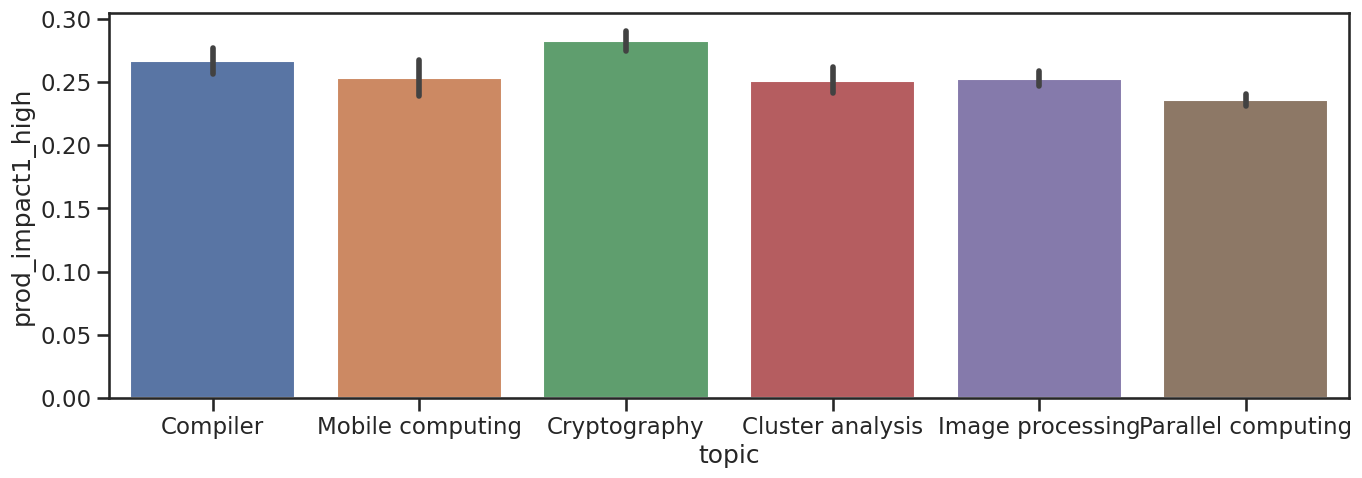

In [480]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(data=overlap_df, x='topic', y='prod_impact1_high', ax=ax);

In [484]:
errorfunc

('ci', 95)

In [523]:
error_func = 'se'
for field in 'Physics', 'CS', 'BioMed':
    overlap_df = (
        pd.read_csv(
            basepath / field / 'Sets_overlap_mean/Sets_overlap_windows.csv', 
            sep=';', index_col=0,
        )
        .set_index('topic')
        .sort_values(by='T_0')
        .loc[topic_orders[field]]
        .reset_index()
    )
    overlap_df

    dfs = []
    for col in 'prod_impact1_high', 'prod_impact1_low':
        df = (
            overlap_df
            .groupby('topic')
            .apply(lambda g: conf_interval(g[col], errorfunc=errorfunc, return_errors=True))
            .add_prefix(f'{col}_')
        )
        dfs.append(df)

    agg_df = pd.concat(dfs, axis=1)
    print(f'\n%% {field} - set overlap stats')
    print(r'\begin{table}' + '\n' + r'\centering')
    print(r'\caption{' + field + '. Mean Overlap Coefficient. Prod v. Impact v1}')
    print(
        agg_df
        [['prod_impact1_high_mean', 'prod_impact1_low_mean']]
        .round(3)
        .rename(columns={'prod_impact1_high_mean': 'Top 10', 
                         'prod_impact1_low_mean': 'Bottom 10'})
        .reset_index()
        # .iloc[:, 1:]
        .to_latex(float_format='%.3f', index=False)
    )
    print(r'\end{table}')



%% Physics - set overlap stats
\begin{table}
\centering
\caption{Physics. Mean Overlap Coefficient. Prod v. Impact v1}
\begin{tabular}{lrr}
\toprule
              topic &  Top 10 &  Bottom 10 \\
\midrule
        Dark matter &   0.309 &      0.148 \\
     Fluid dynamics &   0.237 &      0.111 \\
 Gravitational wave &   0.332 &      0.135 \\
            Soliton &   0.305 &      0.136 \\
Statistical physics &   0.322 &      0.132 \\
  Superconductivity &   0.258 &      0.155 \\
      Supersymmetry &   0.297 &      0.168 \\
\bottomrule
\end{tabular}

\end{table}


/tmp/ipykernel_30545/1144823385.py:37: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



## exp 2C new stuff 
## TODO: 
* regenerate Sara's numbers at threshold `0.05` and `0.1`. 
* The denominator is all authors with at least 1 inactive susceptible coauthor
* Cluster analysis - impact - curve for fewer coauthors < curve for more coauthors for threshold `0.05`
* Why is there an inversion? Compared to other cases when there isn't one at `0.05`
* Pick a smaller non-zero threshold for 2C 

In [ ]:
window_info_df = pd.read_csv(basepath / field / 'info_windows.csv', sep=';')

In [ ]:
viable_windows = sorted(
    window_info_df
    .query('topic==@topic')
    [(window_info_df['EW-papers topic'] > works_threshold) & (window_info_df['OW-papers topic']>works_threshold)]
    ['T_0']
)
display(f'{topic} {len(viable_windows)} windows with >{works_threshold} papers')


In [643]:
import pickle 
import statistics

def load_pickle(path):
    return pickle.load(open(path, 'rb'))

def median_low(a):
    a = np.array(a)
    a = a[~np.isnan(a)]
    if len(a) == 0:
        return np.nan
    else:
        return statistics.median_low(a)

def median_high(a):
    a = np.array(a)
    a = a[~np.isnan(a)]
    if len(a) == 0:
        return np.nan
    else:
        return statistics.median_high(a)

dict_keys(['Protein structure', 'Genome', 'Peptide sequence', "Alzheimer's disease", 'Neurology', 'Radiation therapy', 'Chemotherapy'])

In [783]:
# for the top 20% and bottom 20% authors sorted by productivity/impact 
x = load_pickle(basepath / f'{field}/{metric}/Exp2/val_dist_windows')
x[topic][1999]

[array([9.        , 4.        , 3.        , 3.        , 3.        ,
        2.33333333, 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 1.85714286, 1.57142857, 1.5       ,
        1.5       , 1.5       , 1.5       , 1.33333333, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.83333333, 0.77777778,
        0.71428571, 0.57142857, 0.5       , 0.5       , 0.5       ,
        0.4       , 0.33333333, 0.33333333, 0.33333333]),
 array([3.        , 2.83333333, 2.6       , 2.36363636, 2.16666667,
        2.        , 2.        , 2.        , 1.83333333, 1.66666667,
        1.6       , 1.58333333, 1.51851852, 1.5       , 1.5       ,
        1.5       , 1.5       , 1.4       , 1.33333333, 1.2       ,
        1.16666667, 1.125     , 1.08333333, 1.08333333, 1.        ,
        1.        , 1.        , 0.66666667, 0.66666667, 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.

In [784]:
# distribution of average coauthors per paper for top 20% and bottom 20% - used to make the classes
y = load_pickle(basepath / f'{field}/{metric}/Exp2/val_coauthors_dist_windows')
y[topic][1999]

[array([29.        , 20.        , 17.        , 15.5       , 14.        ,
        12.        ,  8.5       ,  8.33333333,  8.        ,  8.        ,
         8.        ,  7.42857143,  7.        ,  6.42857143,  6.375     ,
         6.        ,  6.        ,  6.        ,  6.        ,  6.        ,
         5.83333333,  5.75      ,  5.5       ,  5.16666667,  5.        ,
         5.        ,  5.        ,  5.        ,  5.        ,  5.        ,
         5.        ,  5.        ,  5.        ,  5.        ,  5.        ,
         4.66666667,  4.52380952,  4.5       ,  4.5       ]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.])]

In [852]:
field = 'CS'
# field = 'BioMed'
# metric = 'Productivity'
metric = 'Impact_mean1'
# topic = 'Protein structure'
topic = 'Cluster analysis'
# topic = 'Chemotherapy'
thresh = 0.05

vec_dist_windows = load_pickle(basepath / f'{field}/{metric}/Exp2/frac_vec_dist_windows')
vec_dist_windows.keys()

dfs = []
for T0, d in vec_dist_windows[topic].items():
    df = (
        pd.DataFrame(d)
        .transpose()
        .rename(columns={0: 'num_moreCoauth', 1: 'denom_moreCoauth', 2: 'frac_moreCoauth', 
                         3: 'num_lessCoauth', 4: 'denom_lessCoauth', 5: 'frac_lessCoauth'})
         .assign(
            topic=topic, T0=T0, metric=metric, thresh=thresh,
            filt=lambda df_: (df_.frac_moreCoauth>=thresh) | (df_.frac_lessCoauth>=thresh),
        )
    )
    
    dfs.append(df)


new_dfs = []
for df in dfs:
    # nonzero vals 
    frac_more, frac_less = df.frac_moreCoauth, df.frac_lessCoauth
    frac_more, frac_less = frac_more[frac_more>0], frac_less[frac_less>0]

    # new_thresh = min(frac_more.min(), frac_less.min())
    new_thresh = frac_less.min()  # min nonzero for bottom 20%
    
    # new_thresh = 0.1999
    df = (
        df
        .assign(
            new_thresh=new_thresh, new_filt=lambda df_: (df_.frac_moreCoauth>=new_thresh) | (df_.frac_lessCoauth>=new_thresh),
        )
    )
    new_dfs.append(df)

combined_df = (
    pd.concat(new_dfs)
    .reset_index()
)
display(combined_df.head(2))

rows = []
for T0, T0_grp in combined_df.groupby('T0'):
    mask = T0_grp.filt
    new_thresh=T0_grp.new_thresh.mean()
    new_mask = T0_grp.new_filt
    total = T0_grp.frac_moreCoauth.count()
    filt_moreCoauth, filt_lessCoauth = T0_grp[mask].frac_moreCoauth.count(), T0_grp[mask].frac_lessCoauth.count()
    moreCoauth_frac, lessCoauth_frac = filt_moreCoauth/total, filt_lessCoauth/total,
    
    new_filt_moreCoauth, new_filt_lessCoauth = T0_grp[new_mask].frac_moreCoauth.count(), T0_grp[new_mask].frac_lessCoauth.count()
    new_moreCoauth_frac, new_lessCoauth_frac = new_filt_moreCoauth/total, new_filt_lessCoauth/total,
    
    row = dict(
        topic=topic, T0=T0, metric=metric, 
        total=total, thresh=thresh,
        moreCoauth=filt_moreCoauth,
        lessCoauth=filt_lessCoauth,
        moreCoauth_frac=moreCoauth_frac, lessCoauth_frac=lessCoauth_frac,
        differ=moreCoauth_frac-lessCoauth_frac,
        new_thresh=new_thresh,
        new_moreCoauth=new_filt_moreCoauth,
        new_lessCoauth=new_filt_lessCoauth,
        new_moreCoauth_frac=new_moreCoauth_frac, new_lessCoauth_frac=new_lessCoauth_frac,
        new_differ=new_moreCoauth_frac-new_lessCoauth_frac,
    )
    rows.append(row)

combined_agg_df = pd.DataFrame(rows)

(
    combined_agg_df
    .round(3)
    .style
    .highlight_between(right=0, axis=1, subset=['differ', 'new_differ'], color='Crimson')
    .format(precision=3)
)

,index,num_moreCoauth,denom_moreCoauth,frac_moreCoauth,num_lessCoauth,denom_lessCoauth,frac_lessCoauth,topic,T0,metric,thresh,filt,new_thresh,new_filt
0,2159224453,0.0,8.0,0.0,NaN,NaN,NaN,Cluster analysis,1997,Impact_mean1,0.05,False,0.5,False
1,2005282695,0.0,4.0,0.0,NaN,NaN,NaN,Cluster analysis,1997,Impact_mean1,0.05,False,0.5,False


,topic,T0,metric,total,thresh,moreCoauth,lessCoauth,moreCoauth_frac,lessCoauth_frac,differ,new_thresh,new_moreCoauth,new_lessCoauth,new_moreCoauth_frac,new_lessCoauth_frac,new_differ
0,Cluster analysis,1997,Impact_mean1,31,0.050,2,4,0.065,0.129,-0.065,0.500,0,4,0.000,0.129,-0.129
1,Cluster analysis,1998,Impact_mean1,34,0.050,1,2,0.029,0.059,-0.029,0.500,0,2,0.000,0.059,-0.059
2,Cluster analysis,1999,Impact_mean1,39,0.050,5,4,0.128,0.103,0.026,0.500,0,4,0.000,0.103,-0.103
3,Cluster analysis,2000,Impact_mean1,39,0.050,9,5,0.231,0.128,0.103,0.400,1,5,0.026,0.128,-0.103
4,Cluster analysis,2001,Impact_mean1,45,0.050,5,1,0.111,0.022,0.089,1.000,0,1,0.000,0.022,-0.022
5,Cluster analysis,2002,Impact_mean1,53,0.050,12,4,0.226,0.075,0.151,0.154,3,4,0.057,0.075,-0.019
6,Cluster analysis,2003,Impact_mean1,65,0.050,17,7,0.262,0.108,0.154,0.333,0,7,0.000,0.108,-0.108
7,Cluster analysis,2004,Impact_mean1,76,0.050,18,12,0.237,0.158,0.079,0.200,5,12,0.066,0.158,-0.092
8,Cluster analysis,2005,Impact_mean1,94,0.050,12,10,0.128,0.106,0.021,0.500,1,10,0.011,0.106,-0.096
9,Cluster analysis,2006,Impact_mean1,116,0.050,13,15,0.112,0.129,-0.017,0.250,3,15,0.026,0.129,-0.103


In [848]:
dfs[0]

,num_moreCoauth,denom_moreCoauth,frac_moreCoauth,num_lessCoauth,denom_lessCoauth,frac_lessCoauth,topic,T0,metric,thresh,filt,new_thresh,new_filt
2159224453,0.0,8.0,0.0,NaN,NaN,NaN,Cluster analysis,1997,Impact_mean1,0.05,False,0.1999,False
2005282695,0.0,4.0,0.0,NaN,NaN,NaN,Cluster analysis,1997,Impact_mean1,0.05,False,0.1999,False
2168582158,0.0,19.0,0.0,NaN,NaN,NaN,Cluster analysis,1997,Impact_mean1,0.05,False,0.1999,False
2997958416,0.0,12.0,0.0,NaN,NaN,NaN,Cluster analysis,1997,Impact_mean1,0.05,False,0.1999,False
2168087185,0.0,84.0,0.0,NaN,NaN,NaN,Cluster analysis,1997,Impact_mean1,0.05,False,0.1999,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595293426,NaN,NaN,NaN,0.0,1.0,0.0,Cluster analysis,1997,Impact_mean1,0.05,False,0.1999,False
2123792883,NaN,NaN,NaN,0.0,1.0,0.0,Cluster analysis,1997,Impact_mean1,0.05,False,0.1999,False
2203799027,NaN,NaN,NaN,0.0,1.0,0.0,Cluster analysis,1997,Impact_mean1,0.05,False,0.1999,False
2040337400,NaN,NaN,NaN,0.0,3.0,0.0,Cluster analysis,1997,Impact_mean1,0.05,False,0.1999,False


In [844]:
median_low(combined_agg_df.new_thresh)

0.19999999999999998

In [802]:
(
    combined_df
    
)

,index,num_moreCoauth,denom_moreCoauth,frac_moreCoauth,num_lessCoauth,denom_lessCoauth,frac_lessCoauth,topic,T0,metric,thresh,filt
0,1969789440,0.0,6.0,0.0,NaN,NaN,NaN,Chemotherapy,1995,Impact_mean1,0.05,False
1,2265107458,0.0,27.0,0.0,NaN,NaN,NaN,Chemotherapy,1995,Impact_mean1,0.05,False
2,1970543107,0.0,5.0,0.0,NaN,NaN,NaN,Chemotherapy,1995,Impact_mean1,0.05,False
3,1395536901,0.0,5.0,0.0,NaN,NaN,NaN,Chemotherapy,1995,Impact_mean1,0.05,False
4,270755845,0.0,10.0,0.0,NaN,NaN,NaN,Chemotherapy,1995,Impact_mean1,0.05,False
...,...,...,...,...,...,...,...,...,...,...,...,...
16111,2165936119,NaN,NaN,NaN,0.0,1.0,0.0,Chemotherapy,2017,Impact_mean1,0.05,False
16112,2088499194,NaN,NaN,NaN,0.0,1.0,0.0,Chemotherapy,2017,Impact_mean1,0.05,False
16113,2086240252,NaN,NaN,NaN,0.0,6.0,0.0,Chemotherapy,2017,Impact_mean1,0.05,False
16114,2128605181,NaN,NaN,NaN,0.0,2.0,0.0,Chemotherapy,2017,Impact_mean1,0.05,False


In [782]:
(
    conf_interval(combined_agg_df.differ)
)

mean             0.031063
mean_ci95_min    0.006132
mean_ci95_max    0.057493
dtype: float64

In [746]:
{k: v for k, v in vec_dist_windows[topic][2001][3].items() if v > 0}

{2153620406: 1}

In [777]:
sara_df = (
    pd.read_csv(basepath / field / f'{metric}/Exp2' / f'df_topic_windows_{thresh}.csv', index_col=0)
    [['topic', 'T_0', 'Perc', 'high1_bin1_A', 'high1_bin2_A', 'high1_bin1_A_num', 'high1_bin2_A_num']]
    .assign(metric=metric, differ=lambda df_: df_.high1_bin1_A-df_.high1_bin2_A)
    .query('topic==@topic')
)
sara_df

,topic,T_0,Perc,high1_bin1_A,high1_bin2_A,high1_bin1_A_num,high1_bin2_A_num,metric,differ
13,Cluster analysis,1997,0.05,0.027778,0.111111,1,4,Productivity,-0.083333
14,Cluster analysis,1998,0.05,0.048780,0.195122,2,8,Productivity,-0.146341
15,Cluster analysis,1999,0.05,0.104167,0.166667,5,8,Productivity,-0.062500
16,Cluster analysis,2000,0.05,0.145455,0.054545,8,3,Productivity,0.090909
17,Cluster analysis,2001,0.05,0.064516,0.112903,4,7,Productivity,-0.048387
18,Cluster analysis,2002,0.05,0.183099,0.169014,13,12,Productivity,0.014085
19,Cluster analysis,2003,0.05,0.130952,0.130952,11,11,Productivity,0.000000
20,Cluster analysis,2004,0.05,0.230000,0.130000,23,13,Productivity,0.100000
21,Cluster analysis,2005,0.05,0.214286,0.126984,27,16,Productivity,0.087302
22,Cluster analysis,2006,0.05,0.158228,0.170886,25,27,Productivity,-0.012658


In [779]:
(
    conf_interval(sara_df.differ)
)

mean            -0.035292
mean_ci95_min   -0.061934
mean_ci95_max   -0.007384
dtype: float64

# Supplementary Tables

In [9]:
basepath

PosixPath('data/Mar-15')

## Topic Average Info 

In [121]:
field = 'Physics'

for field in topic_orders:
    works_threshold = 3000
    window_info_df = pd.read_csv(basepath / field / 'info_windows.csv', sep=';')
    header = ['Papers', 'Authors', 'Papers', 'Authors']

    agg_d = {'T_0': 'count'}
    agg_d.update({col: 'mean' for col in window_info_df.columns[2:]})

    topics = topic_orders[field][: 2]
    # for topic in tqdm(topic_orders[field]):
    df = (
        window_info_df
        [(window_info_df['EW-papers topic'] > works_threshold) & (window_info_df['OW-papers topic']>works_threshold)]
        .sort_values(by=['topic', 'T_0'])
        .groupby('topic', as_index=False)
        .agg(agg_d)
        .rename(columns=lambda f: f.replace('OW-', '').replace('EW-', '').replace('topic', '').title().strip())
        .rename(columns={'T_0': 'Windows', 'Authors  - Active Authors': 'Authors', '': 'Topic'})
        # .astype('float')
        .astype({'Windows': 'int'})
        .set_index('Topic')
        .loc[topic_orders[field]]
        .reset_index()
        .set_index(['Topic', 'Windows'])
    )
    df.columns = pd.MultiIndex.from_product([['Interaction Window', 'Activation Window'], df.columns[: 2]])
    display(df.head())
    print(df.to_latex(sparsify=True, index_names=False, multicolumn=True, multirow=False,
                      position='h', caption=f'{topic}', float_format='{:,.2f}'.format, 
                      label=f'tab:{field}-info'))
    # break

Interaction Window               Activation Window   
                                       Papers       Authors            Papers   
Topic              Windows                                                      
Gravitational wave 10             3613.700000   5745.200000       5486.400000  \
Dark matter        13             6433.692308   8348.230769       9203.384615   
Fluid dynamics     16             5290.750000  11950.375000       7231.250000   
Soliton            18             4004.388889   5715.611111       4700.888889   
Supersymmetry      20             5328.850000   4827.450000       5470.750000   

                                          
                                 Authors  
Topic              Windows                
Gravitational wave 10        9160.300000  
Dark matter        13       12346.000000  
Fluid dynamics     16       16960.500000  
Soliton            18        7014.888889  
Supersymmetry      20        5361.250000

\begin{table}[h]
\caption{Gravitational wave}
\label{tab:Physics-info}
\begin{tabular}{llrrrr}
\toprule
 &  & \multicolumn{2}{r}{Interaction Window} & \multicolumn{2}{r}{Activation Window} \\
 &  & Papers & Authors & Papers & Authors \\
\midrule
Gravitational wave & 10 & 3,613.70 & 5,745.20 & 5,486.40 & 9,160.30 \\
Dark matter & 13 & 6,433.69 & 8,348.23 & 9,203.38 & 12,346.00 \\
Fluid dynamics & 16 & 5,290.75 & 11,950.38 & 7,231.25 & 16,960.50 \\
Soliton & 18 & 4,004.39 & 5,715.61 & 4,700.89 & 7,014.89 \\
Supersymmetry & 20 & 5,328.85 & 4,827.45 & 5,470.75 & 5,361.25 \\
Statistical physics & 23 & 88,147.52 & 109,702.70 & 105,018.87 & 137,680.65 \\
Superconductivity & 23 & 24,038.35 & 33,606.04 & 23,218.52 & 34,874.74 \\
\bottomrule
\end{tabular}
\end{table}



Interaction Window               Activation Window   
                                     Papers       Authors            Papers   
Topic            Windows                                                      
Compiler         13             3786.307692   7869.230769       4208.461538  \
Mobile computing 13             6356.000000  13844.769231       6828.769231   
Cryptography     15             9706.466667  15181.933333      14865.133333   
Cluster analysis 21            18585.571429  36645.952381      30996.523810   
Image processing 23            13149.652174  28191.347826      16617.652174   

                                        
                               Authors  
Topic            Windows                
Compiler         13        9701.923077  
Mobile computing 13       15827.846154  
Cryptography     15       25218.933333  
Cluster analysis 21       63910.095238  
Image processing 23       38089.695652

\begin{table}[h]
\caption{Gravitational wave}
\label{tab:CS-info}
\begin{tabular}{llrrrr}
\toprule
 &  & \multicolumn{2}{r}{Interaction Window} & \multicolumn{2}{r}{Activation Window} \\
 &  & Papers & Authors & Papers & Authors \\
\midrule
Compiler & 13 & 3,786.31 & 7,869.23 & 4,208.46 & 9,701.92 \\
Mobile computing & 13 & 6,356.00 & 13,844.77 & 6,828.77 & 15,827.85 \\
Cryptography & 15 & 9,706.47 & 15,181.93 & 14,865.13 & 25,218.93 \\
Cluster analysis & 21 & 18,585.57 & 36,645.95 & 30,996.52 & 63,910.10 \\
Image processing & 23 & 13,149.65 & 28,191.35 & 16,617.65 & 38,089.70 \\
Parallel computing & 23 & 31,453.30 & 48,006.87 & 38,271.61 & 61,960.22 \\
\bottomrule
\end{tabular}
\end{table}



Interaction Window                 
                                        Papers       Authors   
Topic               Windows                                    
Protein structure   19             6379.947368  17583.684211  \
Genome              23            28066.086957  71481.869565   
Peptide sequence    23            12347.478261  43348.956522   
Alzheimer's disease 23             9313.782609  22628.304348   
Neurology           23             9260.173913  26046.565217   

                            Activation Window                 
                                       Papers        Authors  
Topic               Windows                                   
Protein structure   19            7149.105263   20967.631579  
Genome              23           44089.782609  114696.478261  
Peptide sequence    23            9733.043478   37330.086957  
Alzheimer's disease 23           11723.217391   31624.608696  
Neurology           23           12795.695652   39515.000000

\begin{table}[h]
\caption{Gravitational wave}
\label{tab:BioMed-info}
\begin{tabular}{llrrrr}
\toprule
 &  & \multicolumn{2}{r}{Interaction Window} & \multicolumn{2}{r}{Activation Window} \\
 &  & Papers & Authors & Papers & Authors \\
\midrule
Protein structure & 19 & 6,379.95 & 17,583.68 & 7,149.11 & 20,967.63 \\
Genome & 23 & 28,066.09 & 71,481.87 & 44,089.78 & 114,696.48 \\
Peptide sequence & 23 & 12,347.48 & 43,348.96 & 9,733.04 & 37,330.09 \\
Alzheimer's disease & 23 & 9,313.78 & 22,628.30 & 11,723.22 & 31,624.61 \\
Neurology & 23 & 9,260.17 & 26,046.57 & 12,795.70 & 39,515.00 \\
Chemotherapy & 23 & 36,280.48 & 104,649.39 & 47,760.09 & 143,505.65 \\
Radiation therapy & 23 & 30,926.39 & 76,314.48 & 43,963.57 & 110,397.96 \\
\bottomrule
\end{tabular}
\end{table}



## Set overlap coefficient 

Topic | Top 10%    | Bottom 10% |

      | mean | sum | mean | sum |

In [157]:
for field in topic_orders:
    dfs = []
    for metric in 'mean', 'sum':
        df = (
            pd.read_csv(basepath / field / f'Sets_overlap_{metric}' / 'Sets_overlap_table.csv', sep=';', index_col=0)
            .query('stat=="mean"')
            .set_index('topic')
            .loc[topic_orders[field]]
            .rename(columns={'prod_impact1_high': f'Top 10% {metric}', 'prod_impact1_low': f'Bottom 10% {metric}'})
            [[f'Top 10% {metric}', f'Bottom 10% {metric}']]
        )
        dfs.append(df)
        display(df.head(2))

    df = (
        pd.concat(dfs, axis=1)
        [['Top 10% mean', 'Top 10% sum', 'Bottom 10% mean', 'Bottom 10% sum']]
        .rename(columns=lambda s: s.replace('Bottom 10%', '').title())
    )
    display(df.head(3))
    df.columns = pd.MultiIndex.from_product([['Top 10\%', 'Bottom 10\%'], df.columns[2:]])
    display(df.head(3))
    print(df.to_latex(sparsify=True, index_names=False, multicolumn=True, multirow=False,
                      position='h', caption=f'{field} overlap coefficient', float_format='{:,.2f}'.format, 
                      label=f'tab:{field}-overlap'))

,Top 10% mean,Bottom 10% mean
topic,,
Gravitational wave,0.332187,0.135280
Dark matter,0.309414,0.147819


,Top 10% sum,Bottom 10% sum
topic,,
Gravitational wave,0.589106,0.139522
Dark matter,0.556118,0.151858


,Top 10% Mean,Top 10% Sum,Mean,Sum
topic,,,,
Gravitational wave,0.332187,0.589106,0.135280,0.139522
Dark matter,0.309414,0.556118,0.147819,0.151858
Fluid dynamics,0.236763,0.377629,0.110951,0.109799


Top 10\%           Bottom 10\%          
                        Mean       Sum        Mean       Sum
topic                                                       
Gravitational wave  0.332187  0.589106    0.135280  0.139522
Dark matter         0.309414  0.556118    0.147819  0.151858
Fluid dynamics      0.236763  0.377629    0.110951  0.109799

\begin{table}[h]
\caption{Physics overlap coefficient}
\label{tab:Physics-overlap}
\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{r}{Top 10\%} & \multicolumn{2}{r}{Bottom 10\%} \\
 &  Mean &  Sum &  Mean &  Sum \\
\midrule
Gravitational wave & 0.33 & 0.59 & 0.14 & 0.14 \\
Dark matter & 0.31 & 0.56 & 0.15 & 0.15 \\
Fluid dynamics & 0.24 & 0.38 & 0.11 & 0.11 \\
Soliton & 0.30 & 0.54 & 0.14 & 0.13 \\
Supersymmetry & 0.30 & 0.58 & 0.17 & 0.16 \\
Statistical physics & 0.32 & 0.56 & 0.13 & 0.13 \\
Superconductivity & 0.26 & 0.60 & 0.16 & 0.15 \\
\bottomrule
\end{tabular}
\end{table}



,Top 10% mean,Bottom 10% mean
topic,,
Compiler,0.266353,0.119719
Mobile computing,0.253444,0.115059


,Top 10% sum,Bottom 10% sum
topic,,
Compiler,0.463952,0.114722
Mobile computing,0.414950,0.115308


,Top 10% Mean,Top 10% Sum,Mean,Sum
topic,,,,
Compiler,0.266353,0.463952,0.119719,0.114722
Mobile computing,0.253444,0.414950,0.115059,0.115308
Cryptography,0.282611,0.513000,0.123538,0.122401


Top 10\%           Bottom 10\%          
                      Mean       Sum        Mean       Sum
topic                                                     
Compiler          0.266353  0.463952    0.119719  0.114722
Mobile computing  0.253444  0.414950    0.115059  0.115308
Cryptography      0.282611  0.513000    0.123538  0.122401

\begin{table}[h]
\caption{CS overlap coefficient}
\label{tab:CS-overlap}
\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{r}{Top 10\%} & \multicolumn{2}{r}{Bottom 10\%} \\
 &  Mean &  Sum &  Mean &  Sum \\
\midrule
Compiler & 0.27 & 0.46 & 0.12 & 0.11 \\
Mobile computing & 0.25 & 0.41 & 0.12 & 0.12 \\
Cryptography & 0.28 & 0.51 & 0.12 & 0.12 \\
Cluster analysis & 0.25 & 0.41 & 0.12 & 0.12 \\
Image processing & 0.25 & 0.42 & 0.12 & 0.11 \\
Parallel computing & 0.24 & 0.53 & 0.13 & 0.13 \\
\bottomrule
\end{tabular}
\end{table}



,Top 10% mean,Bottom 10% mean
topic,,
Protein structure,0.215563,0.126124
Genome,0.223384,0.131587


,Top 10% sum,Bottom 10% sum
topic,,
Protein structure,0.456738,0.128856
Genome,0.500425,0.130893


,Top 10% Mean,Top 10% Sum,Mean,Sum
topic,,,,
Protein structure,0.215563,0.456738,0.126124,0.128856
Genome,0.223384,0.500425,0.131587,0.130893
Peptide sequence,0.178307,0.413945,0.118764,0.119142


Top 10\%           Bottom 10\%          
                       Mean       Sum        Mean       Sum
topic                                                      
Protein structure  0.215563  0.456738    0.126124  0.128856
Genome             0.223384  0.500425    0.131587  0.130893
Peptide sequence   0.178307  0.413945    0.118764  0.119142

\begin{table}[h]
\caption{BioMed overlap coefficient}
\label{tab:BioMed-overlap}
\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{r}{Top 10\%} & \multicolumn{2}{r}{Bottom 10\%} \\
 &  Mean &  Sum &  Mean &  Sum \\
\midrule
Protein structure & 0.22 & 0.46 & 0.13 & 0.13 \\
Genome & 0.22 & 0.50 & 0.13 & 0.13 \\
Peptide sequence & 0.18 & 0.41 & 0.12 & 0.12 \\
Alzheimer's disease & 0.19 & 0.55 & 0.13 & 0.14 \\
Neurology & 0.16 & 0.37 & 0.12 & 0.12 \\
Chemotherapy & 0.22 & 0.54 & 0.13 & 0.13 \\
Radiation therapy & 0.24 & 0.54 & 0.13 & 0.13 \\
\bottomrule
\end{tabular}
\end{table}



## Membership closure 
Three versions correspond to three different kinds of contacts: 
1. Weighted degree
2. Number of papers
3. Number of distinct active authors

Three different impact measures. Citations accumulated only in the exposure window.
1. All authored papers, only citations from papers in topic $t$
2. Authored papers in topic $t$, all incoming citations
3. Authored papers in topic $t$, only citations from papers in topic $t$

# Old stuff

### Overall (A)

In [ ]:
# just copy the files straight from the closure directory 

## Part (B)
Factor in either top 10% or 20% 

In [267]:
chunks = parse_pgfplots_code(basepath / 'closure/closure_B_10_BioMed_Impact1_ver1.txt')
chunks.keys()

dict_keys(['MicrobiomeImpactOneVersionOneTopTen', 'NeurologyImpactOneVersionOneTopTen', 'AlzheimersdiseaseImpactOneVersionOneTopTen', 'CellcycleImpactOneVersionOneTopTen', 'VeterinarymedicineImpactOneVersionOneTopTen', 'ChemotherapyImpactOneVersionOneTopTen', 'RadiationtherapyImpactOneVersionOneTopTen', 'GenomeImpactOneVersionOneTopTen', 'DopamineImpactOneVersionOneTopTen'])

In [269]:
print(chunks['MicrobiomeImpactOneVersionOneTopTen'])

\pgfplotstableread{ 
concept k prob_mean_high1 prob_std_high1 prob_mean_low1 prob_std_low1
Microbiome 1 0.0513060618508202 0.0008742523515906 0.0446115964167512 0.0015854026746803
Microbiome 2 0.0729656805854712 0.0014020584690158 0.0651739635501433 0.002265749931463
Microbiome 3 0.0925119301490505 0.0023092640618417 0.0776900716449736 0.003213078885327
Microbiome 4 0.1073969407729643 0.0033573751940467 0.0870029962871669 0.0032946161643141
Microbiome 5 0.1223049034399052 0.004517290097706 0.0967453568419031 0.0034328196827102
Microbiome 6 0.1292566948700754 0.0052592743111775 0.1010384543677532 0.0049644257927017
Microbiome 7 0.1393319394198524 0.0069476361779197 0.106480590273706 0.0058988231564896
Microbiome 8 0.1416608061681733 0.0068663170001267 0.109045900325424 0.0069009484233544
Microbiome 9 0.1497460513389298 0.0073102869518135 0.1106570413527285 0.0080442604166004
Microbiome 10 0.1526609476594736 0.0079869192933059 0.1138517444409946 0.0107196564406373
}{\MicrobiomeImpactOneV

In [270]:
# output one combined file for each metric: Productivity, Impact; for each field
# combine all versions into one

metrics = ['Impact1', 'Impact2', 'Impact3', 'Productivity']
versions = ['ver1', 'ver2', 'ver3']
fields = ['Physics++', 'CS', 'BioMed']

exp_part = 'B'
for field in fields:
    combined_path = basepath / f'combined/closure/{field.replace("++", "")}_{exp_part}.tex'
    print(combined_path)
    with open(combined_path, 'w') as writer:
        for metric in metrics:
            for top_k in [10, 20]:
                for version in versions:
                    path = basepath / f'closure/closure_{exp_part}_{top_k}_{field}_{metric}_{version}.txt'
                    chunks = parse_pgfplots_code(path)
                    for chunk in chunks.values():
                        writer.write(chunk)
                        writer.write('\n')
                    writer.write('\n')

data/combined/closure/Physics_B.tex
data/combined/closure/CS_B.tex
data/combined/closure/BioMed_B.tex


# Influence 

## Part (A) Fraction of inactive neighbors 

In [275]:
chunks = parse_pgfplots_code(basepath / 'influence/influence_A_20_BioMed_Impact_mean1.txt')

In [276]:
chunks.keys()

dict_keys(['RadiationtherapyImpactVersionOneTopTwenty', 'MicrobiomeImpactVersionOneTopTwenty', 'DopamineImpactVersionOneTopTwenty', 'NeurologyImpactVersionOneTopTwenty', 'GenomeImpactVersionOneTopTwenty', 'ChemotherapyImpactVersionOneTopTwenty', 'VeterinarymedicineImpactVersionOneTopTwenty', 'CellcycleImpactVersionOneTopTwenty', 'AlzheimersdiseaseImpactVersionOneTopTwenty'])

In [278]:
# output one combined file for each metric: Productivity, Impact; for each field
# combine all versions into one

metrics = ['Impact_mean1', 'Impact_mean2', 'Impact_mean3', 'Productivity']
fields = ['Physics++', 'CS', 'BioMed']

exp_part = 'A'
for field in fields:
    combined_path = basepath / f'combined/influence/{field.replace("++", "")}_{exp_part}.tex'
    print(combined_path)
    with open(combined_path, 'w') as writer:
        for metric in metrics:        
            for top_k in [10, 20]:
                path = basepath / f'influence/influence_{exp_part}_{top_k}_{field}_{metric}.txt'
                chunks = parse_pgfplots_code(path)
                for chunk in chunks.values():
                    writer.write(chunk)
                    writer.write('\n')
                writer.write('\n')
        

data/combined/influence/Physics_A.tex
data/combined/influence/CS_A.tex
data/combined/influence/BioMed_A.tex


# Write Python script to output PGFPlots code to do the plots 


In [206]:
topics_orders = {
    'Physics': ['String theory', 'Quantum gravity', 'Neutrino oscillation', 
                'Supersymmetry', 'Magnetoresistance', 'General relativity', 
                'Soliton', 'Dark matter', 'Graphene'],
    
    'CS': ['Anomaly detection', 'Cryptography', 'Virtual machine', 'Feature selection',
           'Deep learning', 'Support vector machine', 'Parallel computing', 
           'Cluster analysis', 'Operating system'],
    
    'BioMed': ['Microbiome', 'Alzheimers disease', 'Neurology', 'Dopamine',
               'Cell cycle', 'Genome', 'Radiation therapy', 'Veterinary medicine', 'Chemotherapy']
    
}

# Experiment I
Membership closure

One field, all topics. 

Columns: (5) Overall, Productivity, Impact v1, v2, v3

Rows: (9) topics

In [782]:
starter = r'''\begin{tikzpicture}

\begin{groupplot}[
        group style={
			group name=my plots,
			group size=5 by 9,
			x descriptions at=edge bottom,
			y descriptions at=edge left,
			vertical sep=8pt,
            horizontal sep=17pt,
		},
        width=125pt,
        height=100pt,
        ymajorgrids,
		grid style={draw=gray!25},
        xtick distance=2,
        minor x tick num=1,
        xtick align = center, 
		ytick style={draw=none},
        axis y line*=left,
        axis x line*=bottom, 
        yticklabel style={xshift=-0.2em},
        yticklabel style={
            /pgf/number format/.cd,
            fixed,
            fixed zerofill,
            precision=2,
            /tikz/.cd
    	},
        title style={yshift=-1.5em, align=center, text=gray, fill=none, font=\small\sffamily},
        xmin=0, xmax=10,
        ymin=0,
        enlarge x limits=0.05,
        enlarge y limits=0.05,
        xlabel={Active contacts ($k$)},
        ylabel={Probability},
        every node near coord/.append style={font=\tiny},
        nodes near coords align={below},
        ytick distance=0.04,
        filter discard warning=false,
    ]
'''

end = r'''
%%%%%%%%%%%%%%%%%

\node[anchor=south] at ($(my plots c1r1.north)+(0, 0.12)$){\normalsize{Overall}};
\node[anchor=south] at ($(my plots c2r1.north)+(0, 0.12)$){\normalsize{Productivity}};
\node[anchor=south] at ($(my plots c3r1.north)+(0, 0.12)$){\normalsize{Impact v1}};
\node[anchor=south] at ($(my plots c4r1.north)+(0, 0.12)$){\normalsize{Impact v2}};
\node[anchor=south] at ($(my plots c5r1.north)+(0, 0.12)$){\normalsize{Impact v3}};

\begin{scope}[shift={(14.1, -20)}]
    \begin{customlegend}[ 
    legend columns=4,
    legend style={
    draw=none,
    column sep=2ex,
  },
  legend cell align={left},
  legend entries={Observed~~,Simple contagion baseline~~~,Prominent authors~~~,Random samples}
  ]
    \addlegendimage{cumulative_prob}
    \addlegendimage{cumulative_baseline}
    \addlegendimage{active}
    \addlegendimage{baseline}
    \end{customlegend}
\end{scope}
\end{tikzpicture}
'''

In [783]:
metrics = ['Overall', 'Productivity', 'ImpactOne', 'ImpactTwo', 'ImpactThree']

experiment = 'closure'    
for v, version in zip([1, 2, 3], ['One', 'Two', 'Three']):
    if v == 2:
        starter = (
            starter
            .replace(r'xlabel={Active contacts ($k$)},', r'xlabel={Topic Papers ($k$)},')
        )
    if v == 3:
        starter = (
            starter
            .replace(r'xlabel={Active contacts ($k$)},', r'xlabel={Distinct coauthors ($k$)},')
        )
    
    for field in ['CS', 'Physics', 'BioMed']:
        p_vals_A = get_p_values(field=field, experiment='closure', exp_part='A')['Overall']
        
        for k, top_k in zip([1, 2], ['Ten', 'Twenty']):
            p_vals_metrics = get_p_values(field=field, experiment='closure', exp_part='B', version=v, top_k=k*10)
            code_path = Path().cwd() / 'tikz_codes' / 'closure' / f'{field}_Version{version}_Top{k*10}.tex'
            print(code_path)

            with open(code_path, 'w') as writer:
                writer.write(f'%%% {field} {exp_part} Top {top_k}\n\n')
                writer.write('\input{data/closure/' + field + '_A}\n')
                writer.write('\input{data/closure/' + field + '_B}\n')
                writer.write(r'\tikzsetnextfilename{' + f'{experiment}-{version}-{field}-Top{k*10}' + '}' + '\n')
                
                topic_strs = []
                writer.write(starter)
                for i, topic in enumerate(topics_orders[field]):
                    code = ['\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n']
                    ymax = -1
                    for metric in metrics:
                        if metric == 'Overall':
                            exp_part = 'A'
                            tab_name = topic.replace(' ', '')
                        else:
                            exp_part = 'B'
                            tab_name = topic.replace(' ', '') + metric + f'Version{version}'  f'Top{top_k}'
                            
                        ym = get_max_from_pgfplots_table(field=field, exp_part=exp_part, table_name=tab_name,
                                                         experiment='closure')
                        if ym > ymax:
                            ymax = ym
                    assert ymax != -1
                    ymax += 0.01

                    if ymax <= 0.1:
                        next_groupplot_config_st = ', ytick distance=0.02'
                    elif ymax <= 0.2:
                        next_groupplot_config_st = ', ytick distance=0.04'
                    elif ymax <= 0.3:
                        next_groupplot_config_st = ', ytick distance=0.06'
                    elif ymax <= 0.5:
                        next_groupplot_config_st = ', ytick distance=0.10'
                    elif ymax <= 0.6:
                        next_groupplot_config_st = ', ytick distance=0.15'
                    else:
                        next_groupplot_config_st = ', ytick distance=0.20'
                    
                    # TODO: insert p value as title 
                    title_str = ''
                    
                    for metric in metrics:
                        code.append(
                            '\n' + r'\nextgroupplot[title={' + title_str + '},' + f' ymax={ymax:.4f}' + next_groupplot_config_st + ']'
                        )
                        if metric == 'Overall':
                            exp_part = 'A'
                            table_name = '{' + '\\' + topic.replace(' ', '') + '};'
                            p_val_str = format_p_values(p_vals_A[topic])
                            # add p_value 
                            code.append(
                                '\n\t' + r'\node[text=magenta, font=\small\sffamily] at (axis cs: 5,' + f'{ymax-0.005:.5f}' + ') {' + p_val_str + '};\n'
                            )
                            
                            code.extend([
                                '\t' + fr'\addplot [cumulative_prob] table[x=k, y=prob_mean] ' + table_name + '\n',
                                '\t' + r'\addplot [name path=upper,draw=none] table[x=k, y expr=\thisrow{prob_mean}+\thisrow{prob_std}] ' + table_name,
                                '\t' + r'\addplot [name path=lower,draw=none] table[x=k, y expr=\thisrow{prob_mean}-\thisrow{prob_std}] ' + table_name,
                                '\t' + r'\addplot [cumulative_err] fill between[of=upper and lower];' + '\n',

                                '\t' + fr'\addplot [cumulative_baseline] table[x=k,y=val] ' + table_name + '\n',
                            ])

                        else:
                            exp_part = 'B'
                            table_name = '{' + '\\' + topic.replace(' ', '') + metric + f'Version{version}'  f'Top{top_k}' + '};'
                            
                            p_val_str = format_p_values(p_vals_metrics[metric][topic])
                            
                            code.append(
                                '\n\t' + r'\node[text=Pastel1-A!30!red, font=\small\sffamily] at (axis cs: 5,' + f'{ymax-0.01:.5f}' + ') {' + p_val_str + '};\n'
                            )
                                
                            high_mean, high_err = f'prob_mean_high{k}', f'prob_std_high{k}'
                            high_upper_expr = r', y expr=\thisrow{' + high_mean + r'}+\thisrow{' + high_err + '}]'
                            high_lower_expr = r', y expr=\thisrow{' + high_mean + r'}-\thisrow{' + high_err + '}]'

                            base_mean, base_err = f'prob_mean_low{k}', f'prob_std_low{k}'
                            base_upper_expr = r', y expr=\thisrow{' + base_mean + r'}+\thisrow{' + base_err + '}]'
                            base_lower_expr = r', y expr=\thisrow{' + base_mean + r'}-\thisrow{' + base_err + '}]'

                            code.extend([
                                '\t' + fr'\addplot [active] table[x=k, y={high_mean}] ' + table_name + '\n',

                                '\t' + r'\addplot [name path=upper,draw=none] table[x=k' + high_upper_expr + table_name,
                                '\t' + r'\addplot [name path=lower,draw=none] table[x=k' + high_lower_expr + table_name,
                                '\t' + r'\addplot [active_err] fill between[of=upper and lower];' + '\n',

                                '\t' + fr'\addplot [baseline] table[x=k, y={base_mean}] ' + table_name + '\n', 

                                '\t' + r'\addplot [name path=upper,draw=none] table[x=k' + base_upper_expr + table_name,
                                '\t' + r'\addplot [name path=lower,draw=none] table[x=k' + base_lower_expr + table_name,
                                '\t' + r'\addplot [baseline_err] fill between[of=upper and lower];' + '\n',             
                            ])                

                        code.append('%%%%%%%%%%%%%%%%%')
                    
                    if topic == 'Support vector machine':
                            topic = r'Support vector\\machine'
                    elif topic in ['Alzheimers disease', 'Radiation therapy', 'Veterinary medicine', 'Quantum gravity', 
                                   'Neutrino oscillation', 'General relativity', 'Anomaly detection', 'Virtual machine', 'Feature selection',
                                   'Parallel computing', 'Cluster analysis', 'Operating system', 'Deep learning']:
                        topic = topic.replace(' ', r'\\')
                        
                    topic_strs.append('\n' + r'\node[anchor=south, rotate=-90, text=gray, font=\small\sffamily, align=center] at ($(my plots c5r' 
                                      + str(i+1) + r'.east)+(0.3, 0)$){' + topic + '};')
                    writer.write('\n'.join(code))                
                    
                # write the end bits 
                writer.write('\n' + r'\end{groupplot}')
                writer.write('\n'.join(topic_strs))
                writer.write(end)

/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/closure/CS_VersionOne_Top10.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/closure/CS_VersionOne_Top20.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/closure/Physics_VersionOne_Top10.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/closure/Physics_VersionOne_Top20.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/closure/BioMed_VersionOne_Top10.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/closure/BioMed_VersionOne_Top20.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/closure/CS_VersionTwo_Top10.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/closure/CS_VersionTwo_Top20.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/closure/Physics_VersionTwo_Top10.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/closure/Physics_VersionTwo_Top20.tex
/N

In [784]:
%%bash
cd tikz_codes
zip -r closure.zip closure

updating: closure/ (stored 0%)
updating: closure/BioMed_VersionTwo_Top20.tex (deflated 94%)
updating: closure/CS_VersionOne_Top10.tex (deflated 94%)
updating: closure/BioMed_VersionOne_Top20.tex (deflated 94%)
updating: closure/CS_VersionThree_Top10.tex (deflated 94%)
updating: closure/Physics_VersionOne_Top20.tex (deflated 94%)
updating: closure/CS_VersionOne_Top20.tex (deflated 94%)
updating: closure/BioMed_VersionTwo_Top10.tex (deflated 94%)
updating: closure/Physics_VersionThree_Top10.tex (deflated 94%)
updating: closure/CS_VersionTwo_Top20.tex (deflated 94%)
updating: closure/CS_VersionTwo_Top10.tex (deflated 94%)
updating: closure/Physics_VersionThree_Top20.tex (deflated 94%)
updating: closure/Physics_VersionTwo_Top10.tex (deflated 94%)
updating: closure/Physics_VersionTwo_Top20.tex (deflated 94%)
updating: closure/CS_VersionThree_Top20.tex (deflated 94%)
updating: closure/Physics_VersionOne_Top10.tex (deflated 94%)
updating: closure/.ipynb_checkpoints/ (stored 0%)
updating: clos

# Experiment II 

TODO: add p value annotations

Pick a field, all concepts. 

Columns: Productivity, Impact v1, v2, v3

Separate plots for Top 10% and top 20%

set order of topics for each field: and generate plots in that order

```TeX
\nextgroupplot[title={Dark matter (P)}, ymax=0.15, ytick distance=0.05, title style={yshift=-0.1em}]
        \addplot [active] table[x=Perc,y=high1_A_mean]{\DarkmatterProd}; 
        
        \addplot [name path=upper,draw=none] table[x=Perc,y expr=\thisrow{high1_A_mean}+\thisrow{high1_A_sterr}] {\DarkmatterProd};
        \addplot [name path=lower,draw=none] table[x=Perc,y expr=\thisrow{high1_A_mean}-\thisrow{high1_A_sterr}] {\DarkmatterProd};
        \addplot [active_err] fill between[of=upper and lower];
        
        \addplot [baseline] table[x=Perc,y=base1_A_mean]{\DarkmatterProd}; 
        
        \addplot [name path=upper,draw=none] table[x=Perc,y expr=\thisrow{base1_A_mean}+\thisrow{base1_A_sterr}] {\DarkmatterProd};
        \addplot [name path=lower,draw=none] table[x=Perc,y expr=\thisrow{base1_A_mean}-\thisrow{base1_A_sterr}] {\DarkmatterProd};
        \addplot [baseline_err] fill between[of=upper and lower];

        \addplot [inactive] table[x=Perc,y=inactive1_A_mean]{\DarkmatterProd}; 
        
        \addplot [name path=upper,draw=none] table[x=Perc,y expr=\thisrow{inactive1_A_mean}+\thisrow{inactive1_A_sterr}] {\DarkmatterProd};
        \addplot [name path=lower,draw=none] table[x=Perc,y expr=\thisrow{inactive1_A_mean}-\thisrow{inactive1_A_sterr}] {\DarkmatterProd};
        \addplot [inactive_err] fill between[of=upper and lower];
```

In [774]:
starter = r'''
\begin{tikzpicture}

\begin{groupplot}[
        group style={
            group name=my plots,
            group size=4 by 9,
            x descriptions at=edge bottom,
            y descriptions at=edge left,
            % yticklabels at=all,
            % ylabels at=edge left,
            vertical sep=8pt,
            horizontal sep=17pt,
        },
        width=135pt,
        height=100pt,
        ymajorgrids,
        grid style={draw=gray!25},
        xtick distance=0.2,
        minor x tick num=1,
        xtick align=center, 
        ytick style={draw=none},
        % ytick style={draw=red!50!black},
        % ytick pos=left,
        axis y line*=left,
        % y axis line style={draw=none},
        axis x line*=bottom, 
        % yticklabel style={red!50!black},
        ticklabel style={
            /pgf/number format/.cd,
            fixed,
            fixed zerofill,
            precision=2,
            /tikz/.cd
        },
        xticklabel style={
            /pgf/number format/.cd,
            fixed,
            fixed zerofill,        
            precision=1,
            /tikz/.cd,
        },
        title style={yshift=-1.75em, text=gray, fill=none, align=center, font=\small\sffamily},
        xmin=0, xmax=1,
        ymin=0, 
        enlarge x limits=0.05,
        enlarge y limits=0.05,
        xlabel={Threshold ($f$)},
        ylabel={\small{Probability}},
        % ylabel style={red!50!black, align=center},
        ylabel style={align=center},
        every node near coord/.append style={font=\tiny},
        nodes near coords align={below},
        ytick distance=0.04,
        each nth point=2,
        unbounded coords=jump,
        filter discard warning=false,
    ]
'''

end = r'''

\node[anchor=south] at ($(my plots c1r1.north)+(0, 0.12)$){\normalsize{Productivity}};
\node[anchor=south] at ($(my plots c2r1.north)+(0, 0.12)$){\normalsize{Impact v1}};
\node[anchor=south] at ($(my plots c3r1.north)+(0, 0.12)$){\normalsize{Impact v2}};
\node[anchor=south] at ($(my plots c4r1.north)+(0, 0.12)$){\normalsize{Impact v3}};

\begin{scope}[shift={(10.5, -20)}]
    \begin{customlegend}[ 
    legend columns=2,
    legend style={
    draw=none,
    column sep=1ex,
  },
  legend cell align={center},
  legend entries={~Prominent authors~~,~Random samples}
  ]
    \addlegendimage{active}
    \addlegendimage{baseline}
    % \addlegendimage{inactive}
    \end{customlegend}
\end{scope}
\end{tikzpicture}'''

In [775]:
metrics = ['Productivity', 'ImpactVersionOne', 'ImpactVersionTwo', 'ImpactVersionThree']
experiment = 'influence'
for exp_part in ['A', 'B', 'C']:
    for field in ['CS', 'Physics', 'BioMed']:
        for k, top_k in zip([1, 2], ['Ten', 'Twenty']):
            code_path = Path().cwd() / 'tikz_codes' / 'influence' / f'{field}_{exp_part}_Top{k*10}.tex'
            print(code_path)
            
            p_vals_dict = get_p_values(field=field, experiment='influence', exp_part=exp_part, top_k=k*10)
            
            with open(code_path, 'w') as writer:
                writer.write(
                    f'%%% {field} {exp_part} Top {top_k}\n\n' + 
                    '\input{data/influence/' + field + f'_{exp_part}' + '}\n' 
                    + r'\tikzsetnextfilename{' + f'{experiment}-{exp_part}-{field}-Top{k*10}' + '}' + '\n'
                )

                if exp_part in ('B', 'C'):
                    starter = (
                        starter
                        # .replace('ytick distance=0.04,', 'ytick distance=0.10,')
                        .replace('enlarge y limits=0.05,', 'enlarge y limits=0.10,')
                        .replace('title style={yshift=-1.75em,', 'title style={yshift=-1.3em,')
                    )

                writer.write(starter)
                topic_strs = []
                for i, topic in enumerate(topics_orders[field]):
                    code = []
                    code.append('\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n')

                    ymax = -1
                    for metric in metrics:
                        table_name = topic.replace(' ', '') + metric + f'Top{top_k}'
                        ym = get_max_from_pgfplots_table(field=field, exp_part=exp_part, table_name=table_name,
                                                         experiment='influence')
                        if ym > ymax:
                            ymax = ym
                    ymax += 0.01

                    if ymax <= 0.1:
                        next_groupplot_config_st = ', ytick distance=0.02'
                    elif ymax <= 0.2:
                        next_groupplot_config_st = ', ytick distance=0.04'
                    elif ymax <= 0.3:
                        next_groupplot_config_st = ', ytick distance=0.06'
                    else:
                        next_groupplot_config_st = ', ytick distance=0.10'

                    for metric in metrics:
                        table_name = '{' + '\\' + topic.replace(' ', '') + metric + f'Top{top_k}' + '};'
                        title_str = ''
                        
                        code.append(
                            '\n' + r'\nextgroupplot[title={' + title_str + '},' + f' ymax={ymax:.4f}' + next_groupplot_config_st + ']'
                        )
                        p_val_str = format_p_values(p_vals_dict[metric][topic])
                        
                        if exp_part == 'C':
                            code.append(
                                '\n\t' + r'\node[text=Accent-A!60!black, font=\small\sffamily] at (axis cs: 0.48,' + f'{ymax-0.005:.5f}' + ') {' + p_val_str + '};\n'
                            )
                        else:
                            code.append(
                                '\n\t' + r'\node[text=Pastel1-A!30!red, font=\small\sffamily] at (axis cs: 0.48,' + f'{ymax-0.005:.5f}' + ') {' + p_val_str + '};\n'
                            )
                        
                        inactive_mean, inactive_err = f'inactive{k}_A_mean', f'inactive{k}_A_sterr'

                        if exp_part != 'C':
                            suffix = ''
                            high_mean, high_err = f'high{k}_{exp_part}_mean', f'high{k}_{exp_part}_sterr'
                            base_mean, base_err = f'base{k}_{exp_part}_mean', f'base{k}_{exp_part}_sterr'
                        else:
                            suffix = '3'
                            high_mean, high_err = f'high{k}_bin1_A_mean', f'high{k}_bin1_A_sterr'
                            base_mean, base_err = f'high{k}_bin2_A_mean', f'high{k}_bin2_A_sterr'

                        high_upper_expr = r', y expr=\thisrow{' + high_mean + r'}+\thisrow{' + high_err + '}]'
                        high_lower_expr = r', y expr=\thisrow{' + high_mean + r'}-\thisrow{' + high_err + '}]'

                        base_upper_expr = r', y expr=\thisrow{' + base_mean + r'}+\thisrow{' + base_err + '}]'
                        base_lower_expr = r', y expr=\thisrow{' + base_mean + r'}-\thisrow{' + base_err + '}]'

                        inactive_upper_expr = r', y expr=\thisrow{' + inactive_mean + r'}+\thisrow{' + inactive_err + '}]'
                        inactive_lower_expr = r', y expr=\thisrow{' + inactive_mean + r'}-\thisrow{' + inactive_err + '}]'

                        code.extend([
                            '\t' + fr'\addplot [active{suffix}] table[x=Perc,y={high_mean}]' + table_name + '\n',
                            '\t' + r'\addplot [name path=upper,draw=none] table[x=Perc' + high_upper_expr + table_name,
                            '\t' + r'\addplot [name path=lower,draw=none] table[x=Perc' + high_lower_expr + table_name,
                            '\t' + fr'\addplot [active{suffix}_err] fill between[of=upper and lower];' + '\n',

                            '\t' + fr'\addplot [baseline{suffix}] table[x=Perc,y={base_mean}] ' + table_name + '\n', 
                            '\t' + r'\addplot [name path=upper,draw=none] table[x=Perc' + base_upper_expr + table_name,
                            '\t' + r'\addplot [name path=lower,draw=none] table[x=Perc' + base_lower_expr + table_name,
                            '\t' + fr'\addplot [baseline{suffix}_err] fill between[of=upper and lower];' + '\n',             
                        ])

                        if exp_part == 'A':  # add the lines for inactive         
                            code.extend([
                                '\t' + fr'\addplot [inactive] table[x=Perc,y={inactive_mean}]' + table_name + '\n',
                                '\t' + r'\addplot [name path=upper,draw=none] table[x=Perc' + inactive_upper_expr + table_name,
                                '\t' + r'\addplot [name path=lower,draw=none] table[x=Perc' + inactive_lower_expr + table_name,
                                '\t' + fr'\addplot [inactive_err] fill between[of=upper and lower];' + '\n',
                            ])
                        code.append('%%%%%%%%%%%%%%%%%')
                    writer.write('\n'.join(code))
                
                    if topic == 'Support vector machine':
                            topic = r'Support vector\\machine'
                    elif topic in ['Alzheimers disease', 'Radiation therapy', 'Veterinary medicine', 'Quantum gravity', 
                                   'Neutrino oscillation', 'General relativity', 'Anomaly detection', 'Virtual machine', 'Feature selection',
                                   'Parallel computing', 'Cluster analysis', 'Operating system', 'Deep learning']:
                        topic = topic.replace(' ', r'\\')

                    topic_strs.append('\n' + r'\node[anchor=south, rotate=-90, text=gray, font=\small\sffamily, align=center] at ($(my plots c4r' 
                                      + str(i+1) + r'.east)+(0.3, 0)$){' + topic + '};')                
                    
                # write the end bits 
                writer.write('\n' + r'\end{groupplot}')
                writer.write('\n'.join(topic_strs))
                # write the end bits 
                if exp_part == 'C':
                    end = (
                        end
                        .replace('Prominent authors', 'Most collaborative authors')
                        .replace('{active}', '{active3}')
                        .replace('{baseline}', '{baseline3}')
                    )
                if exp_part == 'A':
                    end = (
                        end
                        .replace('legend columns=2,', 'legend columns=3,')
                        .replace('legend entries={~Prominent authors~~,~Random samples}', 'legend entries={~Prominent authors~~,~Random samples,~Inactive authors}')
                        .replace(r'% \addlegendimage{inactive}', r'\addlegendimage{inactive}')
                    )
                writer.write(end)

/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influence/CS_A_Top10.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influence/CS_A_Top20.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influence/Physics_A_Top10.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influence/Physics_A_Top20.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influence/BioMed_A_Top10.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influence/BioMed_A_Top20.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influence/CS_B_Top10.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influence/CS_B_Top20.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influence/Physics_B_Top10.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influence/Physics_B_Top20.tex
/N/slate/ssikdar/py-temp/openalex/notebooks/contagion/tikz_codes/influen

In [781]:
%%bash
cd tikz_codes
zip -r influence.zip influence/

updating: influence/ (stored 0%)
updating: influence/Physics_A_Top10.tex (deflated 95%)
updating: influence/Physics_C_Top10.tex (deflated 94%)
updating: influence/CS_C_Top10.tex (deflated 94%)
updating: influence/CS_B_Top10.tex (deflated 94%)
updating: influence/CS_A_Top10.tex (deflated 95%)
updating: influence/BioMed_C_Top10.tex (deflated 94%)
updating: influence/BioMed_C_Top20.tex (deflated 94%)
updating: influence/BioMed_A_Top20.tex (deflated 95%)
updating: influence/Physics_B_Top10.tex (deflated 94%)
updating: influence/Physics_C_Top20.tex (deflated 94%)
updating: influence/CS_B_Top20.tex (deflated 94%)
updating: influence/BioMed_B_Top20.tex (deflated 94%)
updating: influence/CS_A_Top20.tex (deflated 95%)
updating: influence/.ipynb_checkpoints/ (stored 0%)
updating: influence/.ipynb_checkpoints/CS_B_Top20-checkpoint.tex (deflated 94%)
updating: influence/.ipynb_checkpoints/CS_A_Top20-checkpoint.tex (deflated 95%)
updating: influence/.ipynb_checkpoints/BioMed_A_Top10-checkpoint.tex 

In [735]:
p_vals_dict

{'Productivity': {'Alzheimers disease': 5.658466750501376e-11,
  'Cell cycle': 5.658466750501376e-11,
  'Chemotherapy': 5.658466750501376e-11,
  'Dopamine': 4.773482550722961e-07,
  'Genome': 5.658466750501376e-11,
  'Microbiome': 2.150217365190523e-09,
  'Neurology': 5.658466750501376e-11,
  'Radiation therapy': 5.658466750501376e-11,
  'Veterinary medicine': 5.658466750501376e-11},
 'ImpactVersionOne': {'Alzheimers disease': 3.9779021256024673e-08,
  'Cell cycle': 2.8402221176801626e-05,
  'Chemotherapy': 4.176797231882591e-06,
  'Dopamine': 4.773482550722961e-07,
  'Genome': 4.773482550722961e-07,
  'Microbiome': 4.176797231882591e-06,
  'Neurology': 2.8402221176801626e-05,
  'Radiation therapy': 4.176797231882591e-06,
  'Veterinary medicine': 4.176797231882591e-06},
 'ImpactVersionTwo': {'Alzheimers disease': 4.773482550722961e-07,
  'Cell cycle': 2.8402221176801626e-05,
  'Chemotherapy': 4.176797231882591e-06,
  'Dopamine': 4.773482550722961e-07,
  'Genome': 4.773482550722961e-07,

# Calculating ranks of active authors 

In [794]:
st = '''author_id,val
a1,6
a13,5
a8,1
a3,2
a4,1
a4,7
a6,2
a3,11
a3,2
a3,4
a3,0
a3,0
a3,3
a3,1
'''
df = pd.read_csv(StringIO(st))
df.loc[:, 'rank'] = df.val.rank(method='min')
df.loc[:, 'rank_pct'] = df.val.rank(pct=True)
df = df.sort_values(by='rank', ascending=False)
df

,author_id,val,rank,rank_pct
7,a3,11,14.0,1.000000
5,a4,7,13.0,0.928571
0,a1,6,12.0,0.857143
1,a13,5,11.0,0.785714
9,a3,4,10.0,0.714286
12,a3,3,9.0,0.642857
3,a3,2,6.0,0.500000
6,a6,2,6.0,0.500000
8,a3,2,6.0,0.500000
2,a8,1,3.0,0.285714


In [792]:
import random

def get_author_samples(author_stats_df, top_k, debug=False):
    """
    author_stats_df: DataFrame where author_id has active author ids, and val has the productivity/impact values for that author
    top_k: either 10 or 20 depending on top 10 or 20%
    
    Returns a dictionary where keys are class labels, and values are set of author IDs
    """
    # Note highest scoring authors are ranked LAST 
    author_stats_df.loc[:, 'rank_pct'] = author_stats_df.val.rank(pct=True)  # rank rows based on val convert to percentiles
    
    if top_k == 10:
        bins = [0, 0.1, 0.3, 0.45, 0.55, 0.7, 0.9, 1]
        labels=['bottom 10%', '10-30%', '30-45%', 'middle 10%', '55-70%', '70-90%', 'top 10%']
    else:
        bins = [0, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 1]
        labels=['bottom 20%', '20-30%', '30-40%', 'middle 20%', '60-70%', '70-80%', 'top 20%']
        
    author_stats_df.loc[:, 'rank_cat'] = (  # assign category labels based on rank percentiles 
        pd.cut(
            author_stats_df.rank_pct,
            bins=bins,
            labels=labels
        )
    )
    
    samples_per_class = max(int((top_k / 100) * author_stats_df.author_id.nunique()), 1)
    if debug:
        print(f'{top_k=} taking {samples_per_class=:,}')
        display(author_stats_df.head(2))
    
    samples_dict = {}
    
    keep = [f'bottom {top_k}%', f'middle {top_k}%', f'top {top_k}%']  # keep only these classes
    for i, label in enumerate(labels):
        if label not in keep:
            continue
        
        candidates = set(author_stats_df[author_stats_df.rank_cat==label].author_id)
        if len(candidates) >=  samples_per_class:
            if debug:
                print(f'{label}: Sampling {samples_per_class:,} from {len(candidates):,} candidates')
            samples = random.sample(list(candidates), samples_per_class)  # sample here
        else:
            print(f'Insufficient items in {label}. Need {samples_per_class:,} have {len(candidates):,}')
            samples = candidates  # pick everyone
    
        missing = samples_per_class - len(samples)
        if missing > 0:            
            if i != len(labels) - 1:  # try the next bucket
                next_label = author_stats_df.rank_cat.cat.categories[i+1]
                if len(author_stats_df[author_stats_df.rank_cat==next_label]) == 0: 
                    print(f'{next_label} was empty, trying the next label')
                    next_label = author_stats_df.rank_cat.cat.categories[i+2]  # try the one after
            else:
                next_label = author_stats_df.rank_cat.cat.categories[i-1]  # for the highest bucket, go one below
                if len(author_stats_df[author_stats_df.rank_cat==next_label]) == 0: 
                    print(f'{next_label} was empty, trying the next label')
                    next_label = author_stats_df.rank_cat.cat.categories[i-2]  # try the one after
            print(f'Missing {missing:,} samples for {label}. Expanding the range to {next_label}, Acquired {len(new_samples):,} new samples.')
            
            new_samples = set(
                author_stats_df
                [author_stats_df.rank_cat==next_label]
                .sample(missing)
                .author_id
            )
            samples = samples | new_samples  # add these new samples

        assert len(samples) == samples_per_class, f'Count mismatch {len(samples)=} {samples_per_class=} for samples {label}'
        samples_dict[label] = samples
        
    return samples_dict

In [793]:
get_author_samples(df, top_k=20, debug=True)

top_k=20 taking samples_per_class=1


,author_id,val,rank,rank_pct,cat_10,cat_20,rank_cat
7,a3,11,14.0,1.000000,top 10%,top 20%,top 20%
5,a4,7,13.0,0.928571,top 10%,top 20%,top 20%


bottom 20%: Sampling 1 from 1 candidates
middle 20%: Sampling 1 from 2 candidates
top 20%: Sampling 1 from 3 candidates


{'bottom 20%': ['a3'], 'middle 20%': ['a6'], 'top 20%': ['a1']}

In [788]:
random.sample({1, 2, 3}, 44)

/tmp/ipykernel_116440/3240076915.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample({1, 2, 3}, 44)


ValueError: Sample larger than population or is negative

In [620]:
df.loc[:, 'cat_10'] = (
    pd.cut(
        df.rank_pct,
        bins=[0, 0.1, 0.3, 0.45, 0.55, 0.7, 0.9, 1],
        labels=['bottom 10%', '10-30%', '30-45%', 'middle 10%', '55-70%', '70-90%', 'top 10%']
    )
)

df.loc[:, 'cat_20'] = (
    pd.cut(
        df.rank_pct,
        bins=[0, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 1],
        labels=['bottom 20%', '20-30%', '30-40%', 'middle 20%', '60-70%', '70-80%', 'top 20%']
    )
)
df = df.sort_values(by='cat_10', ascending=False)
display(df)
display(df.cat_10.value_counts())
display(df.cat_20.value_counts())

,author_id,val,rank,rank_pct,cat_10,cat_20
7,a3,11,14.0,1.000000,top 10%,top 20%
5,a4,7,13.0,0.928571,top 10%,top 20%
0,a1,6,12.0,0.857143,70-90%,top 20%
1,a13,5,11.0,0.785714,70-90%,70-80%
9,a3,4,10.0,0.714286,70-90%,70-80%
12,a3,3,9.0,0.642857,55-70%,60-70%
3,a3,2,6.0,0.428571,30-45%,middle 20%
6,a6,2,6.0,0.428571,30-45%,middle 20%
8,a3,2,6.0,0.428571,30-45%,middle 20%
2,a8,1,3.0,0.214286,10-30%,20-30%


10-30%        3
30-45%        3
70-90%        3
bottom 10%    2
top 10%       2
55-70%        1
middle 10%    0
Name: cat_10, dtype: int64

20-30%        3
middle 20%    3
top 20%       3
bottom 20%    2
70-80%        2
60-70%        1
30-40%        0
Name: cat_20, dtype: int64

In [632]:
df.cat_10.cat.categories[1]

'10-30%'

In [623]:
# classes = {'top 10%', 'top 20%', 'middle 10%', 'middle 20%', 'bottom 10%', 'bottom 20%'}
classes = {'top 10%', 'middle 10%', 'bottom 10%'}
samples_per_class = 1

samples_10_df = (
    df
    .groupby('cat_10', observed=True)
    .sample(n=samples_per_class)
)
display(samples_10_df)

samples_dict = {}
for i, cls in enumerate(classes):
    author_ids = set(samples_10_df[samples_10_df.cat_10==cls].author_id)
    
    if len(author_ids) < samples_per_class:
        print(f'Insufficient samples for {cls!r}. Needs {samples_per_class:,}, got {len(author_ids):,}.')
        num_missing_samples = samples_per_class - len(author_ids)
        new_samples = set(
            df
            [df.cat_20==cls.replace('10', '20')]  # try sampling from the 
            .sample(num_missing_samples)
            .author_id
        )
        author_ids = author_ids | new_samples
        print(f'Acquired {len(new_samples):,} new samples.')
    
    samples_dict[cls] = author_ids

,author_id,val,rank,rank_pct,cat_10,cat_20
10,a3,0,1.0,0.071429,bottom 10%,bottom 20%
13,a3,1,3.0,0.214286,10-30%,20-30%
6,a6,2,6.0,0.428571,30-45%,middle 20%
12,a3,3,9.0,0.642857,55-70%,60-70%
9,a3,4,10.0,0.714286,70-90%,70-80%
5,a4,7,13.0,0.928571,top 10%,top 20%


Insufficient samples for 'middle 10%'. Needs 1, got 0.
Acquired 1 new samples.


In [624]:
samples_dict

{'middle 10%': {'a6'}, 'top 10%': {'a4'}, 'bottom 10%': {'a3'}}

,k,prob,cat,topic
1,1,0.043848,top 10%,Supersymmetry
2,2,0.066611,top 10%,Supersymmetry
3,3,0.078370,top 10%,Supersymmetry
4,4,0.089431,top 10%,Supersymmetry
5,5,0.074074,top 10%,Supersymmetry
...,...,...,...,...
17087,6,0.010000,bottom 10%,Supersymmetry
17088,7,0.009091,bottom 10%,Supersymmetry
17089,8,0.006211,bottom 10%,Supersymmetry
17090,9,0.008197,bottom 10%,Supersymmetry


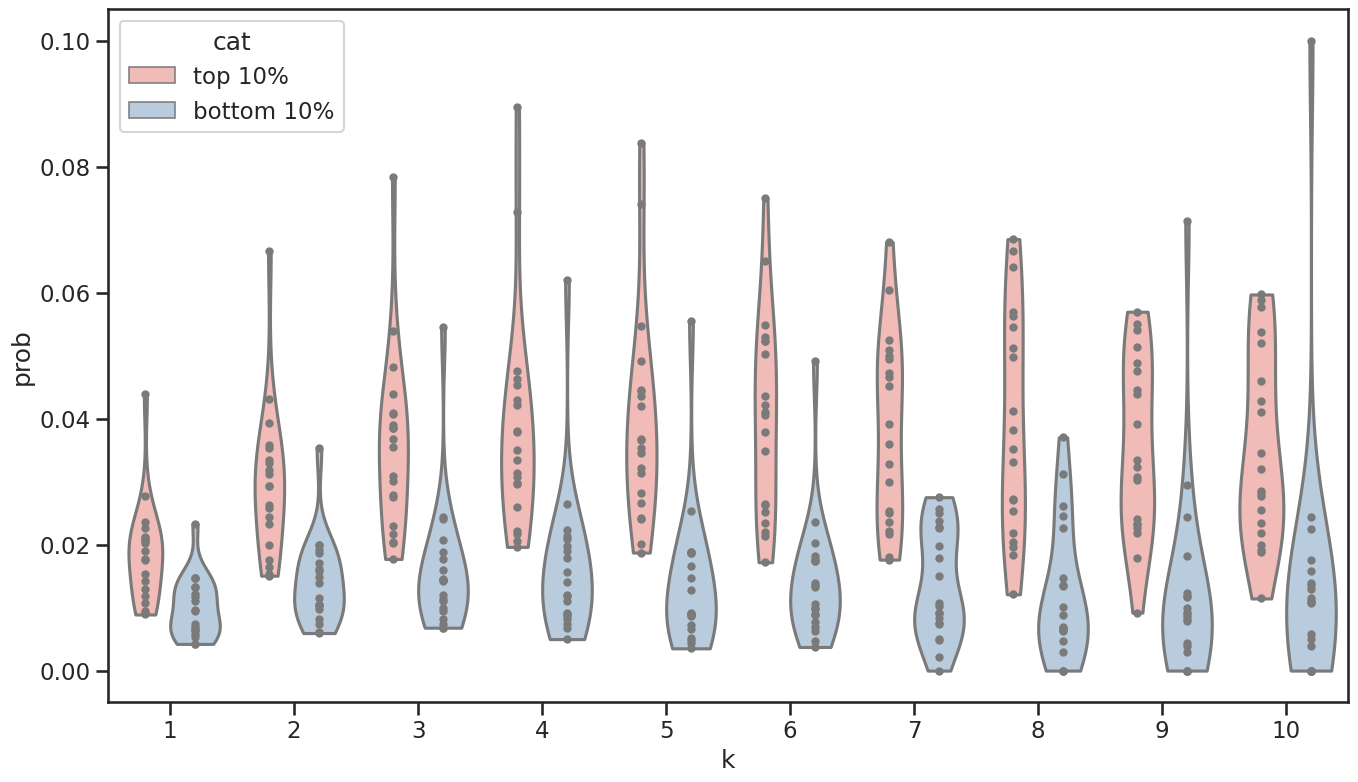

In [340]:
fig, ax = plt.subplots(figsize=(16, 9))
args = dict(cut=0, inner='point', palette='Pastel1', split=False)

df = (
    pd.concat([
        topic_data_df
        [['k', 'prob_high1']]
        .assign(cat='top 10%')
        .rename(columns={'prob_high1': 'prob'}),
        topic_data_df
        [['k', 'prob_low1']]
        .assign(cat='bottom 10%')
        .rename(columns={'prob_low1': 'prob'})
        ,
    ])
    .assign(topic=topic)
    .dropna()
)
display(df)
sns.violinplot(data=df, x='k', y='prob', hue='cat',
               ax=ax, label='top 10%', **args);
# sns.boxplot(data=df, x='k', y='prob', hue='cat', ax=ax, palette='Pastel1');